In [1]:
import pandas as pd
import scipy.io
from os import listdir
from sklearn.utils import shuffle
from sklearn import preprocessing
from nilearn import plotting
#from proteus.io import util
from proteus.visu import sbp_visu

import glob,os
import nibabel as nib


import pickle
from proteus.predic import high_confidence_at
import numpy as np
import pandas as pd
from proteus.predic import prediction
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold

from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from copy import deepcopy

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def stats_mask(y_true, y_pred, mask_selected=None):
    if mask_selected is None:
        mask_selected = np.ones(y_pred.shape).astype(bool)
    print('------------------------')
    print('Ratio:', y_true[mask_selected].sum()/y_true.sum()) 
    print('#    : ', y_true[mask_selected].sum()) 
    print('# true values: ',mask_selected.sum())
    print('ACC  : ', np.mean((y_true == y_pred)[mask_selected])) 

In [3]:
def predic_stats(y_, y_pred, lr_decision):
    # number of AD subjects
    n_ad = sum(y_)
    print('Total number of TARGET subjects: ', n_ad)

    # number of CN subjects
    n_cn = len(y_) - sum(y_)
    print('Total number of NON-TARGET subjects: ', n_cn)
    
    # number of subjects predicted as AD at stage 1
    n_pos = sum(y_pred)
    print('Stage 1 number of hits (true and false positives): ', n_pos)
    
    # true positives at stage 1
    n_pos_ad = sum(y_pred[y_.astype(bool)])
    print('Stage 1 TRUE positives: ', n_pos_ad)
    
    # false positives at stage 1
    n_pos_cn = n_pos - n_pos_ad
    print('Stage 1 FALSE positives: ', n_pos_cn)
    
    # number of CN subjects not identified as positive (true negatives)
    n_neg1_cn = n_cn - n_pos_cn
    print('Stage 1 TRUE negatives: ', n_neg1_cn)

    # number of all flagged HPC-AD subjects
    n_flag = sum(y_pred[lr_decision>0])
    print('Total number of flagged HPC-AD subjects: ', n_flag)

    # number of flagged HPC-AD subjects who are actually AD (true positives)
    n_flag_ad = sum(y_[lr_decision>0])
    print('Number of flagged HPC-AD subjects that are TRUE positives: ', n_flag_ad)

    # number of flagged HPC-AD subjects that are actually CN (false positives)
    n_flag_cn = n_flag - n_flag_ad
    print('Number of flagged HPC-AD subjects that are FALSE positives: ', n_flag_cn)

    # number of CN subjects that were not flagged (true negatives)
    n_neg_cn = n_cn - n_flag_cn
    print('Number of true negatives: ', n_neg_cn)
    
    print('#############################')
    print('Stage 1 stats for TARGET vs NON-TARGET')
    print('Precision for AD: ', n_pos_ad/(n_pos_ad + n_pos_cn))
    prec = n_pos_ad/(n_pos_ad + n_pos_cn)
    print('Recall (or sensitivity)  for AD: ', n_pos_ad/n_ad)
    sens = n_pos_ad/n_ad
    print('Specificity: ', n_neg1_cn/n_cn)
    spec = n_neg1_cn/n_cn
    fp = (1-spec)*664
    tp = sens*336
    adj_prec = tp/(tp+fp)
    print('Adjusted precision for 33.6% baseline rate: ', adj_prec)
    print('Accuracy: ', (n_pos_ad + n_neg1_cn)/(n_ad + n_cn))
    acc = (n_pos_ad + n_neg1_cn)/(n_ad + n_cn)

    print('#############################')
    print('Stage 2 stats for TARGET vs NON-TARGET')
    print('Precision for HPC-AD: ', n_flag_ad/n_flag)
    prec_2 = n_flag_ad/n_flag
    print('Recall (or sensitivity) for HPC-AD: ', n_flag_ad/n_ad)
    sens_2 = n_flag_ad/n_ad
    print('Specificity: ', n_neg_cn/n_cn)
    spec_2 = n_neg_cn/n_cn
    fp_2 = (1-spec_2)*664
    tp_2 = sens_2*336
    adj_prec_2 = tp_2/(tp_2 + fp_2)
    print('Adjusted precision for 33.6% baseline rate: ', adj_prec_2)
    print('Accuracy: ', (n_flag_ad + n_neg_cn)/(n_ad + n_cn))
    acc_2 = (n_flag_ad + n_neg_cn)/(n_ad + n_cn)
    
    return sens, spec, prec, acc, sens_2, spec_2, prec_2, acc_2

In [4]:
def hpc_df(dataframe, y_pred, lr_decision):
    # make mask out of flagged subjects
    mask_flag_hpc = lr_decision>0
    # stack the predicted values and mask so we can put it into a dataframe
    pred = np.stack((y_pred,mask_flag_hpc),axis=1)
    # make dataframe
    flag_df = pd.DataFrame(data=pred, columns=['f_s1','f_hpc'])
    # add flag status to dataframe, so we can see which subjects have been flagged
    dataframe['f_s1'] = flag_df['f_s1'].values
    dataframe['f_hpc'] = flag_df['f_hpc'].values
    # create labels based on flags at stage 1 and stage 2
    for i,row in dataframe.iterrows():
        s1 = row[dataframe.columns.get_loc("f_s1")]
        hp = row[dataframe.columns.get_loc("f_hpc")]
        if s1 == 0 and hp == 0: 
            dataframe.ix[i,'flag_status'] = 'Negative'
        if s1 == 1 and hp == 0:
            dataframe.ix[i,'flag_status'] = 'Non-HPS+'
        if hp == 1:
            dataframe.ix[i,'flag_status'] = 'HPS+'
    # create dummy variables based on flags
    for i,row in dataframe.iterrows():
        flag = row[dataframe.columns.get_loc("flag_status")]
        if flag == 'Negative':
            dataframe.ix[i, 'f_neg'] = 1
            dataframe.ix[i, 'f_s1_only'] = 0
        if flag == 'Non-HPS+':
            dataframe.ix[i, 'f_neg'] = 0
            dataframe.ix[i, 'f_s1_only'] = 1
        if flag == 'HPS+':
            dataframe.ix[i, 'f_neg'] = 0
            dataframe.ix[i, 'f_s1_only'] = 0
    # create labels for diagnosis and flags
    try:
        for i,row in dataframe.iterrows():
            flag = row[dataframe.columns.get_loc("flag_status")]
            dx = row[dataframe.columns.get_loc("DX")]
            conv_ad = row[dataframe.columns.get_loc("conv_2_ad")]
            if flag == 'Negative':
                if dx == 'CN':
                    dataframe.ix[i, 'flag_dx'] = 'CN-'
                if dx == 'MCI' and conv_ad == 0:
                    dataframe.ix[i, 'flag_dx'] = 'sMCI-'
                if dx == 'MCI' and conv_ad == 1:
                    dataframe.ix[i, 'flag_dx'] = 'pMCI-'
                if dx == 'Dementia':
                    dataframe.ix[i, 'flag_dx'] = 'AD-'
            if flag == 'Non-HPS+':
                if dx == 'CN':
                    dataframe.ix[i, 'flag_dx'] = 'CN+'
                if dx == 'MCI' and conv_ad == 0:
                    dataframe.ix[i, 'flag_dx'] = 'sMCI+'
                if dx == 'MCI' and conv_ad == 1:
                    dataframe.ix[i, 'flag_dx'] = 'pMCI+'
                if dx == 'Dementia':
                    dataframe.ix[i, 'flag_dx'] = 'AD+'
            if flag == 'HPS+':
                if dx == 'CN':
                    dataframe.ix[i, 'flag_dx'] = 'HPS+ CN'
                if dx == 'MCI' and conv_ad == 0:
                    dataframe.ix[i, 'flag_dx'] = 'HPS+ sMCI'
                if dx == 'MCI' and conv_ad == 1:
                    dataframe.ix[i, 'flag_dx'] = 'HPS+ pMCI'
                if dx == 'Dementia':
                    dataframe.ix[i, 'flag_dx'] = 'HPS+ AD'
    except:
        pass

In [5]:
# function to calculate ratios for a binary variable of interest (voi) between the target and non-target groups
def compare_ratio_var(dataframe, voi, target_grp):
    
    # number of Abeta+ CN subjects
    a = dataframe[dataframe['%s'%target_grp]==0]['%s'%voi].sum()
    b = len(dataframe[(pd.notnull(dataframe['%s'%voi]) & (dataframe['%s'%target_grp]==0))])
    print('baseline rate in NON-TARGET subjects: ', a/b)

    print('#'*10)
    # number of Abeta+ AD subjects
    a = dataframe[dataframe['%s'%target_grp]==1]['%s'%voi].sum()
    b = len(dataframe[(pd.notnull(dataframe['%s'%voi]) & (dataframe['%s'%target_grp]==1))])
    print('baseline rate in TARGET subjects: ', a/b)

    print('#'*10)
    # number of Abeta+ subjects in the whole sample
    a = dataframe['%s'%voi].sum()
    print('number of subjects with VOI in the whole sample: ', a)

    # total number of subjects with amyloid data in whole sample
    b = len(dataframe[(pd.notnull(dataframe['%s'%voi]))])
    print('total number of subjects with VOI data in whole sample: ', b)

    print('ratio: ', a/b)

    print('#'*10)
    # number of Abeta+ subjects that are positive at stage 1 (including HPC)
    a = dataframe[dataframe.f_s1==1]['%s'%voi].sum()
    print('number of subjects with VOI that are positive at stage 1: ', a)

    # total number of positive stage 1 subjects with amyloid data
    b = len(dataframe[(pd.notnull(dataframe['%s'%voi]) & (dataframe.f_s1==1))])
    print('total number of positive stage 1 subjects with VOI data: ', b)

    print('ratio: ', a/b)

    print('#'*10)
    # number of Abeta+ subjects in HPC-AD
    a = dataframe[dataframe.f_hpc==1]['%s'%voi].sum()
    print('number of subjects with VOI in HPC-AD: ', a)

    # total number of HPC-AD subjects with amyloid data
    b = len(dataframe[(pd.notnull(dataframe['%s'%voi]) & (dataframe.f_hpc==1))])
    print('total number of HPC-AD subjects with VOI data: ', b)

    print('ratio: ', a/b)

    print('#'*10)
    # number of Abeta+ subjects in Non-HPC+
    a = dataframe[dataframe.f_s1_only==1]['%s'%voi].sum()
    print('number of subjects with VOI in Non-HPC+: ', a)

    # total number of Non-HPC+ with amyloid data
    b = len(dataframe[(pd.notnull(dataframe['%s'%voi]) & (dataframe.f_s1_only==1))])
    print('total number of Non-HPC+ with VOI data: ', b)

    print('ratio: ', a/b)

    print('#'*10)
    # number of Abeta+ subjects in negative subjects
    a = dataframe[dataframe.f_neg==1]['%s'%voi].sum()
    print('number of subjects with VOI in negative subjects: ', a)

    # total number of negative subjects with amyloid data
    b = len(dataframe[(pd.notnull(dataframe['%s'%voi]) & (dataframe.f_neg==1))])
    print('total number of negative subjects with VOI data', b)

    print('ratio: ', a/b)

In [6]:
def chi2_fn(dataframe, voi):
    
    neg = dataframe[dataframe.flag_status == 'Negative']['%s'%voi].dropna()
    pos = dataframe[dataframe.flag_status == 'Non-HPS+']['%s'%voi].dropna()
    pos_hpc = dataframe[dataframe.flag_status == 'HPS+']['%s'%voi].dropna()
    data = {'%s'%voi: ['-','+'],
           'Negative': [len(neg)-sum(neg), sum(neg)],
           'Non-HPS+': [len(pos)-sum(pos), sum(pos)],
           'HPS+': [len(pos_hpc)-sum(pos_hpc), sum(pos_hpc)]}
    df = pd.DataFrame(data, columns={'%s'%voi, 'Negative', 'Non-HPS+', 'HPS+'})
    obs = df.as_matrix(columns=['Negative', 'Non-HPS+', 'HPS+'])
    chi2, p, dof, exf = scipy.stats.chi2_contingency(obs)
    print('observed freq: ')
    print(obs)
    print('Chi2: ', chi2)
    print('p value: ', p)
    print('degress of freedom: ', dof)
    print('expected freq: ')
    print(exf)
    
    return df

In [7]:
def hpc_pie(df, voi, filename):
    plt.close()
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,6))
    ax1.pie(df['Negative'], labels=df['%s'%voi],autopct='%1.1f%%',startangle=90)
    ax1.set_title('Negatives')
    ax1.set(adjustable='box-forced', aspect='equal')
    ax2.pie(df['Non-HPS+'], labels=df['%s'%voi],autopct='%1.1f%%',startangle=90)
    ax2.set_title('Non-HPS+')
    ax2.set(adjustable='box-forced', aspect='equal')
    ax3.pie(df['HPS+'], labels=df['%s'%voi],autopct='%1.1f%%',startangle=90)
    ax3.set_title('HPS+')
    ax3.set(adjustable='box-forced', aspect='equal')
    plt.show()
    fig.savefig(filename)

In [8]:
def anova_hpc(df, voi, ymin, ymax, filename):
    #sns.set_style('white')
    neg = df[df.flag_status == 'Negative']["%s"%voi].dropna()
    pos = df[df.flag_status == 'Non-HPS+']["%s"%voi].dropna()
    pos_hpc = df[df.flag_status == 'HPS+']["%s"%voi].dropna()
    f, p = scipy.stats.f_oneway(neg,pos,pos_hpc)
    # boxplot of weights across groups
    x_order = ['Negative','Non-HPS+', 'HPS+']
    # set figure size
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    sns.boxplot(x="flag_status", y="%s"%voi, data=df, fliersize=0, order=x_order, palette='Greys')
    sns.swarmplot(x="flag_status",y="%s"%voi,data=df, color="0.2", size=6, order=x_order)
    plt.ylim(ymin, ymax)
    plt.show()
    fig.savefig(filename)
    print('ANOVA F: ', f)
    print('p value: ', p)
    
    # do pairwise post hoc tests
    tmp_df = df.dropna(axis=0, how='any', subset=['%s'%voi])
    print(pairwise_tukeyhsd(tmp_df['%s'%voi], tmp_df['flag_status']))

In [9]:
def anova_hpc_split(df, voi, ymin, ymax, grp1, grp2, filename):
    #sns.set_style('white')    
    neg1 = df[df.flag_dx == '%s-'%grp1]["%s"%voi].dropna()
    pos1 = df[df.flag_dx == '%s+'%grp1]["%s"%voi].dropna()
    pos_hpc1 = df[df.flag_dx == 'HPS+ %s'%grp1]["%s"%voi].dropna()
    
    neg2 = df[df.flag_dx == '%s-'%grp2]["%s"%voi].dropna()
    pos2 = df[df.flag_dx == '%s+'%grp2]["%s"%voi].dropna()
    pos_hpc2 = df[df.flag_dx == 'HPS+ %s'%grp2]["%s"%voi].dropna()
    
    f, p = scipy.stats.f_oneway(neg1,pos1,pos_hpc2,neg2,pos2,pos_hpc1)
    # boxplot of weights across groups
    x_order = ['%s-'%grp1, '%s+'%grp1, 'HPS+ %s'%grp1,'%s-'%grp2, '%s+'%grp2, 'HPS+ %s'%grp2]
    # set figure size
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    sns.boxplot(x="flag_dx", y="%s"%voi, data=df, fliersize=0, order=x_order)
    sns.swarmplot(x="flag_dx",y="%s"%voi,data=df, color="0.2", size=5, edgecolor='gray', order=x_order)
    plt.ylim(ymin, ymax)
    plt.show()
    fig.savefig(filename)
    print('ANOVA F: ', f)
    print('p value: ', p)
    
    # do pairwise post hoc tests
    #mask = df.loc[:,['%s'%grp1,'%s'%grp2]].values.sum(1).astype(bool)
    #m_df = df.iloc[mask]
    tmp_df = df.dropna(axis=0, how='any', subset=['%s'%voi])
    print(pairwise_tukeyhsd(tmp_df['%s'%voi], tmp_df['flag_dx']))

In [10]:
sns.set(font_scale=3)
sns.set_style("white")
#sns.set_context("paper")
#sns.set_palette("colorblind")
#sns.set_palette("GnBu_d")

#sns.set_palette(sns.cubehelix_palette(n_colors=8))
#sns.set_palette(sns.color_palette("BrBG", 6))

cpal = ["#F0DFB2", "#CFA255", "#995D12", "#B3E2DB", "#58B0A6", "#0D7068"]
sns.set_palette(cpal)


In [11]:
path_results = '/Users/AngelaTam/Desktop/adsf/adni1_vbm_adcn_subtypes_20171209/7clus/figures_final/'

In [12]:
np.random.seed(1)

## Load longitudinal data for everyone 

In [13]:
long_data = pd.read_csv('/Users/AngelaTam/Desktop/adsf/adni_csv/adnimerge_upenn_unw_av45_neurobat.csv')

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (101) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
# keep only up to 36 month follow-up
long_data.drop(long_data[(long_data.Month > 37)].index, inplace=True)

# Load data for the training set (ADNI1)

In [15]:
data = pd.read_csv('/Users/AngelaTam/Desktop/adsf/adni1_vbm_adcn_subtypes_20171209/7clus/adni1_model_weights.csv')

In [16]:
data.dropna(subset=['sub1','age_scan','gender','mean_gm','tiv'],inplace=True)

# Organize the AD & CN data for classification task

In [17]:
# Mask of the CN and AD subjects only
mask_cnad = data.loc[:,['CN','AD']].values.sum(1).astype(bool)

In [18]:
#reload(high_confidence)
scalerX = preprocessing.StandardScaler()
scaler = preprocessing.StandardScaler()

x_ = data.iloc[mask_cnad,data.columns.get_loc("sub1"):data.columns.get_loc("sub7")+1].values
#x_ = scalerX.fit_transform(x_)
y_ = data[['AD']].values.ravel()[mask_cnad]

confounds = data[['gender','age_scan','mean_gm','tiv']].values[mask_cnad,:]
#confounds = data[['sex','age_r']].values[mask_cnad,:]
#confounds[:, 1:] = scaler.fit_transform(confounds[:, 1:])
#confounds[:, 0] = preprocessing.binarize(confounds[:, 0].reshape(-1, 1), threshold=1)[:, 0]

#crm = prediction.ConfoundsRm(confounds, x_)
#x_ = crm.transform(confounds, x_)

x_ = scaler.fit_transform(np.hstack((x_,confounds)))
#x_ = np.hstack((x_,confounds))


x_.shape, y_.shape, confounds.shape

((377, 11), (377,), (377, 4))

# Cross-validation HPC in ADNI1 AD & CN

In [20]:
scores_ad_cn=[]
scores_s2 = []
ad_precision = []
cn_precision = []
ad_recall = []
cn_recall = []
ad_f1_score = []
cn_f1_score = []

s1_spec = []
s1_sens = []
s1_prec = []
s1_acc = []

s2_spec = []
s2_sens = []
s2_prec = []
s2_acc = []

skf = StratifiedKFold(n_splits=3)
for train_index, val_index in skf.split(x_,y_):
    X_training, X_val = x_[train_index], x_[val_index]
    y_training, y_val = y_[train_index], y_[val_index]
    
    hpc = high_confidence_at.TwoStagesPrediction(
        n_iter=500,
        shuffle_test_split=0.5,
        min_gamma=.99,
        thresh_ratio=0.1)
    
    hpc.fit(X_training, X_training, y_training)
    
    _, dic_results = hpc.predict(X_val, X_val)
    
    # test in validation sample
    acc = metrics.accuracy_score(y_val, (dic_results['s1df'][:,0]>0).astype(float))
    tmp_mask = (dic_results['s2df'][:,1]>0)
    acc_s2 = metrics.accuracy_score(y_val[tmp_mask], (dic_results['s1df'][:,0]>0).astype(float)[tmp_mask])
    scores_ad_cn.append(acc)
    scores_s2.append(acc_s2)
    print('Classifying AD vs CN...')
    print((dic_results['s1df'][:,0]>0).astype(float))
    
    y_pred = (dic_results['s1df'][:,0]>0).astype(float)
    lr_decision = dic_results['s2df'][:,1]
    
    ad_p = metrics.precision_score(y_val, y_pred)
    ad_precision.append(ad_p)
    cn_p = metrics.precision_score(y_val, y_pred, pos_label=0)
    cn_precision.append(cn_p)
    ad_r = metrics.recall_score(y_val, y_pred)
    ad_recall.append(ad_r)
    cn_r = metrics.recall_score(y_val, y_pred, pos_label=0)
    cn_recall.append(cn_r)
    ad_f1 = metrics.f1_score(y_val, y_pred)
    ad_f1_score.append(ad_f1)
    cn_f1 = metrics.f1_score(y_val, y_pred, pos_label=0)
    cn_f1_score.append(cn_f1)
    
    sens, spec, prec, acc, sens_2, spec_2, prec_2, acc_2 = predic_stats(y_val, y_pred, lr_decision)
    s1_spec.append(spec)
    s1_sens.append(sens)
    s1_prec.append(prec)
    s1_acc.append(acc)
    s2_spec.append(spec_2)
    s2_sens.append(sens_2)
    s2_prec.append(prec_2)
    s2_acc.append(acc_2)

Stage 1
Proba:
[ 0.9957265   1.          1.          1.          1.          0.65254237
  0.98380567  0.50746269  1.          1.          0.56818182  1.          1.
  1.          0.93589744  1.          0.99574468  0.71814672  1.          1.
  0.04918033  0.98333333  1.          0.88416988  0.608       0.92828685
  1.          1.          1.          1.          0.996       0.99607843
  1.          1.          1.          0.996139    0.85470085  0.31746032
  0.76377953  1.          1.          0.69635628  1.          1.          1.
  0.99607843  0.98297872  1.          1.          1.          1.
  0.56097561  0.          0.61111111  1.          0.94466403  1.
  0.99239544  0.98        1.          0.99596774  1.          0.93495935
  1.          1.          0.99193548  1.          1.          0.96186441
  0.85098039  1.          1.          1.          0.63559322  1.
  0.99618321  1.          1.          1.          1.          0.94023904
  1.          1.          0.89105058  0.99595142

Adjusted precision for 33.6% baseline rate:  0.949274663064
Accuracy:  0.784
Stage 1
Proba:
[ 0.28688525  0.99603175  1.          1.          0.91153846  1.
  0.99579832  0.86521739  0.0112782   1.          0.28085106  0.9874477
  0.99590164  0.90114068  1.          0.8968254   1.          1.
  0.98846154  1.          1.          0.94117647  0.93951613  1.
  0.97482014  1.          0.          0.92857143  1.          0.          1.
  0.8559322   1.          0.21285141  1.          1.          0.99206349
  0.22222222  1.          1.          0.13114754  1.          1.          0.9755102
  1.          1.          0.99563319  1.          0.          1.          1.
  1.          0.98367347  1.          0.05555556  0.94849785  0.01298701
  0.99615385  0.14173228  0.3776824   1.          0.40304183  1.          1.
  0.90588235  1.          1.          1.          1.          1.
  0.96911197  0.91828794  0.67424242  1.          0.64344262  0.89699571
  1.          1.          1.          1.  

In [21]:
print('Stage 1')
print('Mean sensitivity: ', np.mean(s1_sens))
print('Mean specificity: ', np.mean(s1_spec))
print('Mean precision: ', np.mean(s1_prec))
print('Mean accuracy: ', np.mean(s1_acc))
print('#'*10)
print('Stage 2')
print('Mean sensitivity: ', np.mean(s2_sens))
print('Mean specificity: ', np.mean(s2_spec))
print('Mean precision: ', np.mean(s2_prec))
print('Mean accuracy: ', np.mean(s2_acc))

Stage 1
Mean sensitivity:  0.796229078443
Mean specificity:  0.892512077295
Mean precision:  0.863693625598
Mean accuracy:  0.848587926509
##########
Stage 2
Mean sensitivity:  0.546380318613
Mean specificity:  0.960926399545
Mean precision:  0.922916666667
Mean accuracy:  0.771800524934


# Train HPC (on whole training set of ADNI1 AD & CN)

In [22]:
#reload(high_confidence)
hpc = high_confidence_at.TwoStagesPrediction(
    n_iter=500,
    shuffle_test_split=0.5,
    min_gamma=.99,
    thresh_ratio=0.1)

hpc.fit(x_, x_, y_)

Stage 1
Proba:
[ 0.648       1.          1.          1.          0.99212598  1.          1.
  1.          0.          1.          0.26217228  1.          1.
  0.99588477  1.          1.          1.          1.          1.
  0.99628253  1.          1.          1.          1.          1.          1.
  0.          1.          1.          0.          1.          0.7375      1.
  0.54585153  1.          1.          1.          0.1259542   1.          1.
  0.16862745  1.          1.          1.          1.          1.
  0.97154472  1.          0.          1.          1.          1.          1.
  1.          0.          1.          0.          0.99596774  0.29296875
  0.3372093   1.          0.97021277  1.          1.          0.9280303   1.
  1.          1.          1.          1.          0.87951807  0.856
  0.89112903  1.          0.67901235  0.93233083  1.          1.          1.
  1.          1.          1.          1.          1.          0.9921875   1.
  0.09745763  0.72962963  1.     

In [23]:
array_results, dic_results = hpc.predict(x_, x_)

# Level 1
print('Level 1')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float))

print('Level 2')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float), dic_results['s2df'][:,1]>0)
#stats_mask(dic_results['s2df'][:,2]>0)
#stats_mask(dic_results['s2df'][:,3]>0)

Level 1
------------------------
Ratio: 1.0
#    :  172.0
# true values:  377
ACC  :  0.864721485411
Level 2
------------------------
Ratio: 0.622093023256
#    :  107.0
# true values:  114
ACC  :  0.938596491228


In [24]:
hpc.confidencemodel.clfs[1].coef_

array([[ 3.97549188,  1.70953522, -1.45423364,  0.31985473,  0.        ,
         4.87282972, -0.24512667, -0.61703201, -1.23870659, -5.07100191,
         2.58010883]])

In [25]:
# plot weights from the model
w_df = pd.DataFrame(data=np.transpose(hpc.confidencemodel.clfs[1].coef_),columns=['Coefficient'])
w_df['Factor'] = ['VBM 1','VBM 2','VBM 3','VBM 4','VBM 5','VBM 6','VBM 7',
                  'sex','age','GMV','TIV']

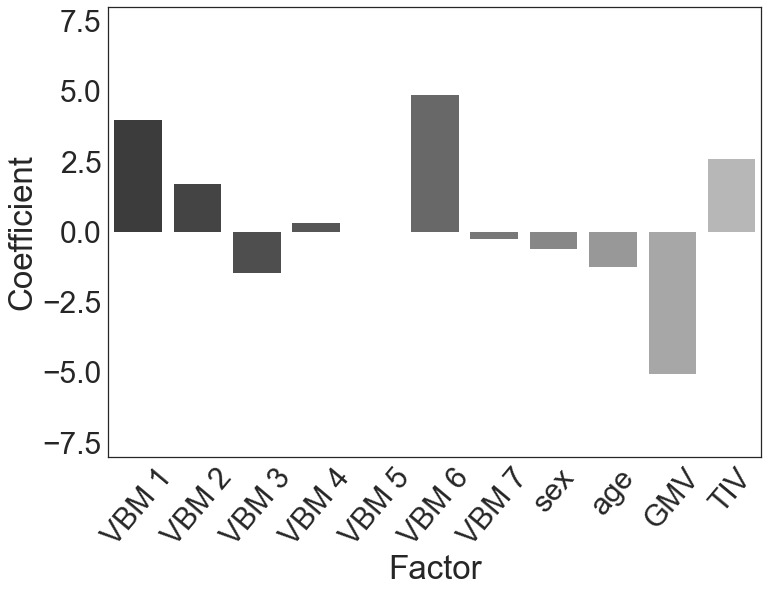

In [27]:
#sns.set(font_scale=2)
#sns.set_style('white')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

#fig,ax = plt.subplots(figsize=(11.7, 8.27))
sns.factorplot(ax=ax, y='Coefficient', x='Factor', data=w_df, kind='bar', palette="Greys_d")
#ax.set_xticklabels(rotation=50)
for item in ax.get_xticklabels():
    item.set_rotation(50)
ax.set_ylim(-8,8)
plt.close()
plt.show()
fig.savefig(path_results + 'weights_model.pdf',bbox_inches='tight')

In [28]:
y_pred = (dic_results['s1df'][:,0]>0).astype(float)
lr_decision = dic_results['s2df'][:,1]

In [29]:
print('Stage 1 stats for AD vs CN')
print(metrics.classification_report(y_, y_pred))

Stage 1 stats for AD vs CN
             precision    recall  f1-score   support

        0.0       0.85      0.91      0.88       205
        1.0       0.88      0.81      0.85       172

avg / total       0.87      0.86      0.86       377



In [30]:
predic_stats(y_, y_pred, lr_decision)

Total number of TARGET subjects:  172.0
Total number of NON-TARGET subjects:  205.0
Stage 1 number of hits (true and false positives):  159.0
Stage 1 TRUE positives:  140.0
Stage 1 FALSE positives:  19.0
Stage 1 TRUE negatives:  186.0
Total number of flagged HPC-AD subjects:  114.0
Number of flagged HPC-AD subjects that are TRUE positives:  107.0
Number of flagged HPC-AD subjects that are FALSE positives:  7.0
Number of true negatives:  198.0
#############################
Stage 1 stats for TARGET vs NON-TARGET
Precision for AD:  0.880503144654
Recall (or sensitivity)  for AD:  0.813953488372
Specificity:  0.907317073171
Adjusted precision for 33.6% baseline rate:  0.816310498671
Accuracy:  0.864721485411
#############################
Stage 2 stats for TARGET vs NON-TARGET
Precision for HPC-AD:  0.938596491228
Recall (or sensitivity) for HPC-AD:  0.622093023256
Specificity:  0.965853658537
Adjusted precision for 33.6% baseline rate:  0.902142769011
Accuracy:  0.809018567639


(0.81395348837209303,
 0.90731707317073174,
 0.88050314465408808,
 0.86472148541114058,
 0.62209302325581395,
 0.96585365853658534,
 0.93859649122807021,
 0.80901856763925728)

In [31]:
plt.hist(hpc.training_hit_probability,20)
plt.ylim(0,300)
plt.rcParams.update({'font.size': 18})

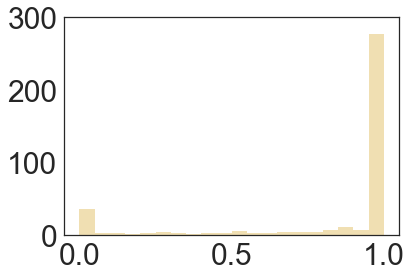

In [32]:
plt.show()

# characteristics of HPC-AD people in ADNI1 AD/CN

In [33]:
# copy data frame and mask
df1 = deepcopy(data)
df1 = df1[mask_cnad]

In [34]:
hpc_df(df1, y_pred, lr_decision)

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [35]:
long_df_adni1_adcn = pd.merge(long_data, df1[['RID','flag_dx','flag_status']], 
                              how='left', on=['RID'])

In [36]:
long_df_adni1_adcn.dropna(subset=['flag_status'],inplace=True)

In [37]:
long_df_adni1_adcn.reset_index(inplace=True, drop=True)

In [38]:
long_df_adni1_adcn.to_csv(path_results + 'adni1_adcn_hps.csv', index=False)

In [39]:
compare_ratio_var(df1, 'APOE4_bin', 'AD')

baseline rate in NON-TARGET subjects:  0.2780487804878049
##########
baseline rate in TARGET subjects:  0.6627906976744186
##########
number of subjects with VOI in the whole sample:  171.0
total number of subjects with VOI data in whole sample:  377
ratio:  0.4535809018567639
##########
number of subjects with VOI that are positive at stage 1:  103.0
total number of positive stage 1 subjects with VOI data:  159
ratio:  0.6477987421383647
##########
number of subjects with VOI in HPC-AD:  74.0
total number of HPC-AD subjects with VOI data:  114
ratio:  0.6491228070175439
##########
number of subjects with VOI in Non-HPC+:  29.0
total number of Non-HPC+ with VOI data:  45
ratio:  0.6444444444444445
##########
number of subjects with VOI in negative subjects:  68.0
total number of negative subjects with VOI data 218
ratio:  0.3119266055045872


In [40]:
tmp_df = chi2_fn(df1, 'APOE4_bin')

observed freq: 
[[ 150.   16.   40.]
 [  68.   29.   74.]]
Chi2:  41.8513198853
p value:  8.16772969603e-10
degress of freedom:  2
expected freq: 
[[ 119.1193634    24.58885942   62.29177719]
 [  98.8806366    20.41114058   51.70822281]]


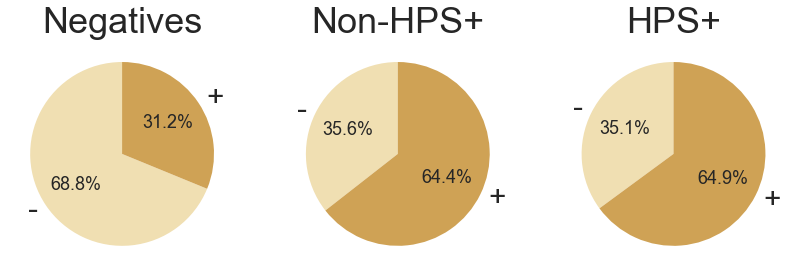

In [41]:
hpc_pie(tmp_df, 'APOE4_bin', path_results + 'adni1_adcn_hpc_e4_pie.pdf')

## sex in ADNI1 AD vs CN  (% male)

In [42]:
compare_ratio_var(df1, 'gender', 'AD')

baseline rate in NON-TARGET subjects:  0.48292682926829267
##########
baseline rate in TARGET subjects:  0.5
##########
number of subjects with VOI in the whole sample:  185.0
total number of subjects with VOI data in whole sample:  377
ratio:  0.4907161803713528
##########
number of subjects with VOI that are positive at stage 1:  80.0
total number of positive stage 1 subjects with VOI data:  159
ratio:  0.5031446540880503
##########
number of subjects with VOI in HPC-AD:  56.0
total number of HPC-AD subjects with VOI data:  114
ratio:  0.49122807017543857
##########
number of subjects with VOI in Non-HPC+:  24.0
total number of Non-HPC+ with VOI data:  45
ratio:  0.5333333333333333
##########
number of subjects with VOI in negative subjects:  105.0
total number of negative subjects with VOI data 218
ratio:  0.481651376146789


In [43]:
chi2_fn(df1, 'gender')

observed freq: 
[[ 113.   21.   58.]
 [ 105.   24.   56.]]
Chi2:  0.398829725579
p value:  0.819209963095
degress of freedom:  2
expected freq: 
[[ 111.02387268   22.91777188   58.05835544]
 [ 106.97612732   22.08222812   55.94164456]]


Negative  Non-HPS+  HPS+ gender
0     113.0      21.0  58.0      -
1     105.0      24.0  56.0      +

## CSF tau in ADNI1 AD vs CN

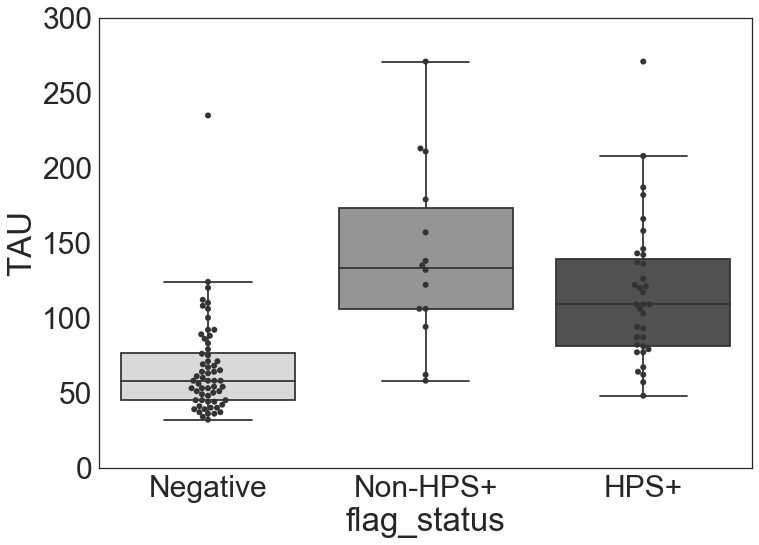

ANOVA F:  27.3934564553
p value:  2.56994556222e-10
 Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower    upper   reject
---------------------------------------------------
  HPS+   Negative -50.0714 -71.1281 -29.0147  True 
  HPS+   Non-HPS+ 25.3429  -5.9639  56.6496  False 
Negative Non-HPS+ 75.4143  46.0301  104.7985  True 
---------------------------------------------------


In [44]:
anova_hpc(df1, 'TAU', 0, 300, path_results + 'adni1_adcn_csf_tau.pdf')

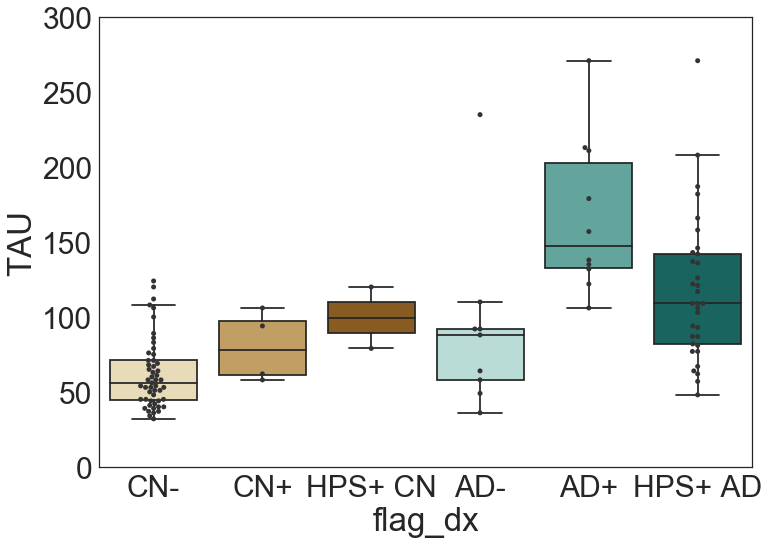

ANOVA F:  16.4244759379
p value:  6.8019961172e-12
 Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2  meandiff   lower    upper   reject
---------------------------------------------------
  AD+     AD-    -74.8444 -126.6313 -23.0576  True 
  AD+     CN+     -86.4   -153.0804 -19.7196  True 
  AD+     CN-   -104.5569  -143.537 -65.5767  True 
  AD+   HPS+ AD  -49.0061  -89.6917 -8.3204   True 
  AD+   HPS+ CN   -66.9   -154.2051 20.4051  False 
  AD-     CN+    -11.5556  -79.2861 56.1749  False 
  AD-     CN-    -29.7124  -70.4629 11.0381  False 
  AD-   HPS+ AD  25.8384   -16.5464 68.2232  False 
  AD-   HPS+ CN   7.9444   -80.1653 96.0542  False 
  CN+     CN-    -18.1569  -76.6803 40.3666  False 
  CN+   HPS+ AD  37.3939   -22.279  97.0669  False 
  CN+   HPS+ CN    19.5     -78.11   117.11  False 
  CN-   HPS+ AD  55.5508   30.3705  80.7311   True 
  CN-   HPS+ CN  37.6569   -43.5891 118.9028 False 
HPS+ AD HPS+ CN  -17.8939  -99.9718 64.1839  False 
-------------

In [45]:
anova_hpc_split(df1, 'TAU', 0, 300, 'CN', 'AD', path_results + 'adni1_adcn_csf_tau_split.pdf')

## CSF abeta in ADNI1 AD vs CN 

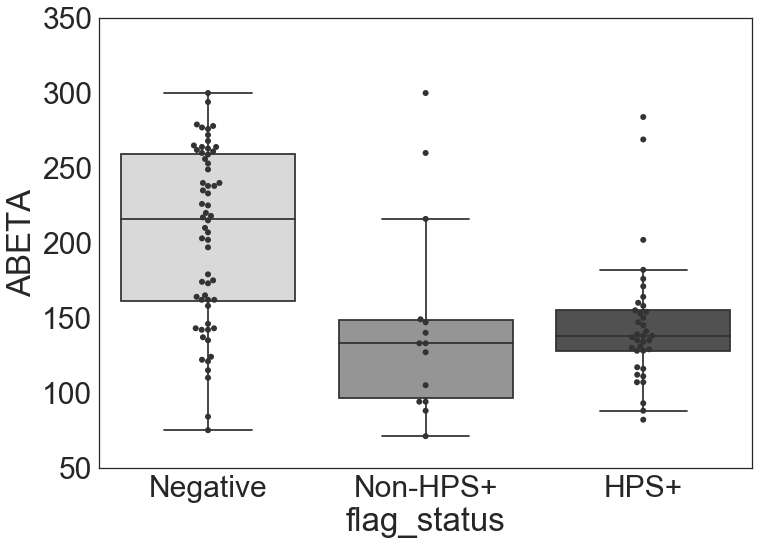

ANOVA F:  16.5254649468
p value:  5.47748630056e-07
 Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower    upper   reject
---------------------------------------------------
  HPS+   Negative 60.1302  33.1445  87.1158   True 
  HPS+   Non-HPS+  2.4421  -38.0662 42.9504  False 
Negative Non-HPS+ -57.6881 -96.0058 -19.3703  True 
---------------------------------------------------


In [46]:
anova_hpc(df1, 'ABETA', 50, 350, path_results + 'adni1_adcn_csf_abeta.pdf')

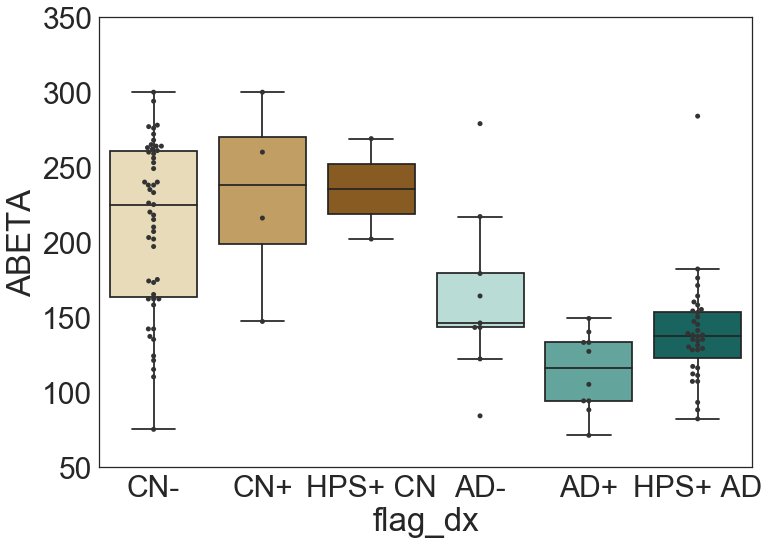

ANOVA F:  14.7551638275
p value:  6.00845818417e-11
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff   lower    upper   reject
--------------------------------------------------
  AD+     AD-   50.7111   -13.6465 115.0688 False 
  AD+     CN+    117.35   34.4836  200.2164  True 
  AD+     CN-   98.3647   49.9224  146.807   True 
  AD+   HPS+ AD 25.8857   -24.3389 76.1104  False 
  AD+   HPS+ CN  122.1    13.6024  230.5976  True 
  AD-     CN+   66.6389   -17.5326 150.8104 False 
  AD-     CN-   47.6536   -2.9888   98.296  False 
  AD-   HPS+ AD -24.8254  -77.1753 27.5245  False 
  AD-   HPS+ CN 71.3889   -38.1088 180.8865 False 
  CN+     CN-   -18.9853  -91.7148 53.7443  False 
  CN+   HPS+ AD -91.4643  -165.393 -17.5356  True 
  CN+   HPS+ CN   4.75   -116.5541 126.0541 False 
  CN-   HPS+ AD -72.479   -103.224 -41.734   True 
  CN-   HPS+ CN 23.7353   -77.2324 124.703  False 
HPS+ AD HPS+ CN 96.2143   -5.6206  198.0492 False 
------------------------------

In [47]:
anova_hpc_split(df1, 'ABETA', 50, 350, 'CN', 'AD', path_results + 'adni1_adcn_csf_abeta_split.pdf')

## age in ADNI1 AD vs CN

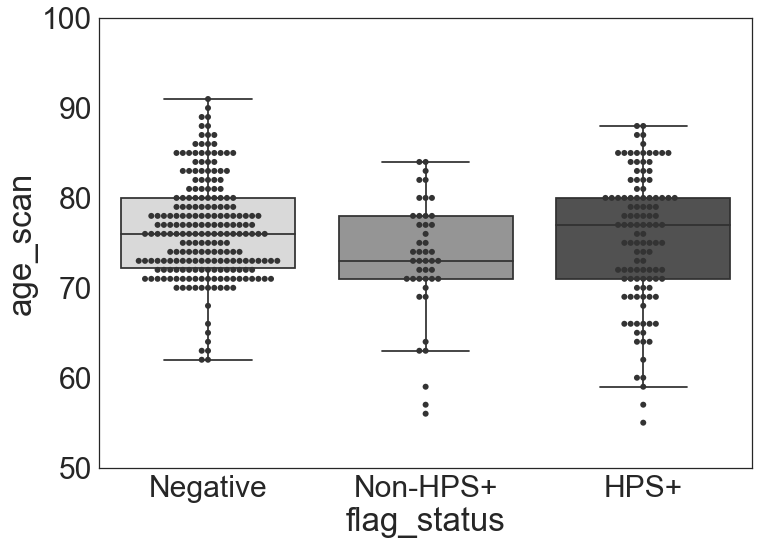

ANOVA F:  4.95909106232
p value:  0.00748783652728
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative  0.9956  -0.6941  2.6853 False 
  HPS+   Non-HPS+ -2.1368  -4.7106  0.4369 False 
Negative Non-HPS+ -3.1324  -5.5261 -0.7387  True 
-------------------------------------------------


In [48]:
anova_hpc(df1, 'age_scan', 50, 100, path_results + 'adni1_adcn_age.pdf')

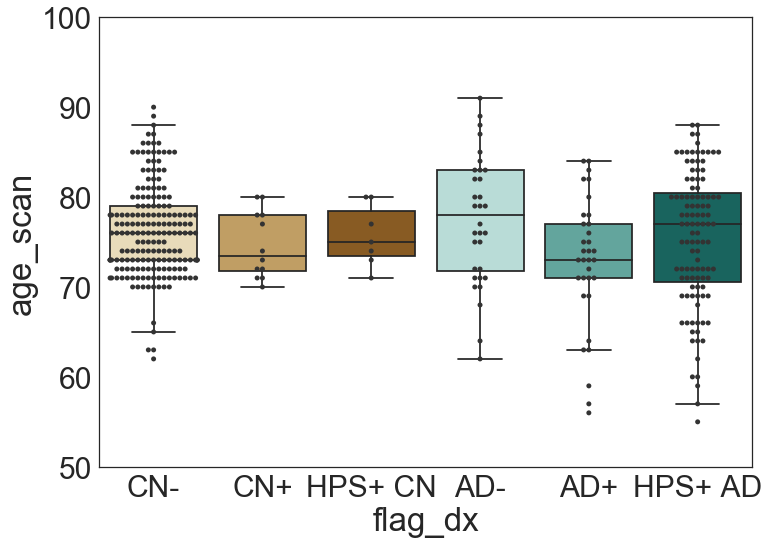

ANOVA F:  2.3828846693
p value:  0.0380143550574
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff  lower   upper  reject
-----------------------------------------------
  AD+     AD-    4.7424   0.3213  9.1635  True 
  AD+     CN+    1.9091   -4.098  7.9162 False 
  AD+     CN-    3.4521   0.0861  6.8181  True 
  AD+   HPS+ AD  2.6256  -0.9227  6.1739 False 
  AD+   HPS+ CN  2.9567  -4.4586 10.3721 False 
  AD-     CN+   -2.8333  -8.8654  3.1988 False 
  AD-     CN-   -1.2903  -4.7007  2.1201 False 
  AD-   HPS+ AD -2.1168  -5.7073  1.4736 False 
  AD-   HPS+ CN -1.7857  -9.2213  5.6499 False 
  CN+     CN-    1.543   -3.7645  6.8505 False 
  CN+   HPS+ AD  0.7165  -4.7085  6.1415 False 
  CN+   HPS+ CN  1.0476  -7.4275  9.5227 False 
  CN-   HPS+ AD -0.8265  -2.9887  1.3357 False 
  CN-   HPS+ CN -0.4954  -7.3563  6.3655 False 
HPS+ AD HPS+ CN  0.3311   -6.621  7.2833 False 
-----------------------------------------------


In [49]:
anova_hpc_split(df1, 'age_scan', 50, 100, 'CN', 'AD', path_results + 'adni1_adcn_age_split.pdf')

## cognition in ADNI1 AD vs CN

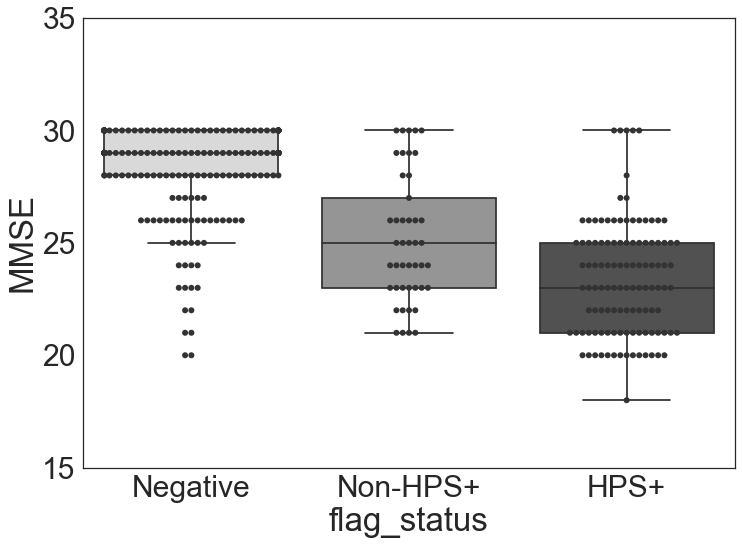

ANOVA F:  182.945729999
p value:  3.91354991577e-56
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative  4.9994   4.3692  5.6296  True 
  HPS+   Non-HPS+  1.7474   0.7875  2.7073  True 
Negative Non-HPS+  -3.252  -4.1447 -2.3592  True 
-------------------------------------------------


In [50]:
# mmse
anova_hpc(df1, 'MMSE', 15, 35, path_results + 'adni1_adcn_mmse.pdf')

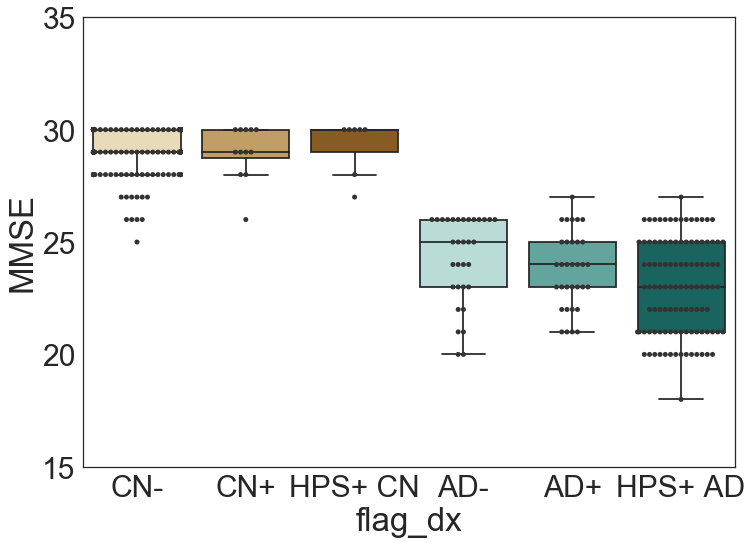

ANOVA F:  263.841874653
p value:  9.09268062147e-120
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff  lower   upper  reject
-----------------------------------------------
  AD+     AD-    0.554   -0.5356  1.6435 False 
  AD+     CN+    5.2727   3.7923  6.7531  True 
  AD+     CN-    5.3641   4.5346  6.1936  True 
  AD+   HPS+ AD -0.7273  -1.6017  0.1472 False 
  AD+   HPS+ CN  5.5584   3.731   7.3859  True 
  AD-     CN+    4.7188   3.2322  6.2053  True 
  AD-     CN-    4.8101   3.9697  5.6506  True 
  AD-   HPS+ AD -1.2812  -2.1661 -0.3964  True 
  AD-   HPS+ CN  5.0045   3.172   6.8369  True 
  CN+     CN-    0.0914  -1.2166  1.3994 False 
  CN+   HPS+ AD   -6.0   -7.3369 -4.6631  True 
  CN+   HPS+ CN  0.2857  -1.8029  2.3743 False 
  CN-   HPS+ AD -6.0914  -6.6242 -5.5586  True 
  CN-   HPS+ CN  0.1943  -1.4965  1.8851 False 
HPS+ AD HPS+ CN  6.2857   4.5724  7.999   True 
-----------------------------------------------


In [51]:
anova_hpc_split(df1, 'MMSE', 15, 35, 'CN','AD', path_results + 'adni1_adcn_mmse_split.pdf')

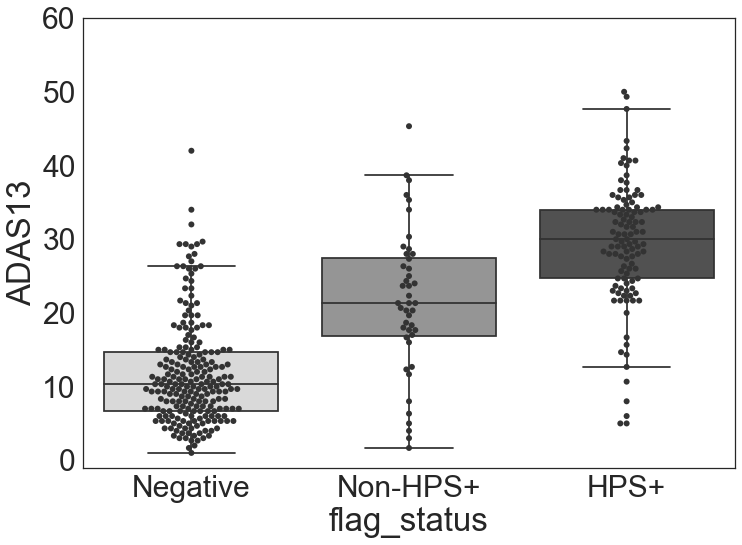

ANOVA F:  185.820300838
p value:  1.4920308697e-56
 Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower    upper   reject
---------------------------------------------------
  HPS+   Negative -17.4979  -19.66  -15.3358  True 
  HPS+   Non-HPS+ -7.8627  -11.1604 -4.5651   True 
Negative Non-HPS+  9.6352   6.5798  12.6905   True 
---------------------------------------------------


In [52]:
# adas
anova_hpc(df1, 'ADAS13', -1, 60, path_results + 'adni1_adcn_adas13.pdf')

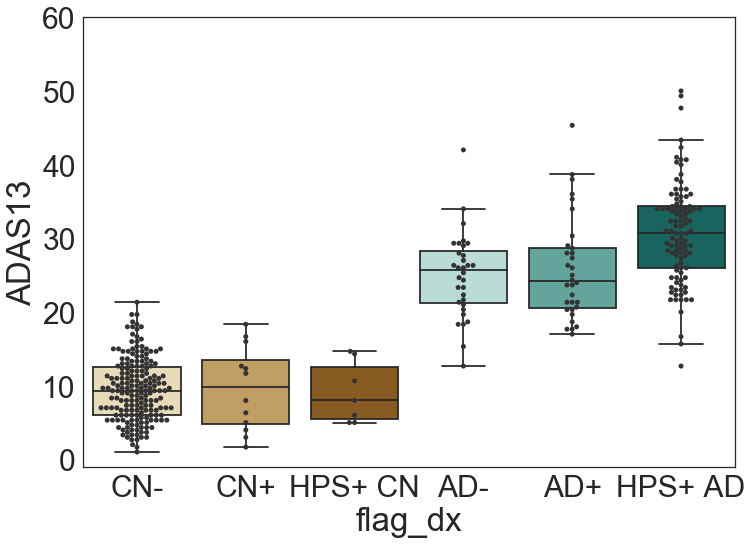

ANOVA F:  233.035936007
p value:  2.26405867112e-111
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff  lower    upper   reject
-------------------------------------------------
  AD+     AD-   -0.9069   -4.82    3.0062  False 
  AD+     CN+   -16.2355 -21.5339 -10.9371  True 
  AD+     CN-   -16.3265 -19.322  -13.3309  True 
  AD+   HPS+ AD  4.8086   1.6408   7.9764   True 
  AD+   HPS+ CN -16.779  -23.3101 -10.2478  True 
  AD-     CN+   -15.3286 -20.627  -10.0303  True 
  AD-     CN-   -15.4196 -18.4152 -12.424   True 
  AD-   HPS+ AD  5.7155   2.5477   8.8833   True 
  AD-   HPS+ CN -15.8721 -22.4033 -9.3409   True 
  CN+     CN-   -0.0909  -4.7529   4.571   False 
  CN+   HPS+ AD 21.0441  16.2697  25.8186   True 
  CN+   HPS+ CN -0.5435  -7.9877   6.9008  False 
  CN-   HPS+ AD 21.1351  19.2126  23.0575   True 
  CN-   HPS+ CN -0.4525  -6.4789   5.5739  False 
HPS+ AD HPS+ CN -21.5876 -27.7014 -15.4738  True 
----------------------------------------------

In [53]:
anova_hpc_split(df1, 'ADAS13', -1, 60, 'CN', 'AD', path_results + 'adni1_adcn_adas13_split.pdf')

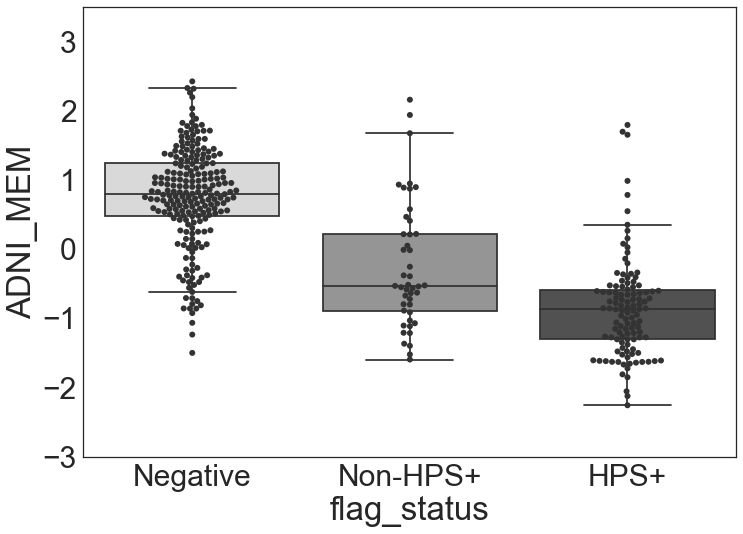

ANOVA F:  181.002937263
p value:  1.04758703546e-55
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative  1.6134   1.4099  1.817   True 
  HPS+   Non-HPS+  0.6116   0.3015  0.9217  True 
Negative Non-HPS+ -1.0019  -1.2903 -0.7135  True 
-------------------------------------------------


In [54]:
# adni_mem
anova_hpc(df1, 'ADNI_MEM', -3, 3.5, path_results + 'adni1_adcn_memory.pdf')

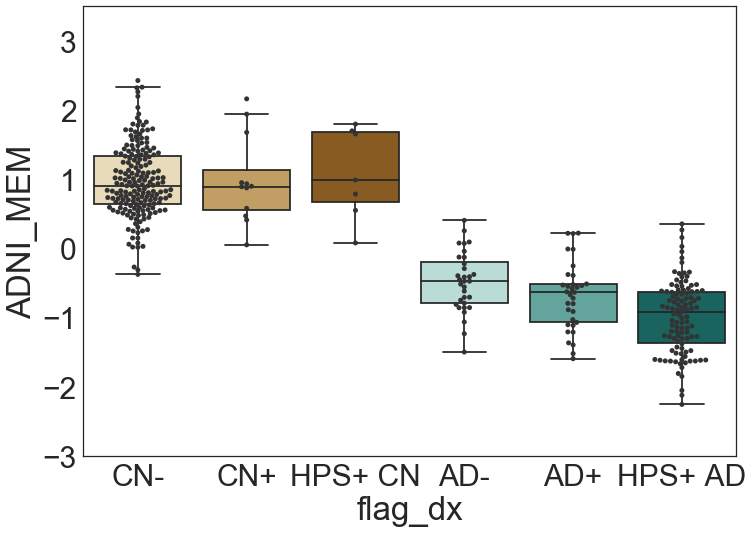

ANOVA F:  236.319780955
p value:  6.07898187234e-113
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff  lower   upper  reject
-----------------------------------------------
  AD+     AD-    0.2033   -0.163  0.5695 False 
  AD+     CN+    1.679    1.1813  2.1766  True 
  AD+     CN-    1.664    1.3852  1.9429  True 
  AD+   HPS+ AD -0.2905  -0.5844  0.0035 False 
  AD+   HPS+ CN  1.7715   1.1572  2.3859  True 
  AD-     CN+    1.4757   0.976   1.9754  True 
  AD-     CN-    1.4608   1.1782  1.7433  True 
  AD-   HPS+ AD -0.4937  -0.7912 -0.1963  True 
  AD-   HPS+ CN  1.5683   0.9523  2.1843  True 
  CN+     CN-   -0.0149  -0.4546  0.4248 False 
  CN+   HPS+ AD -1.9694  -2.4189  -1.52   True 
  CN+   HPS+ CN  0.0926  -0.6095  0.7947 False 
  CN-   HPS+ AD -1.9545  -2.1336 -1.7754  True 
  CN-   HPS+ CN  0.1075  -0.4609  0.6759 False 
HPS+ AD HPS+ CN  2.062    1.4861  2.638   True 
-----------------------------------------------


In [55]:
anova_hpc_split(df1, 'ADNI_MEM', -3, 3.5, 'CN', 'AD', path_results + 'adni1_adcn_memory_split.pdf')

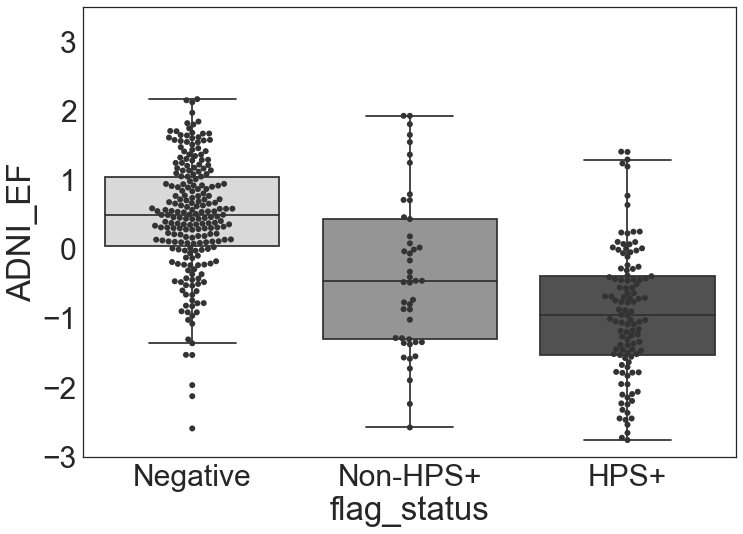

ANOVA F:  92.6761926344
p value:  2.0408080497e-33
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative  1.3956   1.1507  1.6404  True 
  HPS+   Non-HPS+  0.5828   0.2099  0.9557  True 
Negative Non-HPS+ -0.8128  -1.1596 -0.4659  True 
-------------------------------------------------


In [56]:
# adni_ef
anova_hpc(df1, 'ADNI_EF', -3, 3.5, path_results + 'adni1_adcn_ef.pdf')

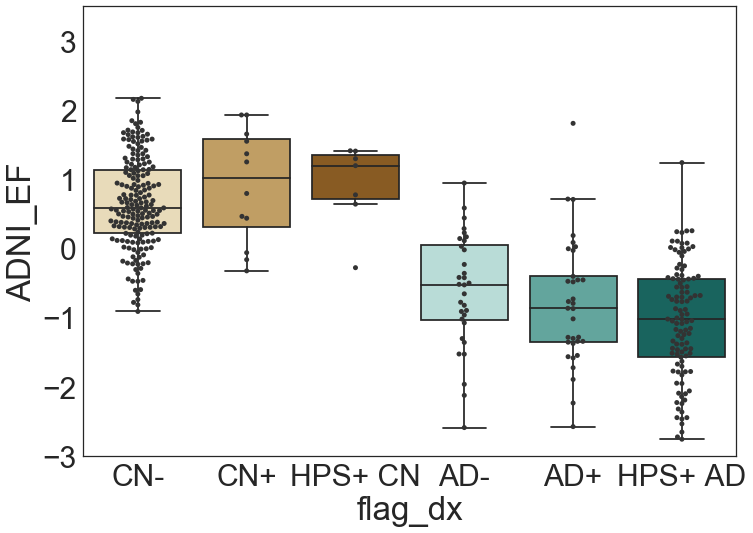

ANOVA F:  87.2391143022
p value:  1.81791355304e-60
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff  lower   upper  reject
-----------------------------------------------
  AD+     AD-    0.1829  -0.3496  0.7155 False 
  AD+     CN+    1.6975   0.9738  2.4211  True 
  AD+     CN-    1.4517   1.0462  1.8572  True 
  AD+   HPS+ AD -0.2509  -0.6784  0.1765 False 
  AD+   HPS+ CN  1.7166   0.8233  2.6099  True 
  AD-     CN+    1.5145   0.7879  2.2412  True 
  AD-     CN-    1.2687   0.8579  1.6796  True 
  AD-   HPS+ AD -0.4339  -0.8664 -0.0014  True 
  AD-   HPS+ CN  1.5336   0.6379  2.4294  True 
  CN+     CN-   -0.2458  -0.8852  0.3936 False 
  CN+   HPS+ AD -1.9484  -2.6019 -1.2949  True 
  CN+   HPS+ CN  0.0191  -1.0018   1.04  False 
  CN-   HPS+ AD -1.7026  -1.9631 -1.4422  True 
  CN-   HPS+ CN  0.2649  -0.5616  1.0914 False 
HPS+ AD HPS+ CN  1.9675    1.13   2.805   True 
-----------------------------------------------


In [57]:
anova_hpc_split(df1, 'ADNI_EF', -3, 3.5, 'CN','AD',path_results + 'adni1_adcn_ef_split.pdf')

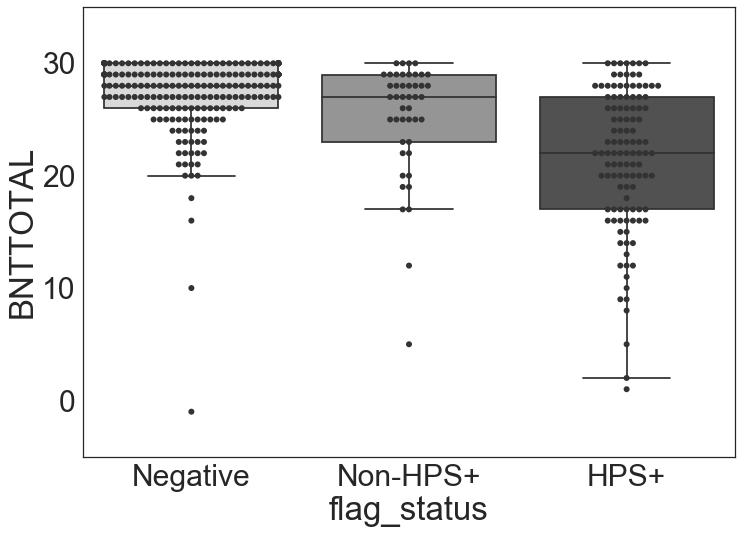

ANOVA F:  58.2401907211
p value:  9.89512685721e-23
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative  5.8989   4.6123  7.1855  True 
  HPS+   Non-HPS+  3.682    1.7271  5.637   True 
Negative Non-HPS+ -2.2169  -4.0335 -0.4003  True 
-------------------------------------------------


In [58]:
# language
anova_hpc(df1, 'BNTTOTAL', -5, 35, path_results + 'adni1_adcn_language.pdf')

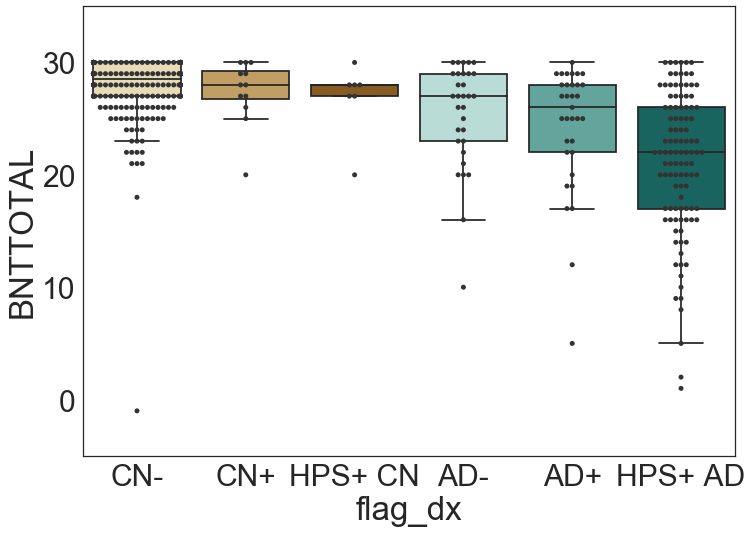

ANOVA F:  28.655750531
p value:  1.4832884655e-24
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff  lower    upper  reject
------------------------------------------------
  AD+     AD-    1.0518  -2.2458   4.3494 False 
  AD+     CN+    3.1136  -1.3306   7.5579 False 
  AD+     CN-    3.3798   0.8895   5.8701  True 
  AD+   HPS+ AD -3.2087  -5.8368  -0.5806  True 
  AD+   HPS+ CN  2.5541   -2.932   8.0402 False 
  AD-     CN+    2.0618  -2.4205   6.5442 False 
  AD-     CN-    2.328   -0.2297   4.8856 False 
  AD-   HPS+ AD -4.2605  -6.9525  -1.5685  True 
  AD-   HPS+ CN  1.5023  -4.0147   7.0193 False 
  CN+     CN-    0.2661  -3.6606   4.1928 False 
  CN+   HPS+ AD -6.3223  -10.3378 -2.3068  True 
  CN+   HPS+ CN -0.5595  -6.8297   5.7106 False 
  CN-   HPS+ AD -6.5885  -8.1929   -4.984  True 
  CN-   HPS+ CN -0.8257  -5.9016   4.2503 False 
HPS+ AD HPS+ CN  5.7628   0.6179  10.9077  True 
------------------------------------------------


In [59]:
anova_hpc_split(df1, 'BNTTOTAL', -5, 35, 'CN','AD',path_results + 'adni1_adcn_language_split.pdf')

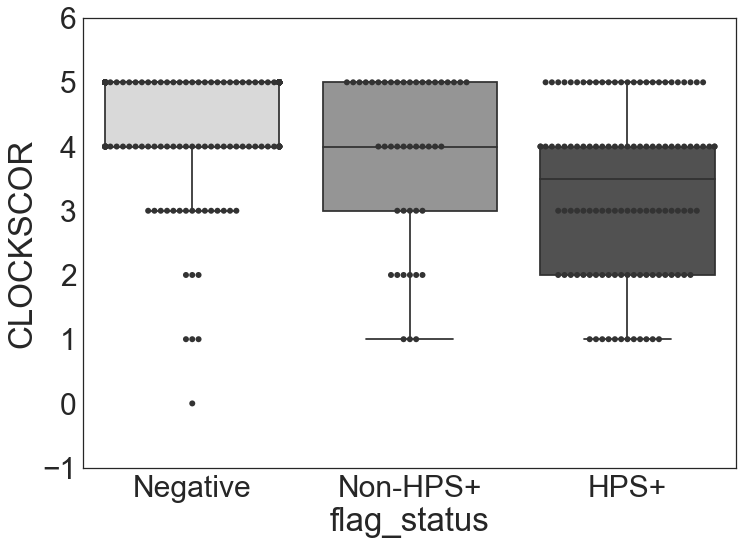

ANOVA F:  48.5590350013
p value:  1.78535295053e-19
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative  1.203    0.9125  1.4934  True 
  HPS+   Non-HPS+  0.5421   0.0997  0.9845  True 
Negative Non-HPS+ -0.6609  -1.0723 -0.2494  True 
-------------------------------------------------


In [60]:
# vis spat
anova_hpc(df1, 'CLOCKSCOR', -1, 6, path_results + 'adni1_adcn_clock.pdf')

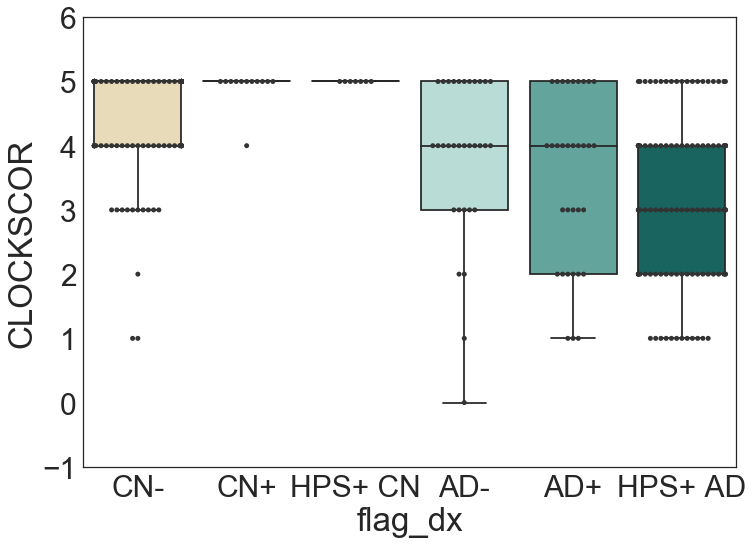

ANOVA F:  33.5429475378
p value:  3.03786164039e-28
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff  lower   upper  reject
-----------------------------------------------
  AD+     AD-    0.3589  -0.3509  1.0687 False 
  AD+     CN+    1.4318   0.4674  2.3962  True 
  AD+     CN-    1.1603   0.6199  1.7007  True 
  AD+   HPS+ AD -0.2699  -0.8395  0.2998 False 
  AD+   HPS+ CN  1.5152   0.3247  2.7056  True 
  AD-     CN+    1.0729   0.1045  2.0413  True 
  AD-     CN-    0.8014   0.2539  1.3489  True 
  AD-   HPS+ AD -0.6288  -1.2052 -0.0524  True 
  AD-   HPS+ CN  1.1562  -0.0375   2.35  False 
  CN+     CN-   -0.2715  -1.1236  0.5806 False 
  CN+   HPS+ AD -1.7017  -2.5727 -0.8308  True 
  CN+   HPS+ CN  0.0833  -1.2773  1.4439 False 
  CN-   HPS+ AD -1.4302  -1.7773 -1.0831  True 
  CN-   HPS+ CN  0.3548  -0.7466  1.4563 False 
HPS+ AD HPS+ CN  1.785    0.6689  2.9012  True 
-----------------------------------------------


In [61]:
anova_hpc_split(df1, 'CLOCKSCOR', -1, 6, 'CN','AD',path_results + 'adni1_adcn_clock_split.pdf')

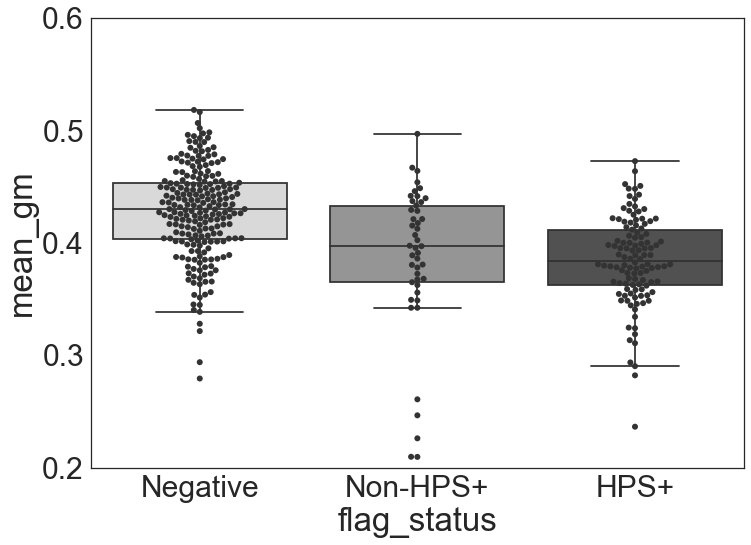

ANOVA F:  38.0324507313
p value:  9.2158922188e-16
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative  0.0422   0.0297  0.0546  True 
  HPS+   Non-HPS+  0.002    -0.017  0.0209 False 
Negative Non-HPS+ -0.0402  -0.0579 -0.0226  True 
-------------------------------------------------


In [62]:
anova_hpc(df1, 'mean_gm', 0.2, 0.6, path_results + 'adni1_adcn_meangm.pdf')

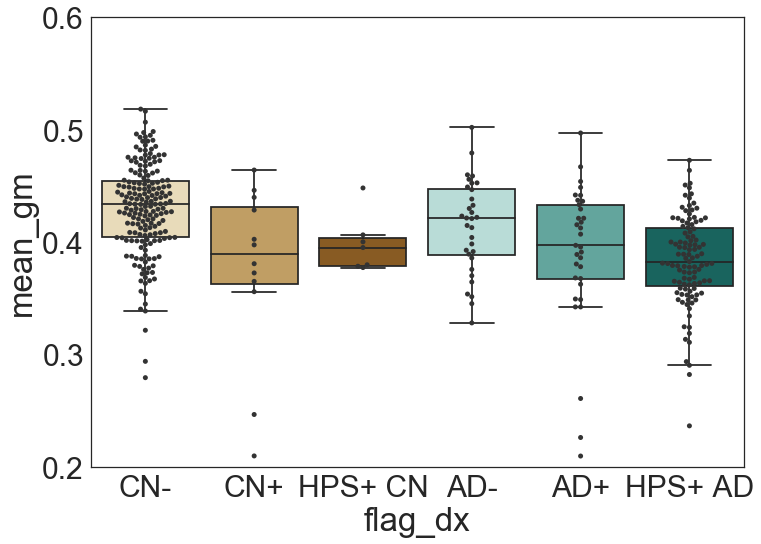

ANOVA F:  16.1366858842
p value:  2.10990154662e-14
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff  lower   upper  reject
-----------------------------------------------
  AD+     AD-    0.0239  -0.0086  0.0563 False 
  AD+     CN+   -0.0144  -0.0586  0.0297 False 
  AD+     CN-    0.0385   0.0138  0.0632  True 
  AD+   HPS+ AD -0.0067  -0.0328  0.0194 False 
  AD+   HPS+ CN  0.0077  -0.0467  0.0622 False 
  AD-     CN+   -0.0383  -0.0826  0.006  False 
  AD-     CN-    0.0147  -0.0104  0.0397 False 
  AD-   HPS+ AD -0.0306   -0.057 -0.0042  True 
  AD-   HPS+ CN -0.0161  -0.0708  0.0385 False 
  CN+     CN-    0.053    0.014   0.092   True 
  CN+   HPS+ AD  0.0077  -0.0321  0.0476 False 
  CN+   HPS+ CN  0.0222  -0.0401  0.0845 False 
  CN-   HPS+ AD -0.0452  -0.0611 -0.0293  True 
  CN-   HPS+ CN -0.0308  -0.0812  0.0196 False 
HPS+ AD HPS+ CN  0.0145  -0.0366  0.0655 False 
-----------------------------------------------


In [63]:
anova_hpc_split(df1, 'mean_gm', 0.2, 0.6, 'CN', 'AD', path_results + 'adni1_adcn_meangm_split.pdf')

# Test on ADNI1 MCI stable vs converters

In [64]:
# load the data
adni1_mci = pd.read_csv('/Users/AngelaTam/Desktop/adsf/adni1_vbm_adcn_subtypes_20171209/7clus/adni1_mci_bl_demog_weights.csv')

In [65]:
mask_mci = adni1_mci.loc[:,'MCI'].values.astype(bool)
adni1_mci = adni1_mci.iloc[mask_mci]

In [66]:
adni1_mci.dropna(subset=['sub1','age_scan','gender','mean_gm','tiv'],inplace=True)

In [67]:
len(adni1_mci)

238

In [68]:
x_ = adni1_mci.iloc[:,adni1_mci.columns.get_loc("sub1"):adni1_mci.columns.get_loc("sub7")+1].values
#x_ = scalerX.transform(x_)
y_ = adni1_mci['conv_2_ad'].values.ravel()


confounds = adni1_mci[['gender','age_scan','mean_gm','tiv']].values
#confounds = data[['sex','age_r']].values[mask_mci,:]
#confounds[:, 1:] = scaler.transform(confounds[:, 1:])
#confounds[:, 0] = preprocessing.binarize(confounds[:, 0].reshape(-1, 1), threshold=1)[:, 0]
#confounds = scaler.transform(confounds)
#x_ = crm.transform(confounds, x_)

x_ = scaler.transform(np.hstack((x_,confounds)))

x_.shape, y_.shape, confounds.shape

((238, 11), (238,), (238, 4))

In [69]:
array_results, dic_results = hpc.predict(x_, x_)

# Level 1
print('Level 1')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float))

print('Level 2')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float), dic_results['s2df'][:,1]>0)
#stats_mask(dic_results['s2df'][:,2]>0)
#stats_mask(dic_results['s2df'][:,3]>0)

Level 1
------------------------
Ratio: 1.0
#    :  149.0
# true values:  238
ACC  :  0.689075630252
Level 2
------------------------
Ratio: 0.429530201342
#    :  64.0
# true values:  73
ACC  :  0.876712328767


In [70]:
y_pred = (dic_results['s1df'][:,0]>0).astype(float)
lr_decision = dic_results['s2df'][:,1]

In [71]:
predic_stats(y_, y_pred, lr_decision)

Total number of TARGET subjects:  149.0
Total number of NON-TARGET subjects:  89.0
Stage 1 number of hits (true and false positives):  123.0
Stage 1 TRUE positives:  99.0
Stage 1 FALSE positives:  24.0
Stage 1 TRUE negatives:  65.0
Total number of flagged HPC-AD subjects:  73.0
Number of flagged HPC-AD subjects that are TRUE positives:  64.0
Number of flagged HPC-AD subjects that are FALSE positives:  9.0
Number of true negatives:  80.0
#############################
Stage 1 stats for TARGET vs NON-TARGET
Precision for AD:  0.80487804878
Recall (or sensitivity)  for AD:  0.664429530201
Specificity:  0.730337078652
Adjusted precision for 33.6% baseline rate:  0.554923748257
Accuracy:  0.689075630252
#############################
Stage 2 stats for TARGET vs NON-TARGET
Precision for HPC-AD:  0.876712328767
Recall (or sensitivity) for HPC-AD:  0.429530201342
Specificity:  0.898876404494
Adjusted precision for 33.6% baseline rate:  0.682476785485
Accuracy:  0.605042016807


(0.66442953020134232,
 0.7303370786516854,
 0.80487804878048785,
 0.68907563025210083,
 0.42953020134228187,
 0.898876404494382,
 0.87671232876712324,
 0.60504201680672265)

### characteristics of HPC-AD people in ADNI1 MCI

In [72]:
# make copy of dataframe
df2 = deepcopy(adni1_mci)

In [73]:
hpc_df(df2, y_pred, lr_decision)

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


## cognitive decline 

In [74]:
long_df_adni1_mci = pd.merge(long_data, df2[['RID','flag_status','f_s1_only','f_hpc','f_s1']], how='left', on=['RID'])
long_df_adni1_mci.dropna(subset=['flag_status'],inplace=True)
long_df_adni1_mci.drop(long_df_adni1_mci[long_df_adni1_mci.Month==30].index, inplace=True)
long_df_adni1_mci.reset_index(inplace=True, drop=True)

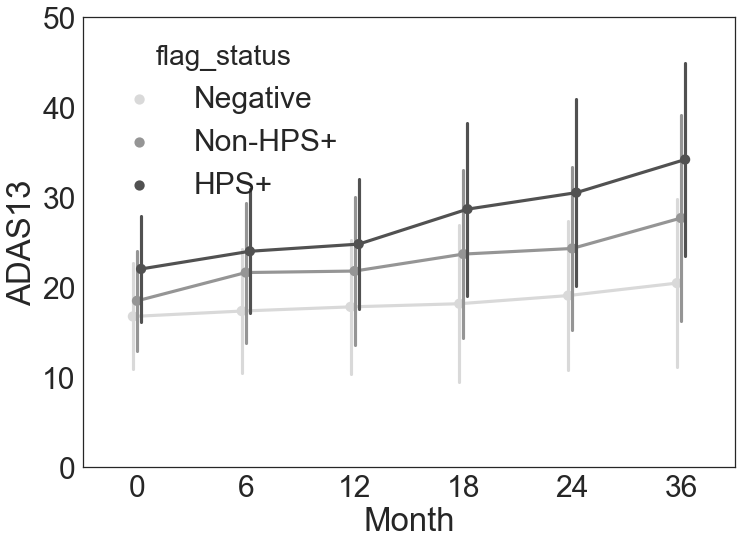

In [75]:
plt.close()
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.pointplot(x="Month", y="ADAS13", hue="flag_status", data=long_df_adni1_mci.dropna(subset=['ADAS13']), 
                dodge=True, palette="Greys", ci="sd")
plt.ylim(0, 50)
plt.show()
#fig.savefig(path_results + 'adni1_mci_adas13_long.pdf',bbox_inches='tight')

In [76]:
# save dataframe
adni1_mci_adas = long_df_adni1_mci[['RID','f_s1_only','f_hpc','Month','ADAS13']]
adni1_mci_adas.to_csv('/Users/AngelaTam/Desktop/adsf/adni1_vbm_adcn_subtypes_20171209/7clus/adni1_mci_adas.csv',
                     index=False)

## % of progressors 

observed freq: 
[[ 89  24   9]
 [155 102  65]]
Chi2:  23.1170383113
p value:  9.55430083485e-06
degress of freedom:  2
expected freq: 
[[  67.04504505   34.62162162   20.33333333]
 [ 176.95495495   91.37837838   53.66666667]]


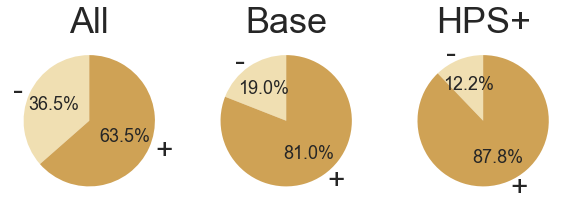

In [77]:
tmp_data = {'conv_2_ad': ['-','+'],
           'All': [89, 155],
           'Base': [24, 102],
           'HPS+': [9, 65]} 
tmp_df = pd.DataFrame(tmp_data, columns={'conv_2_ad', 'All', 'Base', 'HPS+'})

obs = tmp_df.as_matrix(columns=['All', 'Base', 'HPS+'])
chi2, p, dof, exf = scipy.stats.chi2_contingency(obs)
print('observed freq: ')
print(obs)
print('Chi2: ', chi2)
print('p value: ', p)
print('degress of freedom: ', dof)
print('expected freq: ')
print(exf)

plt.close()
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,6))
ax1.pie(tmp_df['All'], labels=tmp_df['conv_2_ad'],autopct='%1.1f%%',startangle=90)
ax1.set_title('All')
ax1.set(adjustable='box-forced', aspect='equal')
ax2.pie(tmp_df['Base'], labels=tmp_df['conv_2_ad'],autopct='%1.1f%%',startangle=90)
ax2.set_title('Base')
ax2.set(adjustable='box-forced', aspect='equal')
ax3.pie(tmp_df['HPS+'], labels=tmp_df['conv_2_ad'],autopct='%1.1f%%',startangle=90)
ax3.set_title('HPS+')
ax3.set(adjustable='box-forced', aspect='equal')
plt.show()

In [78]:
# post hoc pair-wise tests
obs = tmp_df.as_matrix(columns=['Base', 'HPS+'])
chi2, p, dof, exf = scipy.stats.chi2_contingency(obs)
print('observed freq: ')
print(obs)
print('Chi2: ', chi2)
print('p value: ', p)
print('degress of freedom: ', dof)
print('expected freq: ')
print(exf)

# post hoc pair-wise tests
obs = tmp_df.as_matrix(columns=['All', 'HPS+'])
chi2, p, dof, exf = scipy.stats.chi2_contingency(obs)
print('observed freq: ')
print(obs)
print('Chi2: ', chi2)
print('p value: ', p)
print('degress of freedom: ', dof)
print('expected freq: ')
print(exf)

observed freq: 
[[ 24   9]
 [102  65]]
Chi2:  1.14339395777
p value:  0.284936307791
degress of freedom:  1
expected freq: 
[[  20.79   12.21]
 [ 105.21   61.79]]
observed freq: 
[[ 89   9]
 [155  65]]
Chi2:  14.6232150923
p value:  0.000131287257445
degress of freedom:  1
expected freq: 
[[  75.19496855   22.80503145]
 [ 168.80503145   51.19496855]]


In [79]:
tmp_df = chi2_fn(df2, 'conv_2_ad')

observed freq: 
[[ 65.  15.   9.]
 [ 50.  35.  64.]]
Chi2:  38.7303269732
p value:  3.88880670272e-09
degress of freedom:  2
expected freq: 
[[ 43.00420168  18.69747899  27.29831933]
 [ 71.99579832  31.30252101  45.70168067]]


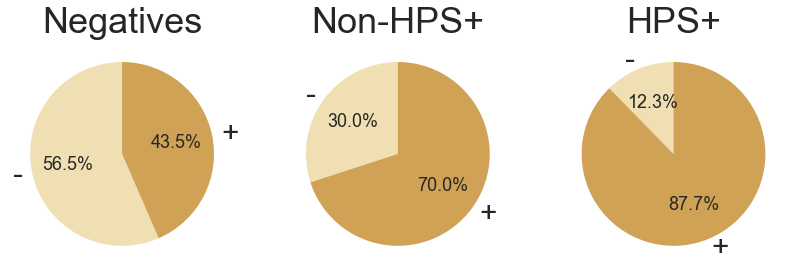

In [80]:
hpc_pie(tmp_df, 'conv_2_ad', path_results + 'adni1_mci_hpc_progression_pie.pdf')

In [81]:
# post hoc pair-wise tests
obs = tmp_df.as_matrix(columns=['Non-HPS+', 'HPS+'])
chi2, p, dof, exf = scipy.stats.chi2_contingency(obs)
print('observed freq: ')
print(obs)
print('Chi2: ', chi2)
print('p value: ', p)
print('degress of freedom: ', dof)
print('expected freq: ')
print(exf)

# post hoc pair-wise tests
obs = tmp_df.as_matrix(columns=['Negative', 'HPS+'])
chi2, p, dof, exf = scipy.stats.chi2_contingency(obs)
print('observed freq: ')
print(obs)
print('Chi2: ', chi2)
print('p value: ', p)
print('degress of freedom: ', dof)
print('expected freq: ')
print(exf)

observed freq: 
[[ 15.   9.]
 [ 35.  64.]]
Chi2:  4.82889243462
p value:  0.0279866040076
degress of freedom:  1
expected freq: 
[[  9.75609756  14.24390244]
 [ 40.24390244  58.75609756]]
observed freq: 
[[ 65.   9.]
 [ 50.  64.]]
Chi2:  34.7102243964
p value:  3.82616784848e-09
degress of freedom:  1
expected freq: 
[[ 45.26595745  28.73404255]
 [ 69.73404255  44.26595745]]


## time to progression

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


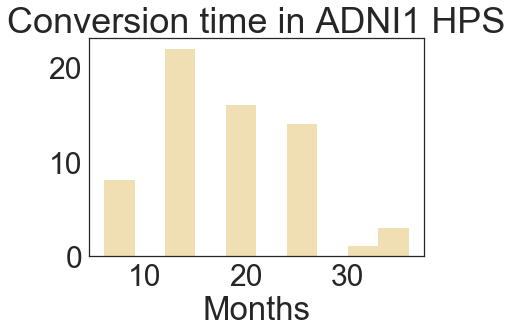

In [82]:
plt.hist(df2.dropna(subset=['Month_conv'])[df2.f_hpc==1]['Month_conv'].values)
plt.xlabel('Months')
plt.title('Conversion time in ADNI1 HPS')
plt.show()

In [83]:
df2.to_csv('/Users/AngelaTam/Desktop/adsf/adni1_vbm_adcn_subtypes_20171209/7clus/adni1_mci_hps_bl.csv')

## APOE4 positivity in ADNI1 MCI 

In [84]:
compare_ratio_var(df2, 'APOE4_bin', 'conv_2_ad')

baseline rate in NON-TARGET subjects:  0.3707865168539326
##########
baseline rate in TARGET subjects:  0.6912751677852349
##########
number of subjects with VOI in the whole sample:  136.0
total number of subjects with VOI data in whole sample:  238
ratio:  0.5714285714285714
##########
number of subjects with VOI that are positive at stage 1:  76.0
total number of positive stage 1 subjects with VOI data:  123
ratio:  0.6178861788617886
##########
number of subjects with VOI in HPC-AD:  47.0
total number of HPC-AD subjects with VOI data:  73
ratio:  0.6438356164383562
##########
number of subjects with VOI in Non-HPC+:  29.0
total number of Non-HPC+ with VOI data:  50
ratio:  0.58
##########
number of subjects with VOI in negative subjects:  60.0
total number of negative subjects with VOI data 115
ratio:  0.5217391304347826


In [85]:
tmp_df = chi2_fn(df2, 'APOE4_bin')

observed freq: 
[[ 55.  21.  26.]
 [ 60.  29.  47.]]
Chi2:  2.73720567798
p value:  0.25446223602
degress of freedom:  2
expected freq: 
[[ 49.28571429  21.42857143  31.28571429]
 [ 65.71428571  28.57142857  41.71428571]]


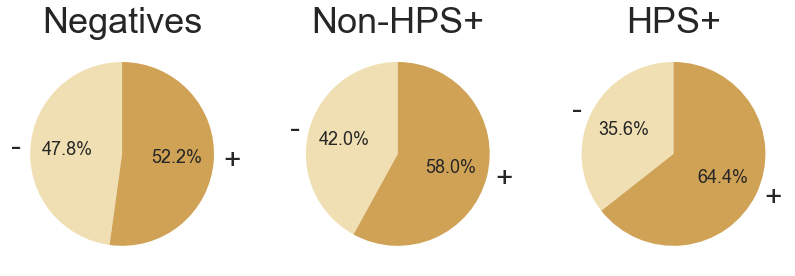

In [86]:
hpc_pie(tmp_df, 'APOE4_bin', path_results + 'adni1_mci_hpc_e4_pie.pdf')

## sex (% male) in ADNI1 MCI

In [87]:
compare_ratio_var(df2, 'gender', 'conv_2_ad')

baseline rate in NON-TARGET subjects:  0.5955056179775281
##########
baseline rate in TARGET subjects:  0.5906040268456376
##########
number of subjects with VOI in the whole sample:  141.0
total number of subjects with VOI data in whole sample:  238
ratio:  0.592436974789916
##########
number of subjects with VOI that are positive at stage 1:  75.0
total number of positive stage 1 subjects with VOI data:  123
ratio:  0.6097560975609756
##########
number of subjects with VOI in HPC-AD:  46.0
total number of HPC-AD subjects with VOI data:  73
ratio:  0.6301369863013698
##########
number of subjects with VOI in Non-HPC+:  29.0
total number of Non-HPC+ with VOI data:  50
ratio:  0.58
##########
number of subjects with VOI in negative subjects:  66.0
total number of negative subjects with VOI data 115
ratio:  0.5739130434782609


In [88]:
chi2_fn(df2, 'gender')

observed freq: 
[[ 49.  21.  27.]
 [ 66.  29.  46.]]
Chi2:  0.625162205906
p value:  0.731556295165
degress of freedom:  2
expected freq: 
[[ 46.8697479   20.37815126  29.75210084]
 [ 68.1302521   29.62184874  43.24789916]]


Negative  Non-HPS+  HPS+ gender
0      49.0      21.0  27.0      -
1      66.0      29.0  46.0      +

## CSF tau in ADNI1 MCI 

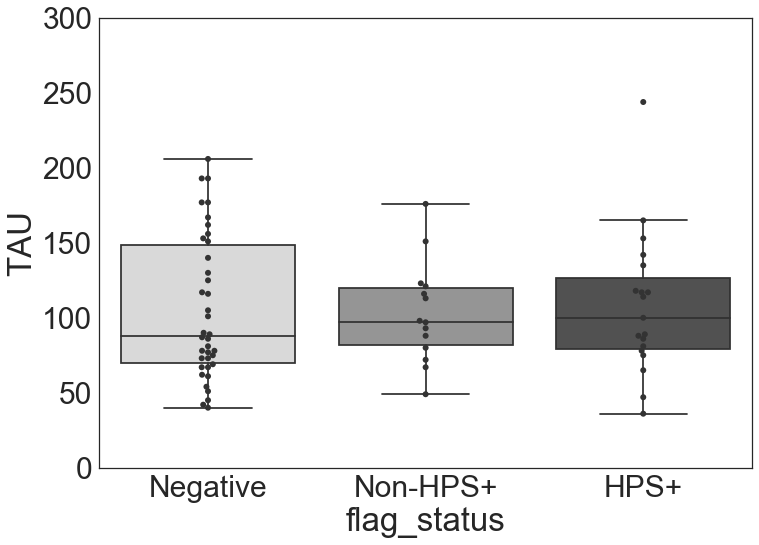

ANOVA F:  0.0443551674507
p value:  0.956641792107
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower    upper  reject
--------------------------------------------------
  HPS+   Negative -2.2632  -32.8488 28.3225 False 
  HPS+   Non-HPS+ -4.7519  -43.093  33.5892 False 
Negative Non-HPS+ -2.4887  -36.5213 31.5438 False 
--------------------------------------------------


In [89]:
anova_hpc(df2, 'TAU', 0, 300, path_results+'adni1_mci_csf_tau.pdf')

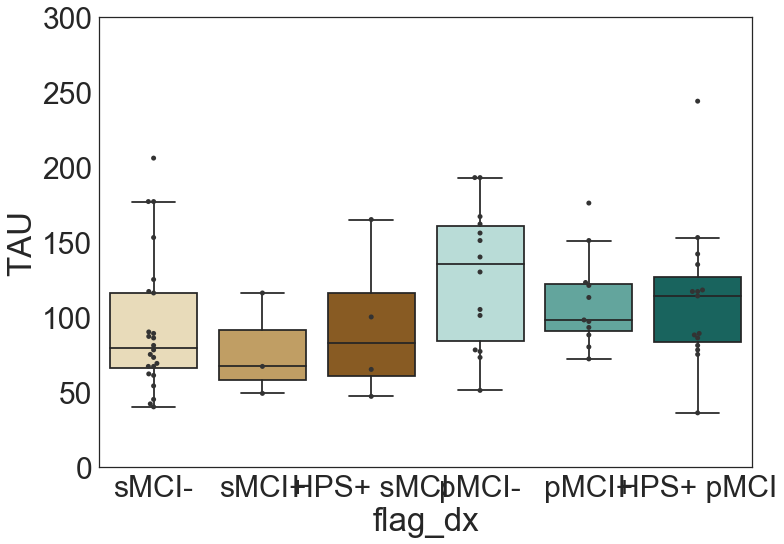

ANOVA F:  1.40694748877
p value:  0.233519604412
  Multiple Comparison of Means - Tukey HSD,FWER=0.05  
  group1    group2  meandiff   lower    upper   reject
------------------------------------------------------
HPS+ pMCI HPS+ sMCI -17.2833  -90.2658 55.6992  False 
HPS+ pMCI   pMCI+   -1.3515   -52.8343 50.1313  False 
HPS+ pMCI   pMCI-   15.3952   -32.8003 63.5908  False 
HPS+ pMCI   sMCI+    -34.2   -116.2253 47.8253  False 
HPS+ pMCI   sMCI-   -18.325   -61.0123 24.3623  False 
HPS+ sMCI   pMCI+   15.9318   -59.7928 91.6564  False 
HPS+ sMCI   pMCI-   32.6786   -40.8506 106.2078 False 
HPS+ sMCI   sMCI+   -16.9167 -115.9716 82.1382  False 
HPS+ sMCI   sMCI-   -1.0417   -71.0841 69.0007  False 
  pMCI+     pMCI-   16.7468   -35.5082 69.0017  False 
  pMCI+     sMCI+   -32.8485 -117.3228 51.6258  False 
  pMCI+     sMCI-   -16.9735  -64.1961 30.2491  False 
  pMCI-     sMCI+   -49.5952 -132.1073 32.9168  False 
  pMCI-     sMCI-   -33.7202  -77.3356  9.8952  False 
  sMCI+     sMCI

In [90]:
anova_hpc_split(df2, 'TAU', 0, 300, 'sMCI', 'pMCI', path_results + 'adni1_mci_csf_tau_split.pdf')

## CSF abeta in ADNI1 MCI 

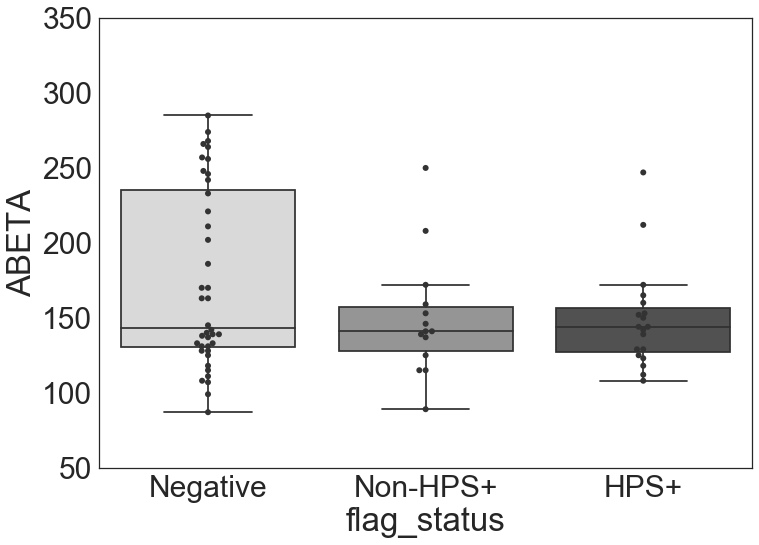

ANOVA F:  2.19401006694
p value:  0.119076593608
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower    upper  reject
--------------------------------------------------
  HPS+   Negative 25.3434  -8.6103  59.2972 False 
  HPS+   Non-HPS+  0.6541  -42.2684 43.5766 False 
Negative Non-HPS+ -24.6893 -62.5311 13.1525 False 
--------------------------------------------------


In [91]:
anova_hpc(df2, 'ABETA', 50, 350, path_results + 'adni1_mci_csf_abeta.pdf')

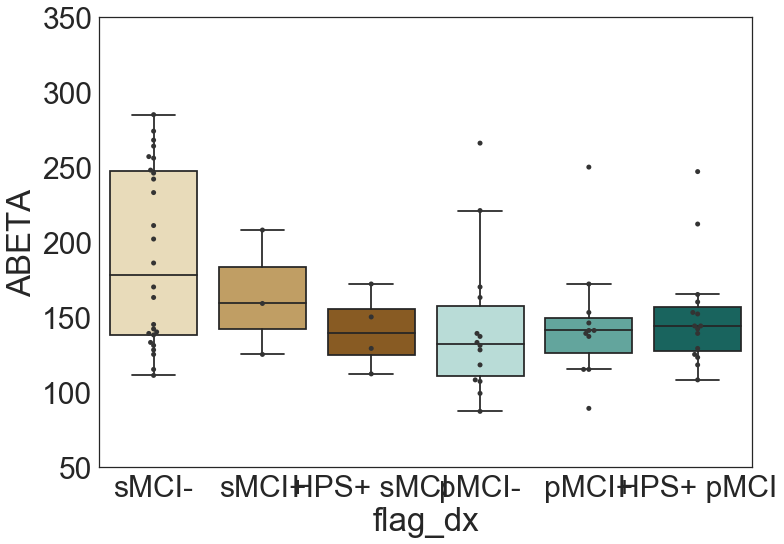

ANOVA F:  2.73908302426
p value:  0.0260077473939
  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
  group1    group2  meandiff  lower    upper   reject
-----------------------------------------------------
HPS+ pMCI HPS+ sMCI -9.9833  -90.6481 70.6815  False 
HPS+ pMCI   pMCI+   -5.4606  -62.3626 51.4414  False 
HPS+ pMCI   pMCI-   -7.3762  -60.6449 45.8925  False 
HPS+ pMCI   sMCI+   13.2667  -77.3927 103.9261 False 
HPS+ pMCI   sMCI-   39.7282  -6.7493  86.2057  False 
HPS+ sMCI   pMCI+    4.5227  -79.1728 88.2182  False 
HPS+ sMCI   pMCI-    2.6071  -78.6619 83.8762  False 
HPS+ sMCI   sMCI+    23.25   -86.2316 132.7316 False 
HPS+ sMCI   sMCI-   49.7115  -27.2771 126.7002 False 
  pMCI+     pMCI-   -1.9156  -59.671  55.8398  False 
  pMCI+     sMCI+   18.7273  -74.639  112.0935 False 
  pMCI+     sMCI-   45.1888  -6.3697  96.7474  False 
  pMCI-     sMCI+   20.6429  -70.5546 111.8403 False 
  pMCI-     sMCI-   47.1044   -0.414  94.6228  False 
  sMCI+     sMCI-   26.4615  -60

In [92]:
anova_hpc_split(df2, 'ABETA', 50, 350, 'sMCI', 'pMCI', path_results + 'adni1_mci_csf_abeta_split.pdf')

## age in ADNI1 MCI 

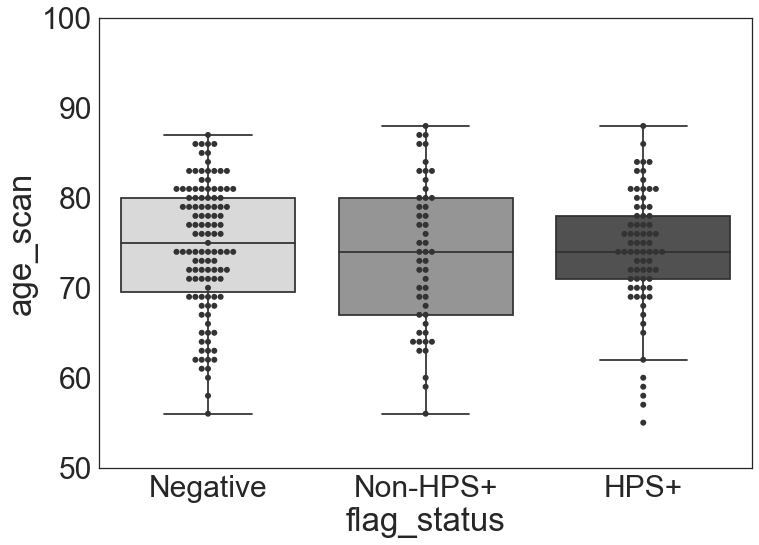

ANOVA F:  0.274943033153
p value:  0.759859402994
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative  0.4783  -2.0921 3.0486 False 
  HPS+   Non-HPS+   -0.4   -3.5531 2.7531 False 
Negative Non-HPS+ -0.8783  -3.7879 2.0314 False 
------------------------------------------------


In [93]:
anova_hpc(df2, 'age_scan', 50, 100, path_results + 'adni1_mci_age.pdf')

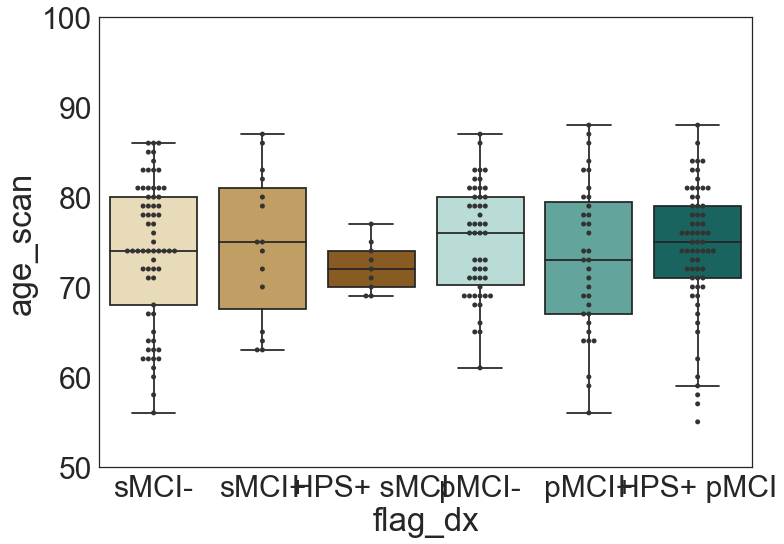

ANOVA F:  0.405411262639
p value:  0.84480306886
 Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower   upper  reject
---------------------------------------------------
HPS+ pMCI HPS+ sMCI -2.0278  -9.5015  5.4459 False 
HPS+ pMCI   pMCI+    -1.05   -5.4634  3.3634 False 
HPS+ pMCI   pMCI-     0.79   -3.1724  4.7524 False 
HPS+ pMCI   sMCI+    0.2833   -5.739  6.3056 False 
HPS+ pMCI   sMCI-   -0.2038  -3.9007  3.493  False 
HPS+ sMCI   pMCI+    0.9778  -6.8684  8.8239 False 
HPS+ sMCI   pMCI-    2.8178  -4.7838 10.4194 False 
HPS+ sMCI   sMCI+    2.3111  -6.5405 11.1627 False 
HPS+ sMCI   sMCI-    1.8239  -5.6427  9.2905 False 
  pMCI+     pMCI-     1.84   -2.7867  6.4667 False 
  pMCI+     sMCI+    1.3333  -5.1454  7.8121 False 
  pMCI+     sMCI-    0.8462  -3.5553  5.2476 False 
  pMCI-     sMCI+   -0.5067   -6.687  5.6736 False 
  pMCI-     sMCI-   -0.9938  -4.9429  2.9552 False 
  sMCI+     sMCI-   -0.4872  -6.5007  5.5263 False 
---------------

In [94]:
anova_hpc_split(df2, 'age_scan', 50, 100, 'sMCI', 'pMCI', path_results + 'adni1_mci_age_split.pdf')

## cognition in ADNI1 MCI

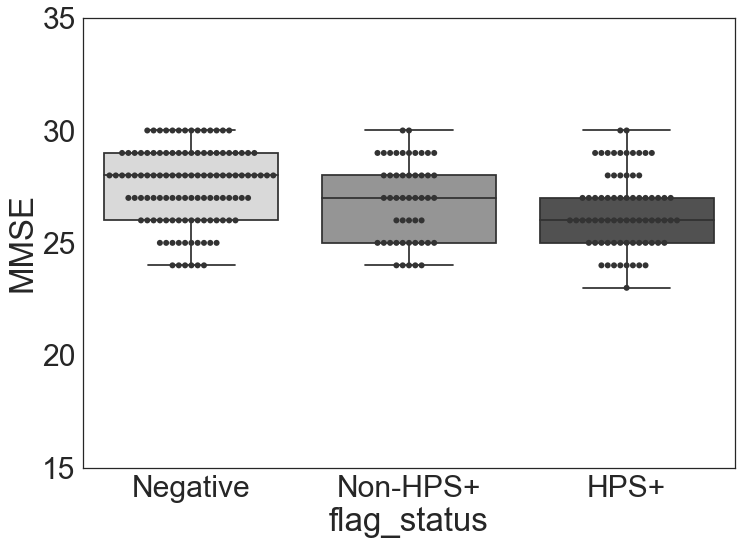

ANOVA F:  8.99732477133
p value:  0.000171748031033
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative  1.061    0.4617 1.6603  True 
  HPS+   Non-HPS+  0.4479  -0.2872 1.1831 False 
Negative Non-HPS+  -0.613  -1.2914 0.0653 False 
------------------------------------------------


In [95]:
# mmse
anova_hpc(df2, 'MMSE', 15, 35, path_results + 'adni1_mci_mmse.pdf')

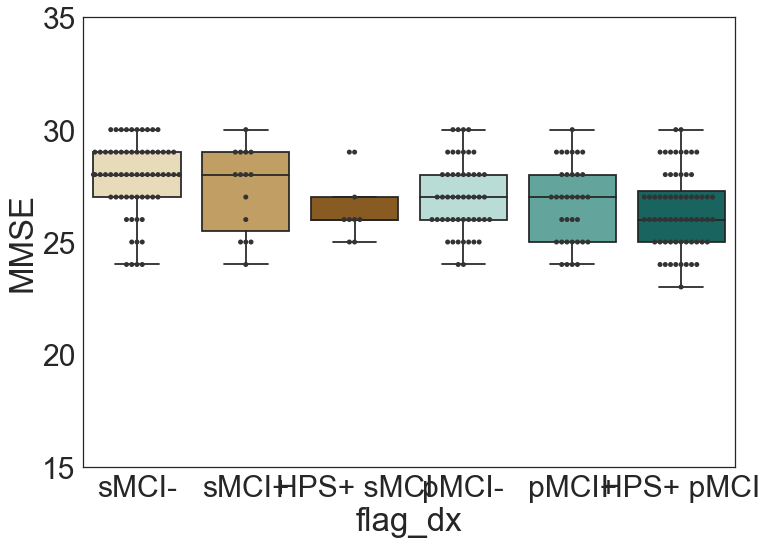

ANOVA F:  5.51822724446
p value:  8.02877942989e-05
Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower  upper  reject
--------------------------------------------------
HPS+ pMCI HPS+ sMCI  0.1181  -1.5965 1.8326 False 
HPS+ pMCI   pMCI+    0.2768  -0.7357 1.2893 False 
HPS+ pMCI   pMCI-    0.5825  -0.3266 1.4916 False 
HPS+ pMCI   sMCI+    0.8958  -0.4858 2.2775 False 
HPS+ pMCI   sMCI-    1.4548   0.6067 2.3029  True 
HPS+ sMCI   pMCI+    0.1587  -1.6413 1.9588 False 
HPS+ sMCI   pMCI-    0.4644  -1.2795 2.2084 False 
HPS+ sMCI   sMCI+    0.7778  -1.2529 2.8085 False 
HPS+ sMCI   sMCI-    1.3368  -0.3762 3.0497 False 
  pMCI+     pMCI-    0.3057  -0.7557 1.3672 False 
  pMCI+     sMCI+    0.619   -0.8673 2.1054 False 
  pMCI+     sMCI-    1.178    0.1683 2.1878  True 
  pMCI-     sMCI+    0.3133  -1.1045 1.7312 False 
  pMCI-     sMCI-    0.8723  -0.0337 1.7783 False 
  sMCI+     sMCI-    0.559   -0.8206 1.9386 False 
------------------------------

In [96]:
anova_hpc_split(df2, 'MMSE', 15, 35, 'sMCI', 'pMCI', path_results + 'adni1_mci_mmse_split.pdf')

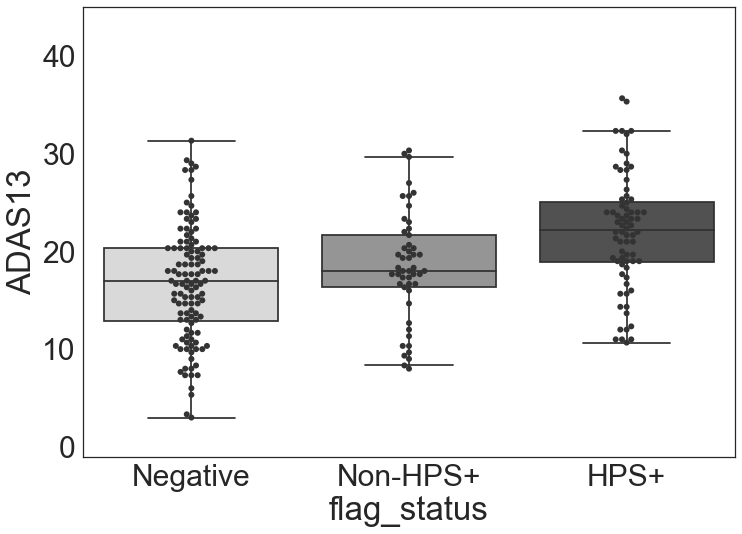

ANOVA F:  17.9279748089
p value:  5.72697634377e-08
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative -5.2827  -7.3667 -3.1987  True 
  HPS+   Non-HPS+ -3.5485  -6.1167 -0.9803  True 
Negative Non-HPS+  1.7342  -0.6316   4.1   False 
-------------------------------------------------


In [97]:
# adas cog
anova_hpc(df2, 'ADAS13', -1, 45, path_results + 'adni1_mci_adas13.pdf')

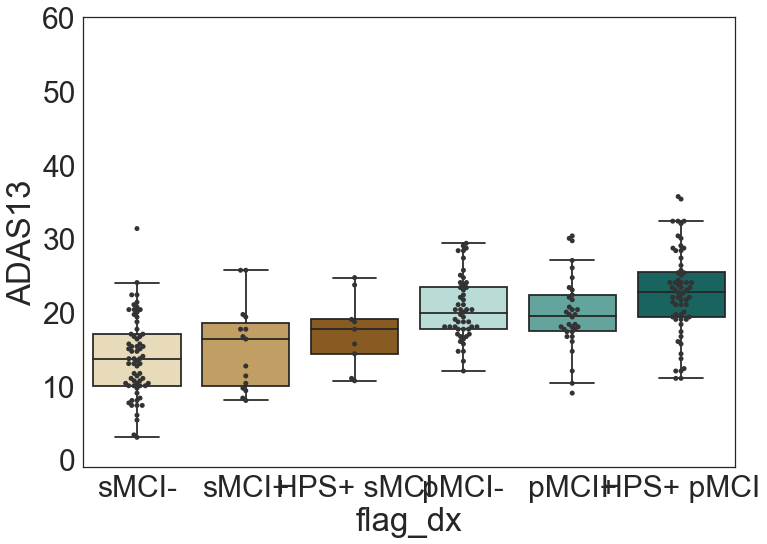

ANOVA F:  21.358190808
p value:  1.55060781973e-17
 Multiple Comparison of Means - Tukey HSD,FWER=0.05 
  group1    group2  meandiff  lower    upper  reject
----------------------------------------------------
HPS+ pMCI HPS+ sMCI  -5.421   -10.8   -0.0419  True 
HPS+ pMCI   pMCI+   -2.7997   -6.012   0.4125 False 
HPS+ pMCI   pMCI-   -2.2019  -5.0609   0.6572 False 
HPS+ pMCI   sMCI+   -7.4594  -11.7961 -3.1226  True 
HPS+ pMCI   sMCI-   -8.8514  -11.5202 -6.1827  True 
HPS+ sMCI   pMCI+    2.6212  -3.0373   8.2798 False 
HPS+ sMCI   pMCI-    3.2191  -2.2467   8.6849 False 
HPS+ sMCI   sMCI+   -2.0384  -8.4031   4.3262 False 
HPS+ sMCI   sMCI-   -3.4305  -8.7992   1.9382 False 
  pMCI+     pMCI-    0.5978  -2.7576   3.9533 False 
  pMCI+     sMCI+   -4.6597  -9.3386   0.0192 False 
  pMCI+     sMCI-   -6.0517  -9.2466  -2.8569  True 
  pMCI-     sMCI+   -5.2575  -9.7014  -0.8137  True 
  pMCI-     sMCI-   -6.6496  -9.4891  -3.8101  True 
  sMCI+     sMCI-   -1.3921   -5.716   2.9318 Fa

In [98]:
anova_hpc_split(df2, 'ADAS13', -1, 60, 'sMCI', 'pMCI', path_results + 'adni1_mci_adas13_split.pdf')

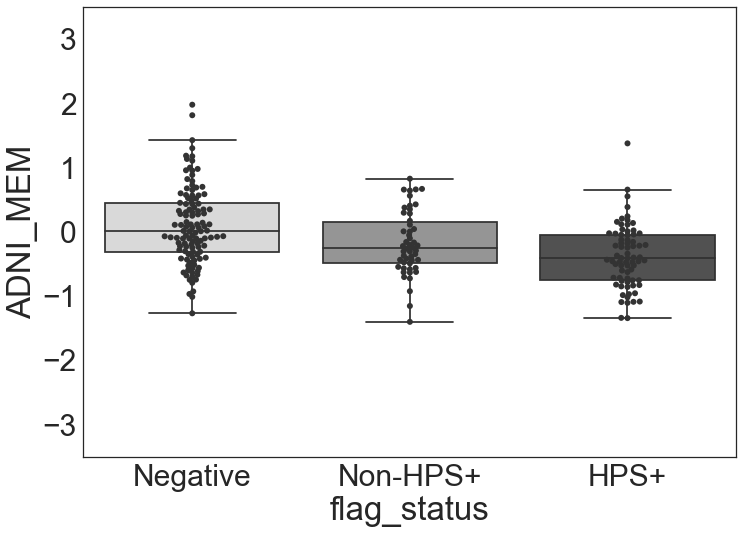

ANOVA F:  17.8900521336
p value:  5.86145666723e-08
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative  0.4797   0.2877  0.6717  True 
  HPS+   Non-HPS+  0.2053  -0.0302  0.4407 False 
Negative Non-HPS+ -0.2744  -0.4917 -0.0571  True 
-------------------------------------------------


In [99]:
# adni memory
anova_hpc(df2, 'ADNI_MEM', -3.5, 3.5, path_results + 'adni1_mci_memory.pdf')

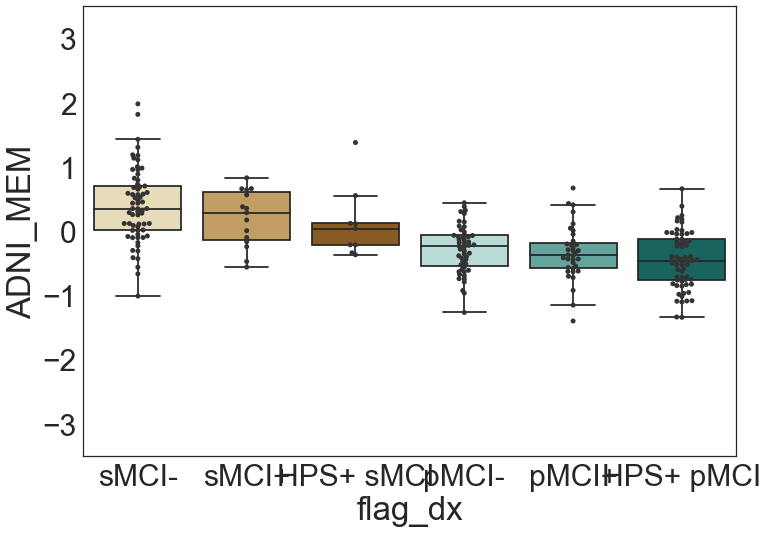

ANOVA F:  26.794183911
p value:  2.3538841126e-21
Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower  upper  reject
--------------------------------------------------
HPS+ pMCI HPS+ sMCI  0.5707   0.0921 1.0492  True 
HPS+ pMCI   pMCI+    0.1141  -0.1686 0.3967 False 
HPS+ pMCI   pMCI-    0.1649  -0.0888 0.4187 False 
HPS+ pMCI   sMCI+    0.6526   0.267  1.0382  True 
HPS+ pMCI   sMCI-    0.8463   0.6096 1.083   True 
HPS+ sMCI   pMCI+   -0.4566   -0.959 0.0458 False 
HPS+ sMCI   pMCI-   -0.4057  -0.8925 0.081  False 
HPS+ sMCI   sMCI+    0.0819  -0.4849 0.6487 False 
HPS+ sMCI   sMCI-    0.2756  -0.2025 0.7537 False 
  pMCI+     pMCI-    0.0509  -0.2454 0.3471 False 
  pMCI+     sMCI+    0.5385   0.1237 0.9534  True 
  pMCI+     sMCI-    0.7322   0.4504 1.0141  True 
  pMCI-     sMCI+    0.4877   0.0919 0.8834  True 
  pMCI-     sMCI-    0.6814   0.4285 0.9342  True 
  sMCI+     sMCI-    0.1937  -0.1914 0.5788 False 
--------------------------------

In [100]:
anova_hpc_split(df2, 'ADNI_MEM',  -3.5, 3.5, 'sMCI', 'pMCI', path_results + 'adni1_mci_memory_split.pdf')

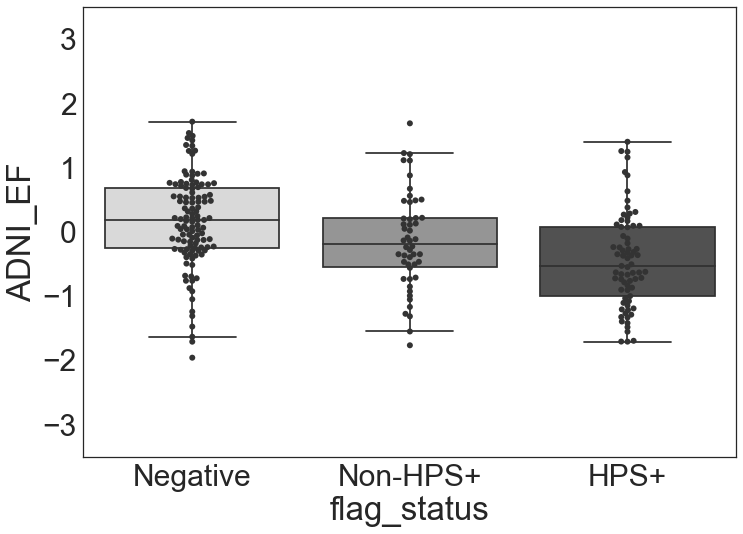

ANOVA F:  15.553495732
p value:  4.53273502831e-07
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative  0.6054   0.348   0.8627  True 
  HPS+   Non-HPS+  0.3055  -0.0102  0.6211 False 
Negative Non-HPS+ -0.2999  -0.5912 -0.0086  True 
-------------------------------------------------


In [101]:
# adni executive function
anova_hpc(df2, 'ADNI_EF', -3.5, 3.5, path_results + 'adni1_mci_ef.pdf')

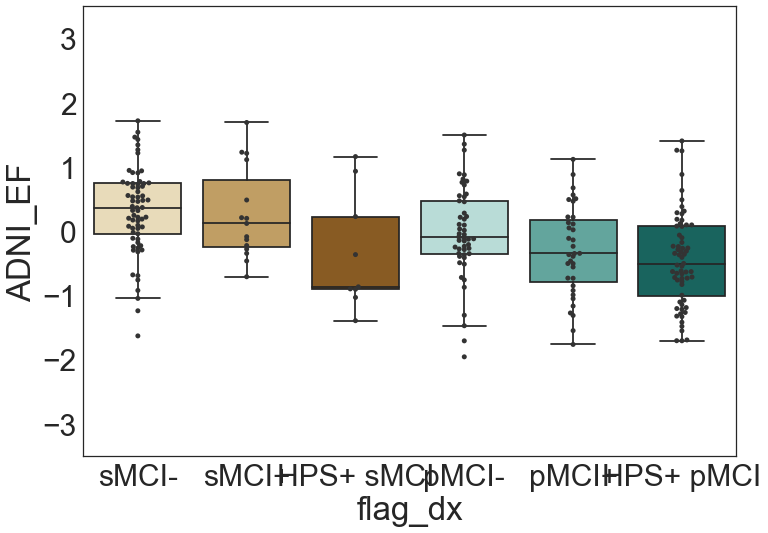

ANOVA F:  9.15526177017
p value:  5.7717664894e-08
Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower  upper  reject
--------------------------------------------------
HPS+ pMCI HPS+ sMCI  0.1065  -0.6234 0.8364 False 
HPS+ pMCI   pMCI+    0.1451  -0.2859 0.5762 False 
HPS+ pMCI   pMCI-    0.4291   0.0421 0.8161  True 
HPS+ pMCI   sMCI+    0.7234   0.1352 1.3115  True 
HPS+ pMCI   sMCI-    0.7642   0.4031 1.1252  True 
HPS+ sMCI   pMCI+    0.0386  -0.7277 0.8049 False 
HPS+ sMCI   pMCI-    0.3226  -0.4198 1.065  False 
HPS+ sMCI   sMCI+    0.6169  -0.2476 1.4814 False 
HPS+ sMCI   sMCI-    0.6577  -0.0716 1.3869 False 
  pMCI+     pMCI-    0.284   -0.1679 0.7358 False 
  pMCI+     sMCI+    0.5782  -0.0545 1.211  False 
  pMCI+     sMCI-    0.619    0.1892 1.0489  True 
  pMCI-     sMCI+    0.2943  -0.3093 0.8979 False 
  pMCI-     sMCI-    0.3351  -0.0506 0.7208 False 
  sMCI+     sMCI-    0.0408  -0.5465 0.6281 False 
-------------------------------

In [102]:
anova_hpc_split(df2, 'ADNI_EF', -3.5, 3.5, 'sMCI', 'pMCI', path_results + 'adni1_mci_ef_split.pdf')

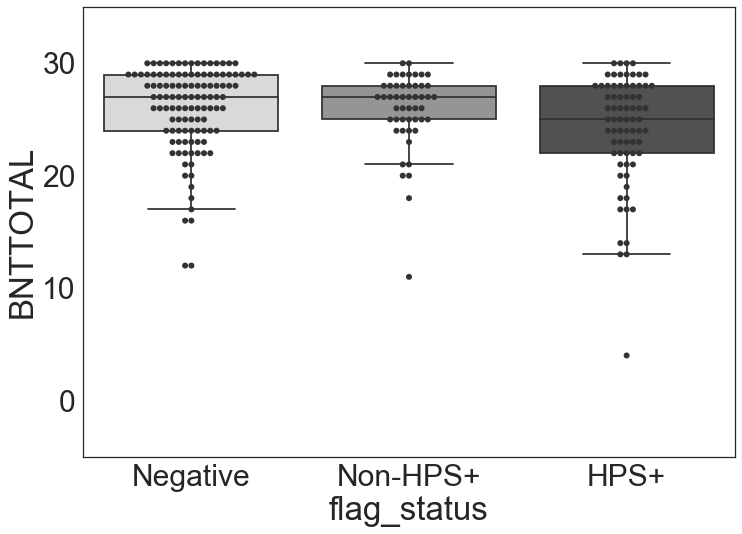

ANOVA F:  5.39153090715
p value:  0.00513849424268
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative  1.9403   0.4907 3.3898  True 
  HPS+   Non-HPS+  1.7715  -0.0036 3.5466 False 
Negative Non-HPS+ -0.1688   -1.809 1.4715 False 
------------------------------------------------


In [103]:
# adni language
anova_hpc(df2, 'BNTTOTAL', -5, 35, path_results + 'adni1_mci_language.pdf')

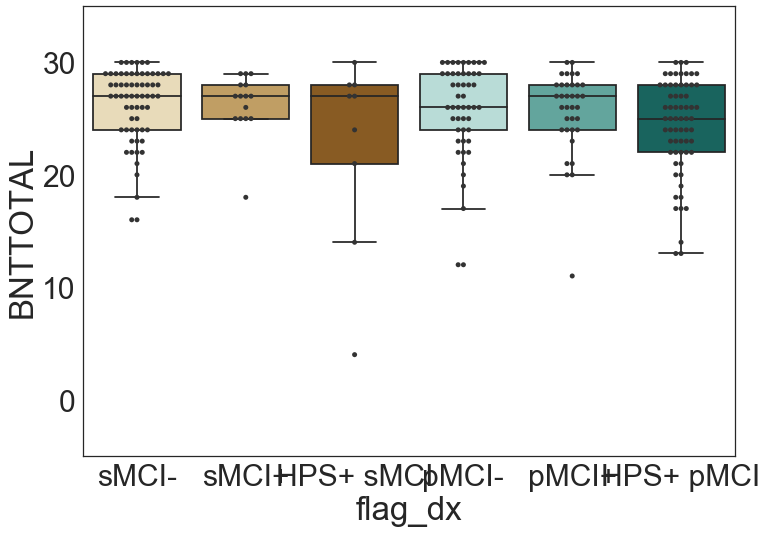

ANOVA F:  2.57724415082
p value:  0.0272070969846
Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower  upper  reject
--------------------------------------------------
HPS+ pMCI HPS+ sMCI -1.7257  -5.9274 2.476  False 
HPS+ pMCI   pMCI+    1.3473  -1.1339 3.8285 False 
HPS+ pMCI   pMCI-    1.4387  -0.7889 3.6664 False 
HPS+ pMCI   sMCI+    2.0521  -1.3336 5.4378 False 
HPS+ pMCI   sMCI-    1.9531  -0.1333 4.0395 False 
HPS+ sMCI   pMCI+    3.073    -1.338 7.4841 False 
HPS+ sMCI   pMCI-    3.1644  -1.1091 7.438  False 
HPS+ sMCI   sMCI+    3.7778  -1.1986 8.7541 False 
HPS+ sMCI   sMCI-    3.6788  -0.5228 7.8805 False 
  pMCI+     pMCI-    0.0914  -2.5097 2.6926 False 
  pMCI+     sMCI+    0.7048  -2.9375 4.3471 False 
  pMCI+     sMCI-    0.6058  -1.8754 3.087  False 
  pMCI-     sMCI+    0.6133  -2.8612 4.0879 False 
  pMCI-     sMCI-    0.5144  -1.7133 2.742  False 
  sMCI+     sMCI-    -0.099  -3.4847 3.2867 False 
--------------------------------

In [104]:
anova_hpc_split(df2, 'BNTTOTAL', -5, 35, 'sMCI', 'pMCI', path_results + 'adni1_mci_language_split.pdf')

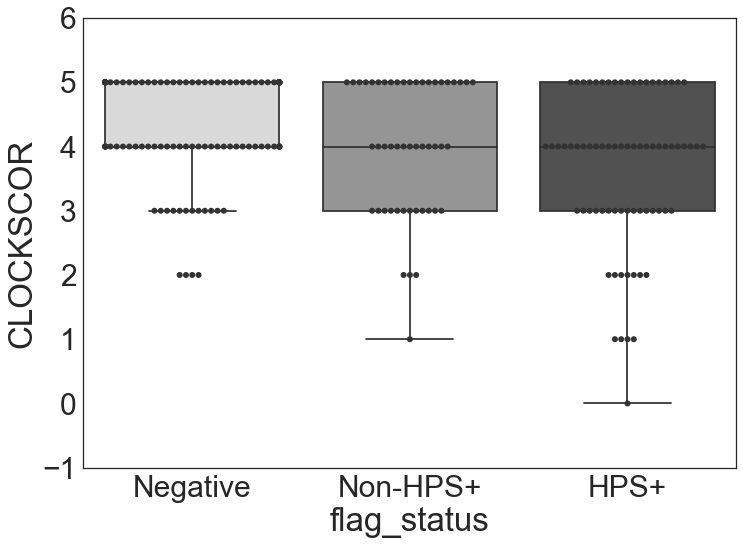

ANOVA F:  12.2591702058
p value:  8.62436883652e-06
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative  0.7351   0.3831 1.0871  True 
  HPS+   Non-HPS+  0.3699  -0.0619 0.8017 False 
Negative Non-HPS+ -0.3652  -0.7637 0.0332 False 
------------------------------------------------


In [105]:
# vis spat
anova_hpc(df2, 'CLOCKSCOR', -1, 6, path_results + 'adni1_mci_clock.pdf')

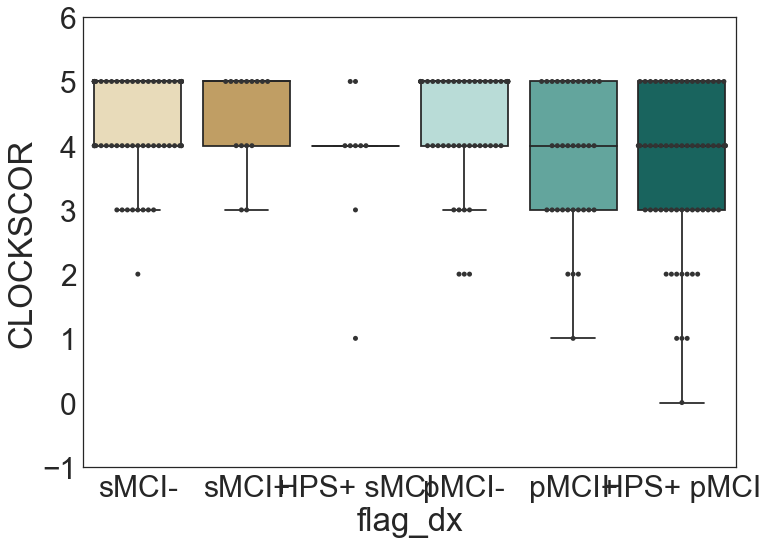

ANOVA F:  5.9369357033
p value:  3.46118874687e-05
Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower  upper  reject
--------------------------------------------------
HPS+ pMCI HPS+ sMCI  0.1684  -0.8475 1.1843 False 
HPS+ pMCI   pMCI+    0.1906  -0.4093 0.7906 False 
HPS+ pMCI   pMCI-    0.7506   0.212  1.2892  True 
HPS+ pMCI   sMCI+    0.8573   0.0387 1.6759  True 
HPS+ pMCI   sMCI-    0.7599   0.2573 1.2624  True 
HPS+ sMCI   pMCI+    0.0222  -1.0443 1.0888 False 
HPS+ sMCI   pMCI-    0.5822  -0.4511 1.6155 False 
HPS+ sMCI   sMCI+    0.6889  -0.5143 1.8921 False 
HPS+ sMCI   sMCI-    0.5915  -0.4235 1.6064 False 
  pMCI+     pMCI-     0.56   -0.0689 1.1889 False 
  pMCI+     sMCI+    0.6667   -0.214 1.5473 False 
  pMCI+     sMCI-    0.5692  -0.0291 1.1675 False 
  pMCI-     sMCI+    0.1067  -0.7334 0.9468 False 
  pMCI-     sMCI-    0.0092  -0.5276 0.546  False 
  sMCI+     sMCI-   -0.0974  -0.9149  0.72  False 
-------------------------------

In [106]:
anova_hpc_split(df2, 'CLOCKSCOR', -1, 6, 'sMCI', 'pMCI', path_results + 'adni1_mci_clock_split.pdf')

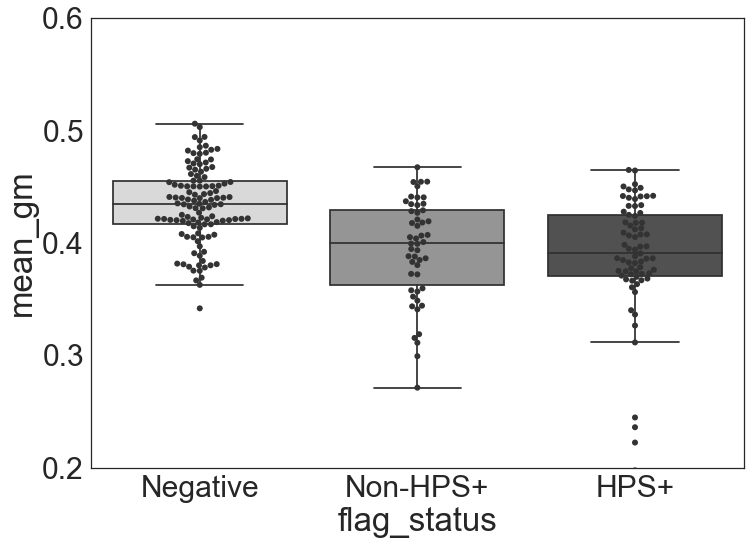

ANOVA F:  28.9374763457
p value:  5.82521046758e-12
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative  0.0492   0.0329  0.0656  True 
  HPS+   Non-HPS+  0.0097  -0.0103  0.0298 False 
Negative Non-HPS+ -0.0395   -0.058 -0.0209  True 
-------------------------------------------------


In [107]:
anova_hpc(df2, 'mean_gm', 0.2, 0.6, path_results + 'adni1_mci_meangm.pdf')

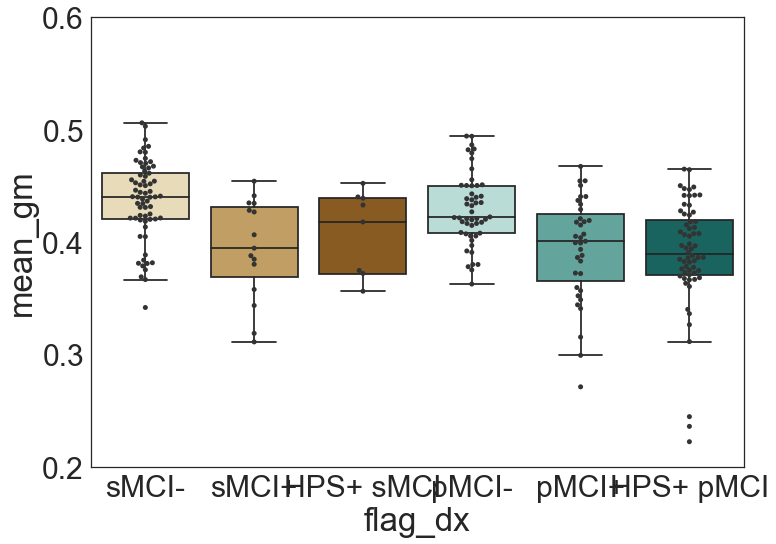

ANOVA F:  11.6329407334
p value:  4.84058849772e-10
Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower  upper  reject
--------------------------------------------------
HPS+ pMCI HPS+ sMCI  0.0012  -0.0465 0.0489 False 
HPS+ pMCI   pMCI+    0.0101  -0.0181 0.0382 False 
HPS+ pMCI   pMCI-    0.0449   0.0196 0.0702  True 
HPS+ pMCI   sMCI+    0.0095  -0.0289 0.0479 False 
HPS+ pMCI   sMCI-    0.0528   0.0292 0.0764  True 
HPS+ sMCI   pMCI+    0.0089  -0.0412 0.059  False 
HPS+ sMCI   pMCI-    0.0437  -0.0048 0.0922 False 
HPS+ sMCI   sMCI+    0.0083  -0.0481 0.0648 False 
HPS+ sMCI   sMCI-    0.0517   0.004  0.0993  True 
  pMCI+     pMCI-    0.0348   0.0053 0.0644  True 
  pMCI+     sMCI+   -0.0005  -0.0419 0.0408 False 
  pMCI+     sMCI-    0.0428   0.0147 0.0709  True 
  pMCI-     sMCI+   -0.0354  -0.0748 0.0041 False 
  pMCI-     sMCI-    0.0079  -0.0173 0.0331 False 
  sMCI+     sMCI-    0.0433   0.0049 0.0817  True 
------------------------------

In [108]:
anova_hpc_split(df2, 'mean_gm', 0.2, 0.6, 'sMCI', 'pMCI', path_results + 'adni1_mci_meangm_split.pdf')

# REPLICATION IN ADNI2 

In [109]:
adni2_df = pd.read_csv('/Users/AngelaTam/Desktop/adsf/adni1_vbm_adcn_subtypes_20171209/7clus/adni2_model_weights.csv')

In [110]:
adni2_df.drop(adni2_df[adni2_df.RID < 2000].index,inplace=True)

In [111]:
# get rid of NaNs
adni2_df.dropna(axis=0,how='any',subset=['sub1','gender','age_scan','mean_gm','tiv','conv_2_ad'],inplace=True)

## AD vs CN 

In [112]:
# Mask of the AD and CN subjects only
mask_cnad = adni2_df.loc[:,['CN','AD']].values.sum(1).astype(bool)

x_ = adni2_df.iloc[mask_cnad,adni2_df.columns.get_loc("sub1"):adni2_df.columns.get_loc("sub7")+1].values
#x_ = scalerX.transform(x_)
y_ = adni2_df[['AD']].values.ravel()[mask_cnad]


confounds = adni2_df[['gender','age_scan','mean_gm','tiv']].values[mask_cnad,:]
#confounds = data[['sex','age_r']].values[mask_mci,:]
#confounds[:, 1:] = scaler.transform(confounds[:, 1:])
#confounds[:, 0] = preprocessing.binarize(confounds[:, 0].reshape(-1, 1), threshold=1)[:, 0]
#confounds = scaler.transform(confounds)
#x_ = crm.transform(confounds, x_)

x_ = scaler.transform(np.hstack((x_,confounds)))

x_.shape, y_.shape, confounds.shape

((278, 11), (278,), (278, 4))

In [113]:
array_results, dic_results = hpc.predict(x_, x_)

# Level 1
print('Level 1')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float))

print('Level 2')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float), dic_results['s2df'][:,1]>0)
#stats_mask(dic_results['s2df'][:,2]>0)
#stats_mask(dic_results['s2df'][:,3]>0)

Level 1
------------------------
Ratio: 1.0
#    :  90.0
# true values:  278
ACC  :  0.723021582734
Level 2
------------------------
Ratio: 0.333333333333
#    :  30.0
# true values:  46
ACC  :  0.652173913043


In [114]:
y_pred = (dic_results['s1df'][:,0]>0).astype(float)
lr_decision = dic_results['s2df'][:,1]

In [115]:
predic_stats(y_, y_pred, lr_decision)

Total number of TARGET subjects:  90.0
Total number of NON-TARGET subjects:  188.0
Stage 1 number of hits (true and false positives):  89.0
Stage 1 TRUE positives:  51.0
Stage 1 FALSE positives:  38.0
Stage 1 TRUE negatives:  150.0
Total number of flagged HPC-AD subjects:  46.0
Number of flagged HPC-AD subjects that are TRUE positives:  30.0
Number of flagged HPC-AD subjects that are FALSE positives:  16.0
Number of true negatives:  172.0
#############################
Stage 1 stats for TARGET vs NON-TARGET
Precision for AD:  0.573033707865
Recall (or sensitivity)  for AD:  0.566666666667
Specificity:  0.797872340426
Adjusted precision for 33.6% baseline rate:  0.586545015993
Accuracy:  0.723021582734
#############################
Stage 2 stats for TARGET vs NON-TARGET
Precision for HPC-AD:  0.652173913043
Recall (or sensitivity) for HPC-AD:  0.333333333333
Specificity:  0.914893617021
Adjusted precision for 33.6% baseline rate:  0.664646464646
Accuracy:  0.726618705036


(0.56666666666666665,
 0.7978723404255319,
 0.5730337078651685,
 0.7230215827338129,
 0.33333333333333331,
 0.91489361702127658,
 0.65217391304347827,
 0.72661870503597126)

In [116]:
# copy data frame and mask
df3 = deepcopy(adni2_df)
df3 = df3[mask_cnad]

In [117]:
hpc_df(df3, y_pred, lr_decision)

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [118]:
long_df_adni3_adcn = pd.merge(long_data, df3[['RID','flag_dx','flag_status']], 
                              how='left', on=['RID'])

In [119]:
long_df_adni3_adcn.dropna(subset=['flag_status'],inplace=True)

In [120]:
long_df_adni3_adcn.reset_index(inplace=True, drop=True)

In [121]:
long_df_adni3_adcn.to_csv(path_results + 'adni2_adcn_hps.csv')

## amyloid positivity (AV45) in ADNI2 AD vs CN

In [122]:
compare_ratio_var(df3, 'SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF', 'AD')

baseline rate in NON-TARGET subjects:  0.3370165745856354
##########
baseline rate in TARGET subjects:  0.8953488372093024
##########
number of subjects with VOI in the whole sample:  138.0
total number of subjects with VOI data in whole sample:  267
ratio:  0.5168539325842697
##########
number of subjects with VOI that are positive at stage 1:  57.0
total number of positive stage 1 subjects with VOI data:  85
ratio:  0.6705882352941176
##########
number of subjects with VOI in HPC-AD:  32.0
total number of HPC-AD subjects with VOI data:  44
ratio:  0.7272727272727273
##########
number of subjects with VOI in Non-HPC+:  25.0
total number of Non-HPC+ with VOI data:  41
ratio:  0.6097560975609756
##########
number of subjects with VOI in negative subjects:  81.0
total number of negative subjects with VOI data 182
ratio:  0.44505494505494503


In [123]:
tmp_df = chi2_fn(df3, 'SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF')

observed freq: 
[[ 101.   16.   12.]
 [  81.   25.   32.]]
Chi2:  12.975693503
p value:  0.00152182234431
degress of freedom:  2
expected freq: 
[[ 87.93258427  19.80898876  21.25842697]
 [ 94.06741573  21.19101124  22.74157303]]


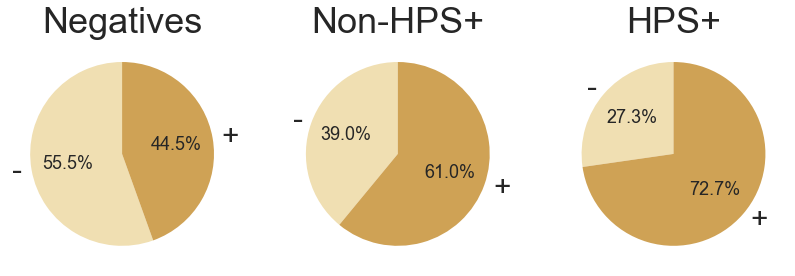

In [124]:
hpc_pie(tmp_df, 'SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF', path_results + 'adni2_adcn_hpc_av45_pie.pdf')

## apoe4 carriership in ADNI2 AD vs CN

In [125]:
compare_ratio_var(df3, 'APOE4_bin', 'AD')

baseline rate in NON-TARGET subjects:  0.29411764705882354
##########
baseline rate in TARGET subjects:  0.7045454545454546
##########
number of subjects with VOI in the whole sample:  117.0
total number of subjects with VOI data in whole sample:  275
ratio:  0.4254545454545455
##########
number of subjects with VOI that are positive at stage 1:  44.0
total number of positive stage 1 subjects with VOI data:  88
ratio:  0.5
##########
number of subjects with VOI in HPC-AD:  25.0
total number of HPC-AD subjects with VOI data:  46
ratio:  0.5434782608695652
##########
number of subjects with VOI in Non-HPC+:  19.0
total number of Non-HPC+ with VOI data:  42
ratio:  0.4523809523809524
##########
number of subjects with VOI in negative subjects:  73.0
total number of negative subjects with VOI data 187
ratio:  0.39037433155080214


In [126]:
tmp_df = chi2_fn(df3, 'APOE4_bin')

observed freq: 
[[ 114.   23.   21.]
 [  73.   19.   25.]]
Chi2:  3.68731807998
p value:  0.158237368667
degress of freedom:  2
expected freq: 
[[ 107.44         24.13090909   26.42909091]
 [  79.56         17.86909091   19.57090909]]


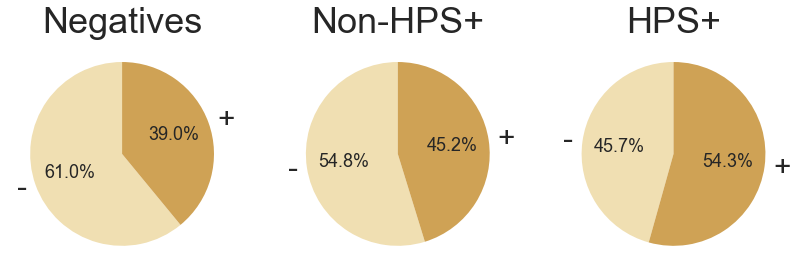

In [127]:
hpc_pie(tmp_df, 'APOE4_bin', path_results + 'adni2_adcn_hpc_e4_pie.pdf')

## gender (% male) in ADNI2 AD VS CN

In [128]:
compare_ratio_var(df3, 'gender', 'AD')

baseline rate in NON-TARGET subjects:  0.4574468085106383
##########
baseline rate in TARGET subjects:  0.5444444444444444
##########
number of subjects with VOI in the whole sample:  135.0
total number of subjects with VOI data in whole sample:  278
ratio:  0.4856115107913669
##########
number of subjects with VOI that are positive at stage 1:  50.0
total number of positive stage 1 subjects with VOI data:  89
ratio:  0.5617977528089888
##########
number of subjects with VOI in HPC-AD:  28.0
total number of HPC-AD subjects with VOI data:  46
ratio:  0.6086956521739131
##########
number of subjects with VOI in Non-HPC+:  22.0
total number of Non-HPC+ with VOI data:  43
ratio:  0.5116279069767442
##########
number of subjects with VOI in negative subjects:  85.0
total number of negative subjects with VOI data 189
ratio:  0.4497354497354497


In [129]:
chi2_fn(df3, 'gender')

observed freq: 
[[ 104.   21.   18.]
 [  85.   22.   28.]]
Chi2:  3.88021920588
p value:  0.143688200265
degress of freedom:  2
expected freq: 
[[ 97.21942446  22.11870504  23.6618705 ]
 [ 91.78057554  20.88129496  22.3381295 ]]


Negative  Non-HPS+  HPS+ gender
0     104.0      21.0  18.0      -
1      85.0      22.0  28.0      +

## csf abeta in ADNI2 AD VS CN

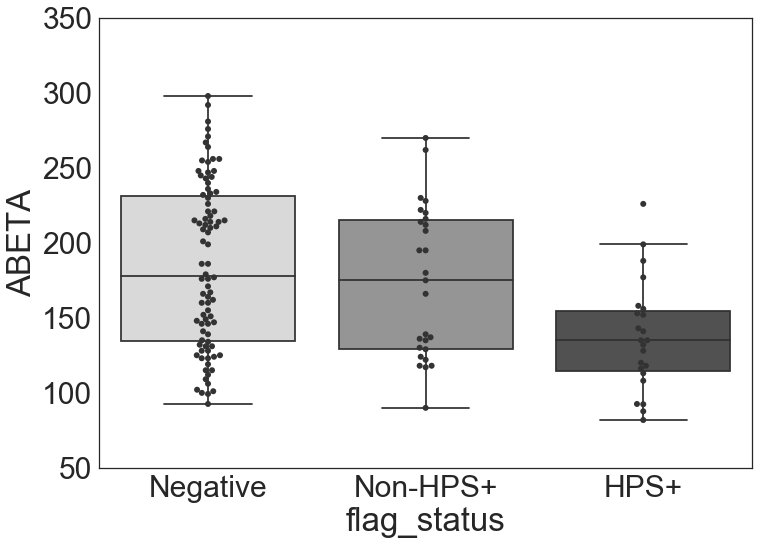

ANOVA F:  7.77123980929
p value:  0.000642783344309
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower    upper  reject
--------------------------------------------------
  HPS+   Negative 47.6641  18.9973  76.3309  True 
  HPS+   Non-HPS+ 36.5738   1.9225   71.225  True 
Negative Non-HPS+ -11.0904 -38.0297  15.849 False 
--------------------------------------------------


In [130]:
anova_hpc(df3, 'ABETA', 50, 350, path_results + 'adni2_adcn_csf_abeta.pdf')

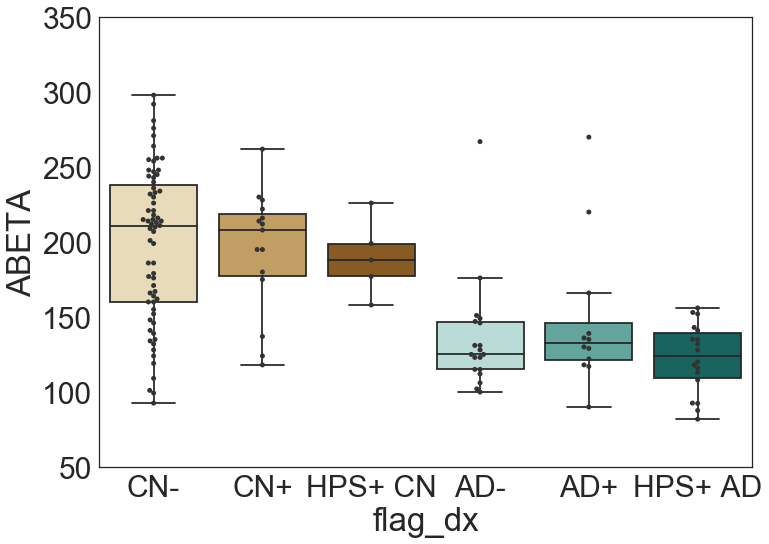

ANOVA F:  13.2160052035
p value:  2.07493919642e-10
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff   lower    upper   reject
--------------------------------------------------
  AD+     AD-   -12.2952  -60.1223 35.5319  False 
  AD+     CN+   46.7417   -3.4933  96.9767  False 
  AD+     CN-   51.0536   10.3956  91.7116   True 
  AD+   HPS+ AD -25.2028  -73.5414 23.1359  False 
  AD+   HPS+ CN 41.9417   -27.0997 110.9831 False 
  AD-     CN+   59.0368   14.2369  103.8368  True 
  AD-     CN-   63.3488   29.6359  97.0617   True 
  AD-   HPS+ AD -12.9076  -55.5703 29.7551  False 
  AD-   HPS+ CN 54.2368   -10.9567 119.4304 False 
  CN+     CN-    4.3119   -32.7378 41.3616  False 
  CN+   HPS+ AD -71.9444 -117.2901 -26.5988  True 
  CN+   HPS+ CN   -4.8     -71.78   62.18   False 
  CN-   HPS+ AD -76.2564 -110.6911 -41.8217  True 
  CN-   HPS+ CN -9.1119   -69.2438 51.0199  False 
HPS+ AD HPS+ CN 67.1444    1.5747  132.7142  True 
------------------------------

In [131]:
anova_hpc_split(df3, 'ABETA', 50, 350, 'CN', 'AD', path_results + 'adni2_adcn_csf_abeta_split.pdf')

##  csf tau in ADNI2 AD VS CN

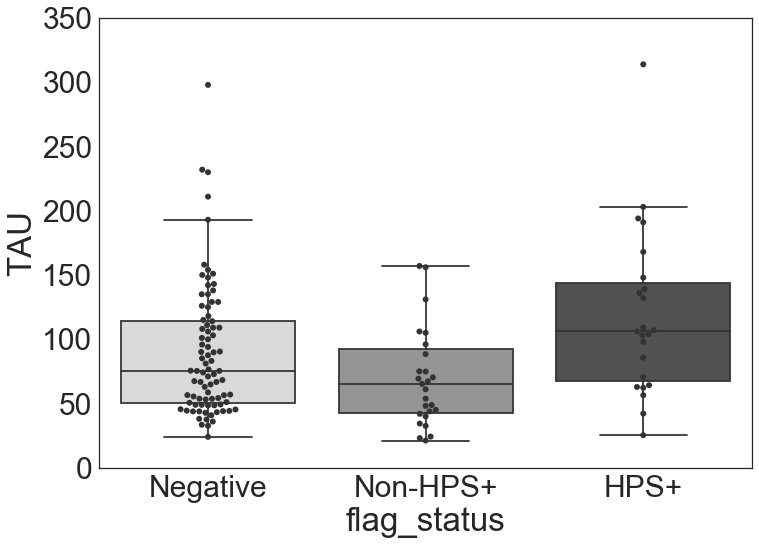

ANOVA F:  3.18928962518
p value:  0.0444195354963
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower    upper  reject
--------------------------------------------------
  HPS+   Negative -28.8111 -60.709   3.0869 False 
  HPS+   Non-HPS+ -39.105  -77.5654 -0.6446  True 
Negative Non-HPS+ -10.2939 -40.2797 19.6918 False 
--------------------------------------------------


In [132]:
anova_hpc(df3, 'TAU', 0, 350, path_results + 'adni2_adcn_csf_tau.pdf')

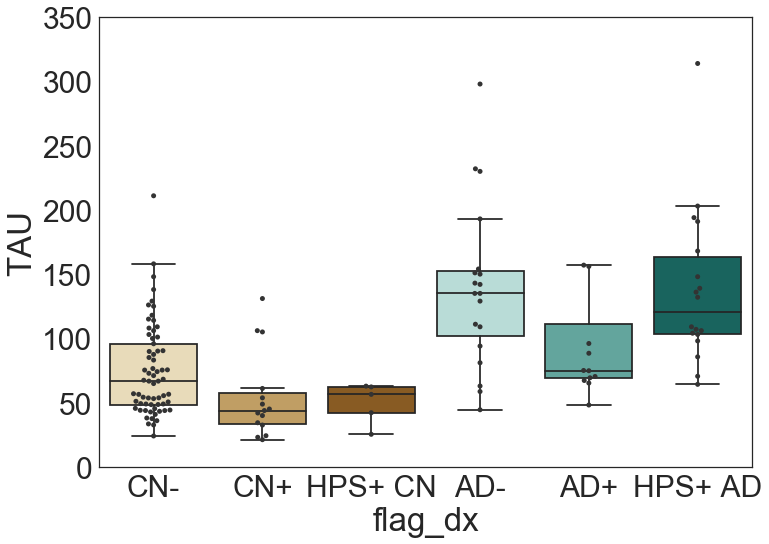

ANOVA F:  10.8747887647
p value:  9.84135207703e-09
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff   lower    upper   reject
--------------------------------------------------
  AD+     AD-    29.018   -23.9198 81.9558  False 
  AD+     CN+   -56.5283 -112.1313 -0.9253   True 
  AD+     CN-   -35.7637  -80.8714  9.344   False 
  AD+   HPS+ AD 26.7417   -26.7623 80.2457  False 
  AD+   HPS+ CN -60.8483 -137.2673 15.5707  False 
  AD-     CN+   -85.5463 -135.1335 -35.9591  True 
  AD-     CN-   -64.7817 -102.2237 -27.3397  True 
  AD-   HPS+ AD -2.2763   -49.4979 44.9452  False 
  AD-   HPS+ CN -89.8663 -162.0263 -17.7063  True 
  CN+     CN-   20.7646   -20.3594 61.8886  False 
  CN+   HPS+ AD  83.27    33.0788  133.4612  True 
  CN+   HPS+ CN  -4.32    -78.4573 69.8173  False 
  CN-   HPS+ AD 62.5054   24.2671  100.7437  True 
  CN-   HPS+ CN -25.0846  -91.7131 41.5439  False 
HPS+ AD HPS+ CN  -87.59  -160.1664 -15.0136  True 
------------------------------

In [133]:
anova_hpc_split(df3, 'TAU', 0, 350, 'CN', 'AD', path_results + 'adni2_adcn_csf_tau_split.pdf')

## age in ADNI2 AD VS CN

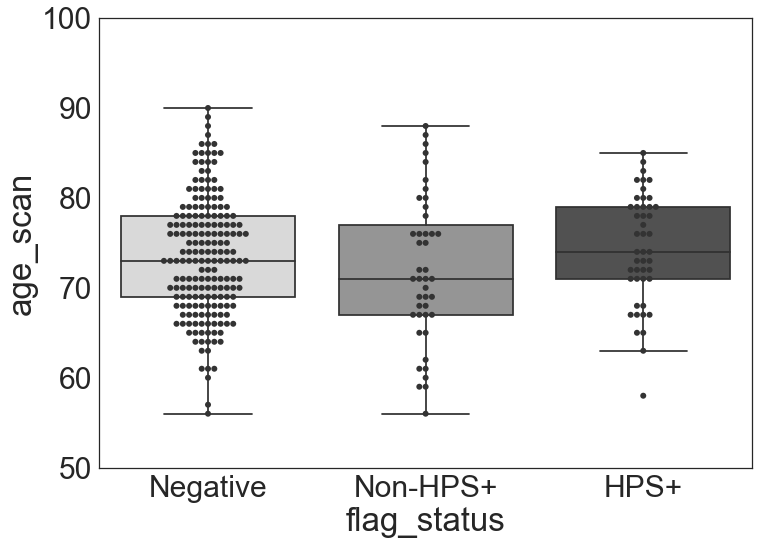

ANOVA F:  1.36149580676
p value:  0.257999055779
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative  -0.904  -3.5347 1.7268 False 
  HPS+   Non-HPS+ -2.3463  -5.7405 1.0479 False 
Negative Non-HPS+ -1.4424  -4.1459 1.2612 False 
------------------------------------------------


In [134]:
anova_hpc(df3, 'age_scan', 50, 100, path_results + 'adni2_adcn_age.pdf')

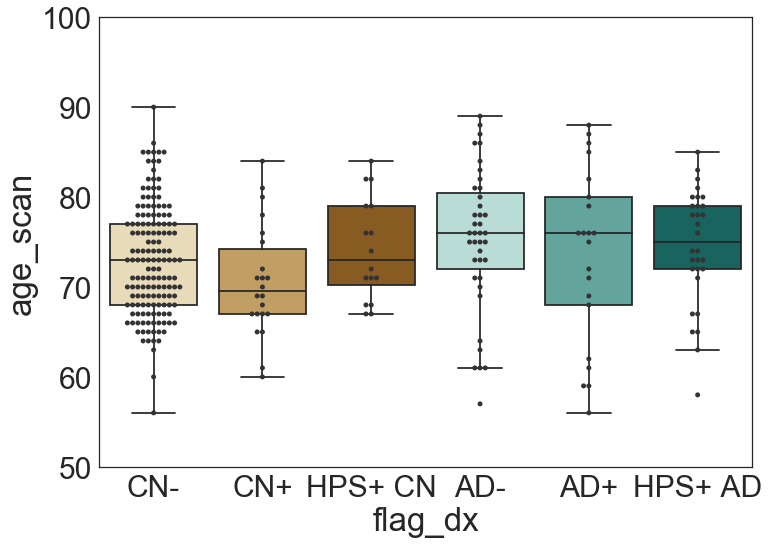

ANOVA F:  1.70521352678
p value:  0.133536005744
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff  lower  upper  reject
----------------------------------------------
  AD+     AD-    1.8828  -3.3656 7.1312 False 
  AD+     CN+   -2.8398  -8.7555 3.0759 False 
  AD+     CN-   -0.5029  -5.0208 4.015  False 
  AD+   HPS+ AD  0.9905  -4.5266 6.5075 False 
  AD+   HPS+ CN  0.7113  -5.7233 7.146  False 
  AD-     CN+   -4.7226  -9.8929 0.4477 False 
  AD-     CN-   -2.3856   -5.871 1.0997 False 
  AD-   HPS+ AD -0.8923  -5.6013 3.8167 False 
  AD-   HPS+ CN -1.1715  -6.9283 4.5853 False 
  CN+     CN-    2.337   -2.0899 6.7639 False 
  CN+   HPS+ AD  3.8303  -1.6125 9.2731 False 
  CN+   HPS+ CN  3.5511   -2.82  9.9222 False 
  CN-   HPS+ AD  1.4933  -2.3848 5.3715 False 
  CN-   HPS+ CN  1.2142  -3.8855 6.3138 False 
HPS+ AD HPS+ CN -0.2792  -6.2819 5.7236 False 
----------------------------------------------


In [135]:
anova_hpc_split(df3, 'age_scan', 50, 100, 'CN', 'AD', path_results + 'adni2_adcn_age_split.pdf')

## cognition in ADNI2 AD VS CN

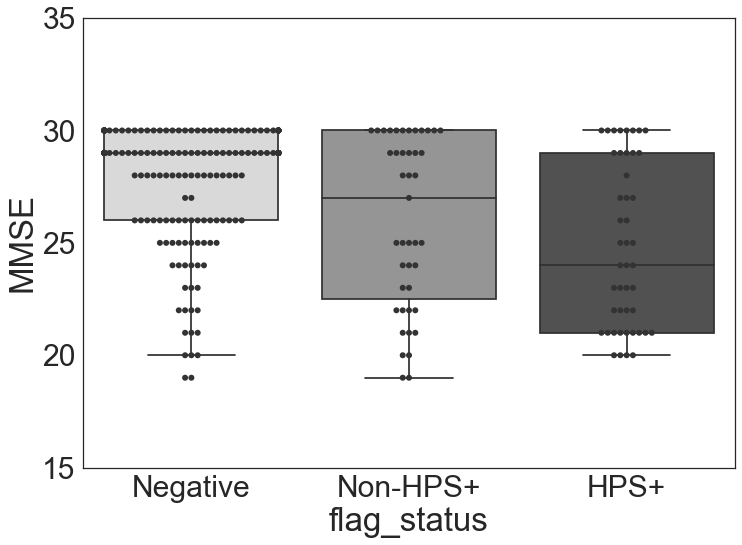

ANOVA F:  23.5611365287
p value:  3.59245705112e-10
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative  3.121    1.954  4.288   True 
  HPS+   Non-HPS+  1.1507  -0.3551 2.6564 False 
Negative Non-HPS+ -1.9703  -3.1697 -0.771  True 
------------------------------------------------


In [136]:
# mmse
anova_hpc(df3, 'MMSE', 15, 35, path_results + 'adni2_adcn_mmse.pdf')

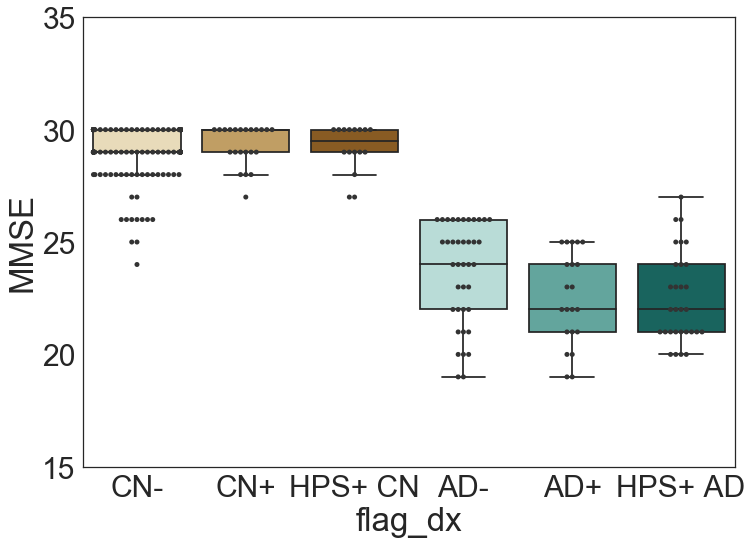

ANOVA F:  195.649935933
p value:  6.82250880145e-88
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff  lower   upper  reject
-----------------------------------------------
  AD+     AD-    1.2161   0.0284  2.4039  True 
  AD+     CN+    6.842    5.5032  8.1807  True 
  AD+     CN-    6.5771   5.5547  7.5996  True 
  AD+   HPS+ AD  0.0238  -1.2247  1.2724 False 
  AD+   HPS+ CN  6.7113   5.2551  8.1675  True 
  AD-     CN+    5.6259   4.4558  6.7959  True 
  AD-     CN-    5.361    4.5723  6.1498  True 
  AD-   HPS+ AD -1.1923   -2.258 -0.1266  True 
  AD-   HPS+ CN  5.4952   4.1924  6.798   True 
  CN+     CN-   -0.2648  -1.2667  0.737  False 
  CN+   HPS+ AD -6.8182  -8.0499 -5.5864  True 
  CN+   HPS+ CN -0.1307  -1.5725  1.3111 False 
  CN-   HPS+ AD -6.5533   -7.431 -5.6757  True 
  CN-   HPS+ CN  0.1342  -1.0199  1.2883 False 
HPS+ AD HPS+ CN  6.6875   5.329   8.046   True 
-----------------------------------------------


In [137]:
anova_hpc_split(df3, 'MMSE', 15, 35, 'CN', 'AD', path_results + 'adni2_adcn_mmse_split.pdf')

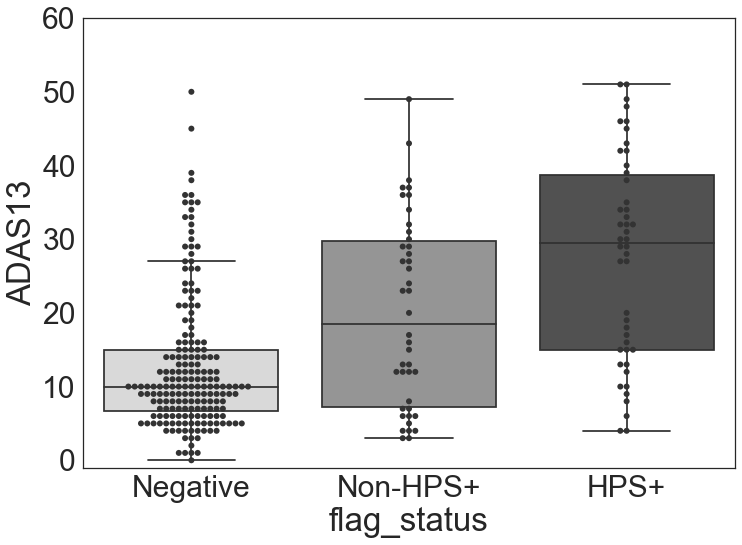

ANOVA F:  37.7181572388
p value:  3.4383941738e-15
 Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower    upper   reject
---------------------------------------------------
  HPS+   Negative -14.7828 -18.9638 -10.6018  True 
  HPS+   Non-HPS+ -7.4482  -12.8729 -2.0236   True 
Negative Non-HPS+  7.3346   2.9966  11.6726   True 
---------------------------------------------------


In [138]:
# adas cog
anova_hpc(df3, 'ADAS13', -1, 60, path_results + 'adni2_adcn_adas13.pdf')

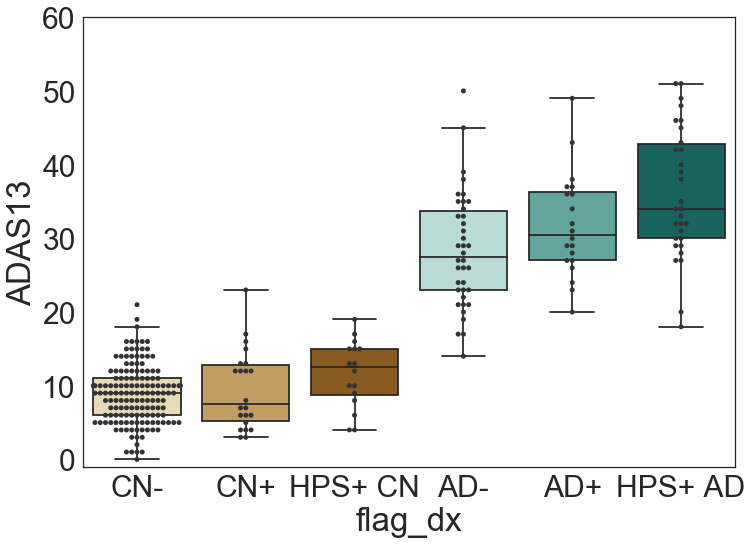

ANOVA F:  197.403412215
p value:  5.55522331504e-88
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff  lower    upper   reject
-------------------------------------------------
  AD+     AD-   -3.4316   -7.934   1.0709  False 
  AD+     CN+   -22.3455 -27.3809  -17.31   True 
  AD+     CN-   -22.9933 -26.8731 -19.1136  True 
  AD+   HPS+ AD  4.2333  -0.4716   8.9383  False 
  AD+   HPS+ CN -20.175  -25.6416 -14.7084  True 
  AD-     CN+   -18.9139 -23.2802 -14.5476  True 
  AD-     CN-   -19.5618 -22.5217 -16.6018  True 
  AD-   HPS+ AD  7.6649   3.6843  11.6455   True 
  AD-   HPS+ CN -16.7434 -21.6007 -11.8862  True 
  CN+     CN-   -0.6479  -4.3688   3.073   False 
  CN+   HPS+ AD 26.5788   22.004  31.1536   True 
  CN+   HPS+ CN  2.1705  -3.1846   7.5255  False 
  CN-   HPS+ AD 27.2267   23.967  30.4863   True 
  CN-   HPS+ CN  2.8183  -1.4681   7.1047  False 
HPS+ AD HPS+ CN -24.4083 -29.4538 -19.3629  True 
-----------------------------------------------

In [139]:
anova_hpc_split(df3, 'ADAS13', -1, 60 ,'CN', 'AD', path_results + 'adni2_adcn_adas13_split.pdf')

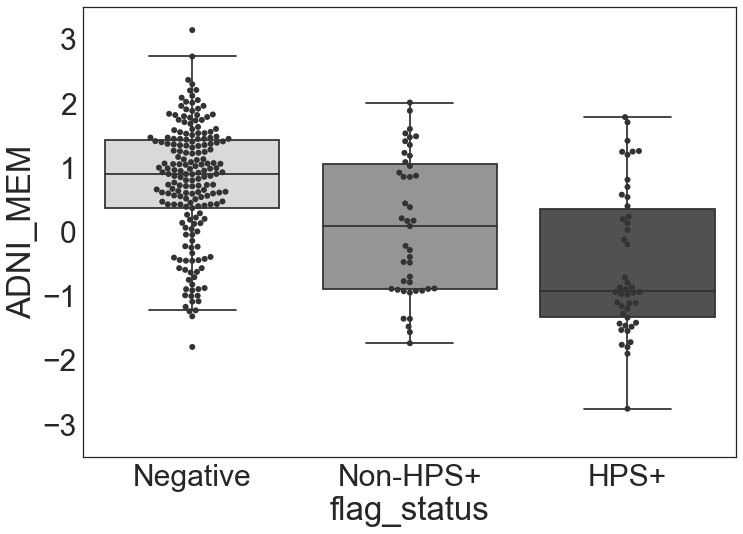

ANOVA F:  35.4255069454
p value:  2.04644740979e-14
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative  1.2699   0.8934  1.6464  True 
  HPS+   Non-HPS+  0.5749   0.0892  1.0607  True 
Negative Non-HPS+  -0.695  -1.0819 -0.3081  True 
-------------------------------------------------


In [140]:
# adni memory
anova_hpc(df3, 'ADNI_MEM', -3.5, 3.5, path_results + 'adni2_adcn_memory.pdf')

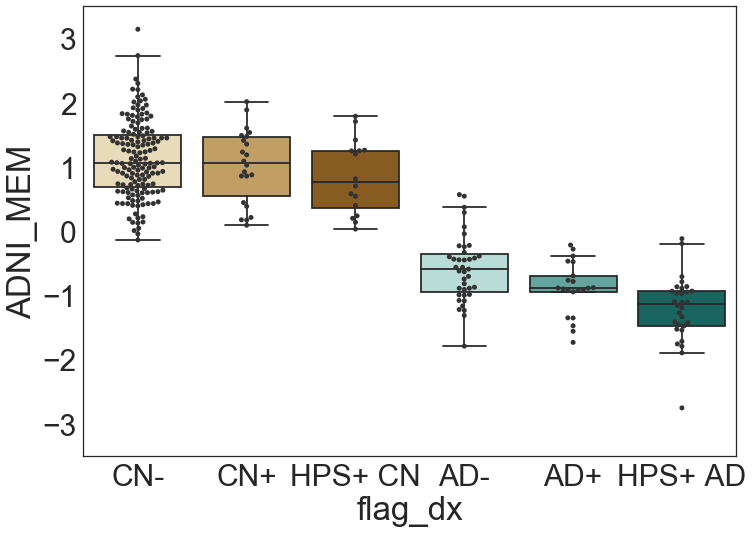

ANOVA F:  154.001870037
p value:  3.61473828889e-77
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff  lower   upper  reject
-----------------------------------------------
  AD+     AD-    0.3084  -0.1265  0.7433 False 
  AD+     CN+    1.909    1.4188  2.3992  True 
  AD+     CN-    2.0261   1.6517  2.4005  True 
  AD+   HPS+ AD -0.3121  -0.7693  0.1451 False 
  AD+   HPS+ CN  1.7403   1.2071  2.2735  True 
  AD-     CN+    1.6006   1.1721  2.029   True 
  AD-     CN-    1.7177   1.4289  2.0065  True 
  AD-   HPS+ AD -0.6205  -1.0107 -0.2303  True 
  AD-   HPS+ CN  1.4319   0.9548  1.9089  True 
  CN+     CN-    0.1171  -0.2497  0.484  False 
  CN+   HPS+ AD -2.2211  -2.6721 -1.7701  True 
  CN+   HPS+ CN -0.1687  -0.6966  0.3592 False 
  CN-   HPS+ AD -2.3382  -2.6596 -2.0169  True 
  CN-   HPS+ CN -0.2858  -0.7084  0.1368 False 
HPS+ AD HPS+ CN  2.0524   1.555   2.5498  True 
-----------------------------------------------


In [141]:
anova_hpc_split(df3, 'ADNI_MEM', -3.5, 3.5, 'CN', 'AD', path_results + 'adni2_adcn_memory_split.pdf')

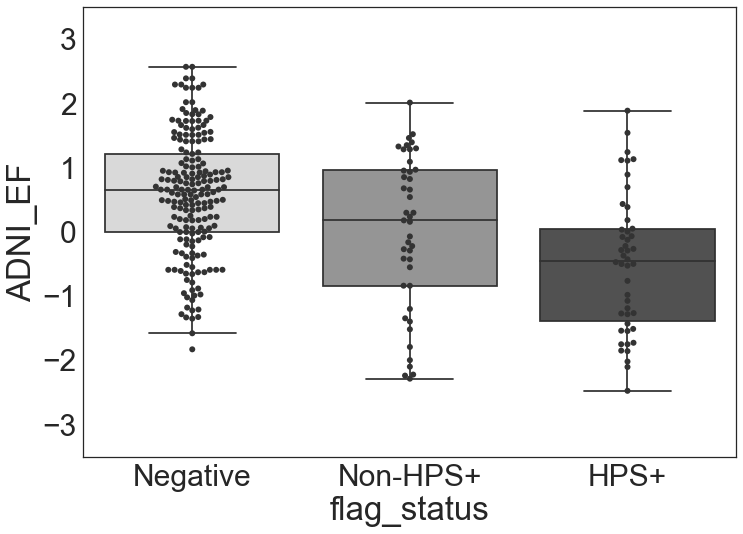

ANOVA F:  23.4865673415
p value:  3.82864829859e-10
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative  1.072    0.6813  1.4627  True 
  HPS+   Non-HPS+  0.4822  -0.0218  0.9863 False 
Negative Non-HPS+ -0.5898  -0.9913 -0.1883  True 
-------------------------------------------------


In [142]:
# adni executive function
anova_hpc(df3, 'ADNI_EF', -3.5, 3.5, path_results + 'adni2_adcn_ef.pdf')

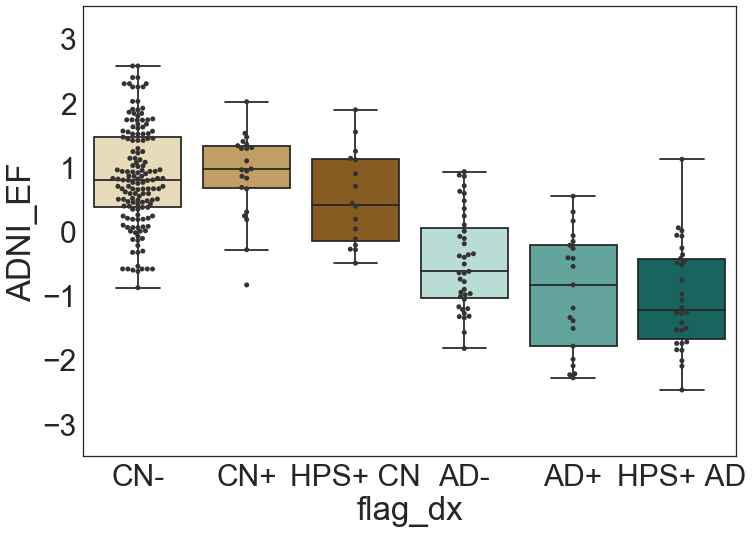

ANOVA F:  53.8825860548
p value:  9.42399538833e-39
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff  lower   upper  reject
-----------------------------------------------
  AD+     AD-    0.4824  -0.1217  1.0865 False 
  AD+     CN+    1.8405   1.1596  2.5214  True 
  AD+     CN-    1.8042   1.2842  2.3242  True 
  AD+   HPS+ AD -0.0755  -0.7105  0.5595 False 
  AD+   HPS+ CN  1.4623   0.7217  2.203   True 
  AD-     CN+    1.3581   0.763   1.9532  True 
  AD-     CN-    1.3218   0.9206  1.7229  True 
  AD-   HPS+ AD -0.5579  -1.0999 -0.0159  True 
  AD-   HPS+ CN  0.9799   0.3173  1.6425  True 
  CN+     CN-   -0.0363  -0.5459  0.4732 False 
  CN+   HPS+ AD  -1.916  -2.5424 -1.2895  True 
  CN+   HPS+ CN -0.3782  -1.1115  0.3552 False 
  CN-   HPS+ AD -1.8796   -2.326 -1.4333  True 
  CN-   HPS+ CN -0.3418  -0.9288  0.2451 False 
HPS+ AD HPS+ CN  1.5378   0.8469  2.2287  True 
-----------------------------------------------


In [143]:
anova_hpc_split(df3, 'ADNI_EF', -3.5, 3.5, 'CN', 'AD', path_results + 'adni2_adcn_ef_split.pdf')

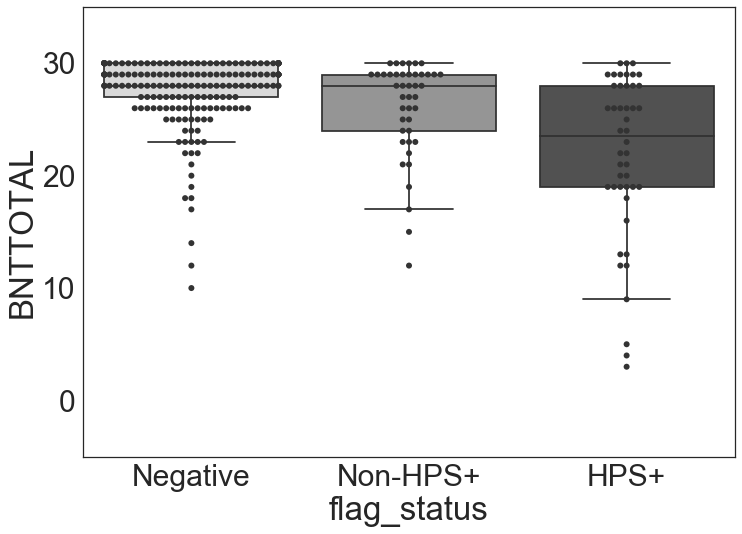

ANOVA F:  33.1115691352
p value:  1.30453392055e-13
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative  5.7629   4.0914 7.4344  True 
  HPS+   Non-HPS+  4.3089   2.1523 6.4655  True 
Negative Non-HPS+  -1.454  -3.1718 0.2637 False 
------------------------------------------------


In [144]:
# language
anova_hpc(df3, 'BNTTOTAL', -5, 35, path_results + 'adni2_adcn_language.pdf')

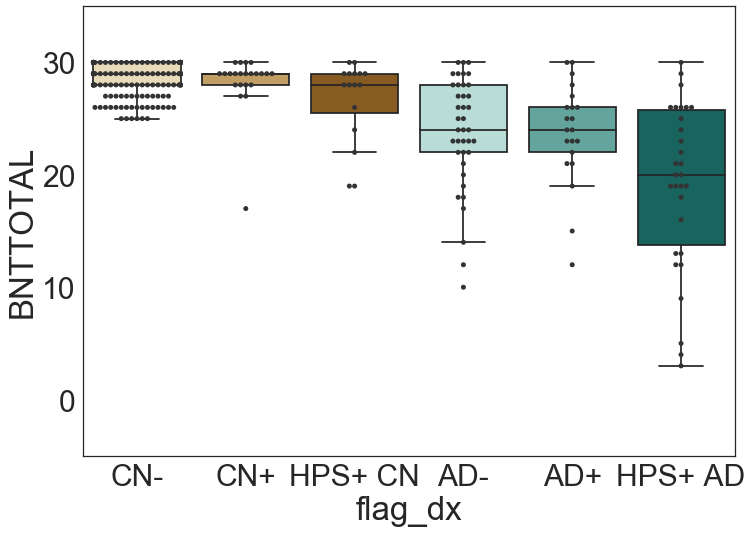

ANOVA F:  40.7675422186
p value:  3.18907427213e-31
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff  lower    upper  reject
------------------------------------------------
  AD+     AD-    0.0586  -2.7795   2.8967 False 
  AD+     CN+    4.5108   1.3119   7.7097  True 
  AD+     CN-    4.7248   2.2817   7.1678  True 
  AD+   HPS+ AD -4.6286  -7.6119  -1.6452  True 
  AD+   HPS+ CN  2.9256  -0.5539   6.4051 False 
  AD-     CN+    4.4522   1.6564   7.248   True 
  AD-     CN-    4.6662   2.7815   6.5509  True 
  AD-   HPS+ AD -4.6872  -7.2335  -2.1408  True 
  AD-   HPS+ CN  2.867    -0.246    5.98  False 
  CN+     CN-    0.2139  -2.1799   2.6078 False 
  CN+   HPS+ AD -9.1394  -12.0826 -6.1962  True 
  CN+   HPS+ CN -1.5852  -5.0304   1.8599 False 
  CN-   HPS+ AD -9.3533  -11.4504 -7.2562  True 
  CN-   HPS+ CN -1.7992  -4.5568   0.9585 False 
HPS+ AD HPS+ CN  7.5542   4.3082  10.8002  True 
------------------------------------------------


In [145]:
anova_hpc_split(df3, 'BNTTOTAL', -5, 35, 'CN', 'AD', path_results + 'adni2_adcn_language_split.pdf')

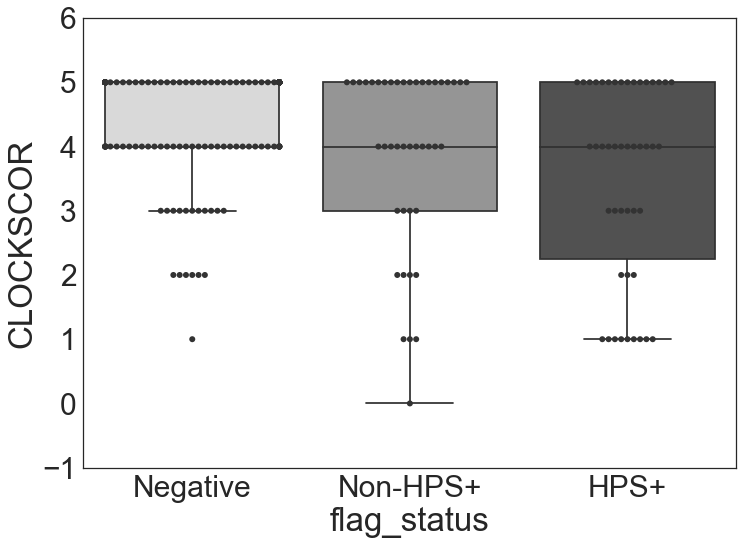

ANOVA F:  22.0460416112
p value:  1.31762360724e-09
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative  1.0503   0.6438  1.4567  True 
  HPS+   Non-HPS+  0.3837  -0.1407  0.9082 False 
Negative Non-HPS+ -0.6665  -1.0843 -0.2488  True 
-------------------------------------------------


In [146]:
# vis spat
anova_hpc(df3, 'CLOCKSCOR', -1, 6, path_results + 'adni2_adcn_clock.pdf')

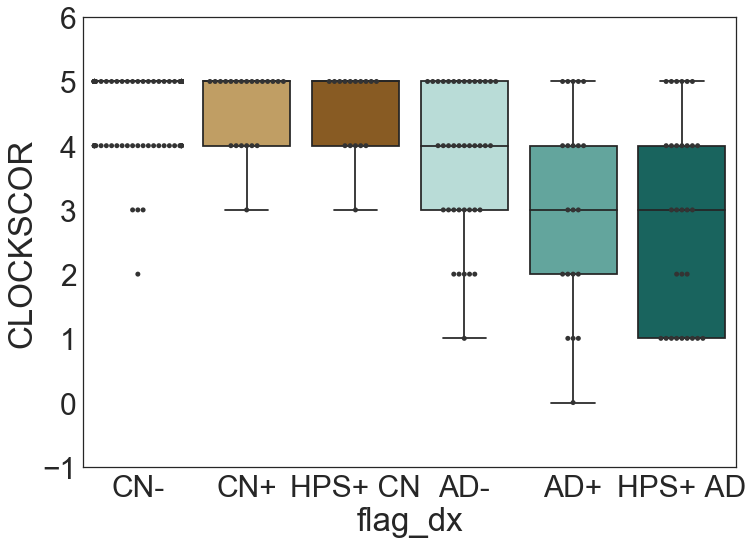

ANOVA F:  31.1612704267
p value:  4.83792671761e-25
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff  lower   upper  reject
-----------------------------------------------
  AD+     AD-    0.7253   0.0214  1.4292  True 
  AD+     CN+    1.5411   0.7477  2.3345  True 
  AD+     CN-    1.6448   1.0388  2.2507  True 
  AD+   HPS+ AD -0.1619  -0.9018  0.578  False 
  AD+   HPS+ CN  1.4673   0.6043  2.3302  True 
  AD-     CN+    0.8159   0.1224  1.5093  True 
  AD-     CN-    0.9195   0.452   1.3869  True 
  AD-   HPS+ AD -0.8872  -1.5187 -0.2556  True 
  AD-   HPS+ CN  0.742   -0.0301  1.5141 False 
  CN+     CN-    0.1036  -0.4901  0.6974 False 
  CN+   HPS+ AD  -1.703   -2.433 -0.9731  True 
  CN+   HPS+ CN -0.0739  -0.9283  0.7806 False 
  CN-   HPS+ AD -1.8067  -2.3268 -1.2865  True 
  CN-   HPS+ CN -0.1775  -0.8614  0.5064 False 
HPS+ AD HPS+ CN  1.6292   0.8241  2.4342  True 
-----------------------------------------------


In [147]:
anova_hpc_split(df3, 'CLOCKSCOR', -1, 6, 'CN', 'AD', path_results + 'adni2_adcn_clock_split.pdf')

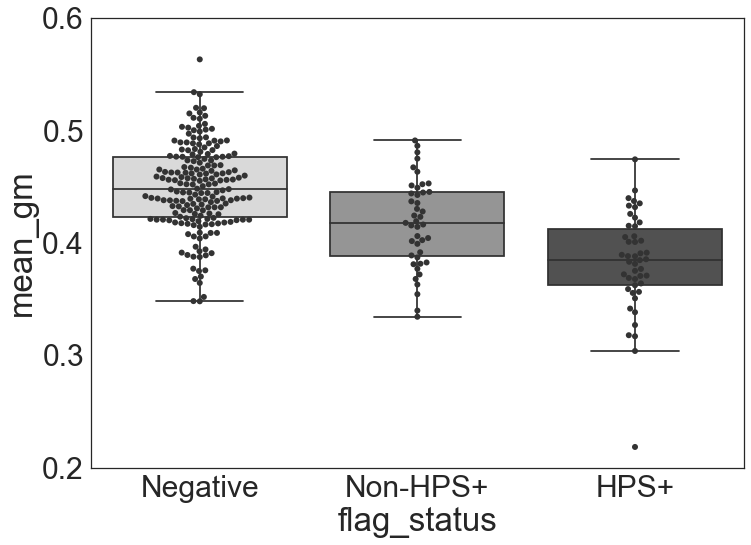

ANOVA F:  57.4391899427
p value:  1.43049684257e-21
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative  0.0662   0.0511  0.0814  True 
  HPS+   Non-HPS+  0.0345   0.015   0.054   True 
Negative Non-HPS+ -0.0317  -0.0473 -0.0162  True 
-------------------------------------------------


In [148]:
anova_hpc(df3, 'mean_gm', 0.2, 0.6, path_results + 'adni2_adcn_meangm.pdf')

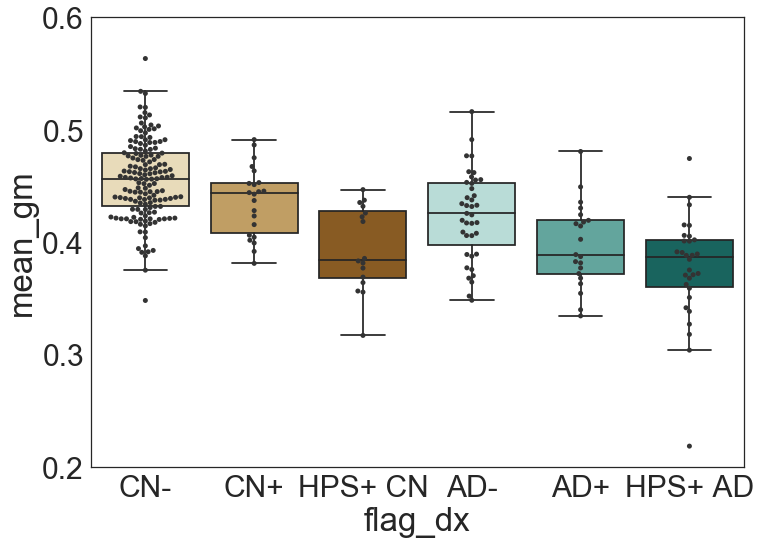

ANOVA F:  33.4767467494
p value:  1.36844796218e-26
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff  lower   upper  reject
-----------------------------------------------
  AD+     AD-    0.0267  -0.0019  0.0552 False 
  AD+     CN+    0.0395   0.0073  0.0717  True 
  AD+     CN-    0.0585   0.0339  0.0831  True 
  AD+   HPS+ AD -0.0204  -0.0504  0.0096 False 
  AD+   HPS+ CN -0.0029   -0.038  0.0321 False 
  AD-     CN+    0.0128  -0.0153  0.041  False 
  AD-     CN-    0.0318   0.0129  0.0508  True 
  AD-   HPS+ AD  -0.047  -0.0727 -0.0214  True 
  AD-   HPS+ CN -0.0296  -0.0609  0.0017 False 
  CN+     CN-    0.019   -0.0051  0.0431 False 
  CN+   HPS+ AD -0.0599  -0.0895 -0.0302  True 
  CN+   HPS+ CN -0.0424  -0.0771 -0.0077  True 
  CN-   HPS+ AD -0.0789    -0.1  -0.0578  True 
  CN-   HPS+ CN -0.0614  -0.0892 -0.0337  True 
HPS+ AD HPS+ CN  0.0175  -0.0152  0.0501 False 
-----------------------------------------------


In [149]:
anova_hpc_split(df3, 'mean_gm', 0.2, 0.6, 'CN', 'AD', path_results + 'adni2_adcn_meangm_split.pdf')

## MCI stable vs converters

In [150]:
adni2_mci = pd.read_csv('/Users/AngelaTam/Desktop/adsf/adni1_vbm_adcn_subtypes_20171209/7clus/adni2_mci_bl_demog_weights.csv')

In [151]:
mask_mci = adni2_mci.loc[:,'MCI'].values.astype(bool)
adni2_mci = adni2_mci.iloc[mask_mci]

In [152]:
adni2_mci.dropna(subset=['sub1','age_scan','gender','mean_gm','tiv'],inplace=True)

In [153]:
x_ = adni2_mci.iloc[:, adni2_mci.columns.get_loc("sub1"):adni2_mci.columns.get_loc("sub7")+1].values
#x_ = scalerX.transform(x_)
y_ = adni2_mci[['conv_2_ad']].values.ravel()


confounds = adni2_mci[['gender','age_scan','mean_gm','tiv']].values
#confounds = data[['sex','age_r']].values[mask_mci,:]
#confounds[:, 1:] = scaler.transform(confounds[:, 1:])
#confounds[:, 0] = preprocessing.binarize(confounds[:, 0].reshape(-1, 1), threshold=1)[:, 0]
#confounds = scaler.transform(confounds)
#x_ = crm.transform(confounds, x_)

x_ = scaler.transform(np.hstack((x_,confounds)))

x_.shape, y_.shape, confounds.shape

((237, 11), (237,), (237, 4))

In [154]:
array_results, dic_results = hpc.predict(x_, x_)

# Level 1
print('Level 1')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float))

print('Level 2')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float), dic_results['s2df'][:,1]>0)
#stats_mask(dic_results['s2df'][:,2]>0)
#stats_mask(dic_results['s2df'][:,3]>0)

Level 1
------------------------
Ratio: 1.0
#    :  55.0
# true values:  237
ACC  :  0.759493670886
Level 2
------------------------
Ratio: 0.472727272727
#    :  26.0
# true values:  44
ACC  :  0.590909090909


In [155]:
y_pred = (dic_results['s1df'][:,0]>0).astype(float)
lr_decision = dic_results['s2df'][:,1]

In [156]:
predic_stats(y_, y_pred, lr_decision)

Total number of TARGET subjects:  55.0
Total number of NON-TARGET subjects:  182.0
Stage 1 number of hits (true and false positives):  76.0
Stage 1 TRUE positives:  37.0
Stage 1 FALSE positives:  39.0
Stage 1 TRUE negatives:  143.0
Total number of flagged HPC-AD subjects:  44.0
Number of flagged HPC-AD subjects that are TRUE positives:  26.0
Number of flagged HPC-AD subjects that are FALSE positives:  18.0
Number of true negatives:  164.0
#############################
Stage 1 stats for TARGET vs NON-TARGET
Precision for AD:  0.486842105263
Recall (or sensitivity)  for AD:  0.672727272727
Specificity:  0.785714285714
Adjusted precision for 33.6% baseline rate:  0.613692138445
Accuracy:  0.759493670886
#############################
Stage 2 stats for TARGET vs NON-TARGET
Precision for HPC-AD:  0.590909090909
Recall (or sensitivity) for HPC-AD:  0.472727272727
Specificity:  0.901098901099
Adjusted precision for 33.6% baseline rate:  0.707490548709
Accuracy:  0.801687763713


(0.67272727272727273,
 0.7857142857142857,
 0.48684210526315791,
 0.759493670886076,
 0.47272727272727272,
 0.90109890109890112,
 0.59090909090909094,
 0.80168776371308015)

In [157]:
# copy data frame and mask
df4 = deepcopy(adni2_mci)

In [158]:
hpc_df(df4, y_pred, lr_decision)

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [159]:
df4.to_csv('/Users/AngelaTam/Desktop/adsf/adni1_vbm_adcn_subtypes_20171209/7clus/adni2_mci_hps_bl.csv')

## late MCI

In [160]:
# make dummy variable for LMCI
for i,row in df4.iterrows():
    dx = row['DX_bl']
    if dx == 'EMCI':
        df4.ix[i,'l_mci'] = 0
    if dx == 'LMCI':
        df4.ix[i,'l_mci'] = 1

In [161]:
tmp_df = chi2_fn(df4, 'l_mci')

observed freq: 
[[ 121.   16.   18.]
 [  40.   16.   26.]]
Chi2:  21.7879884457
p value:  1.85694235913e-05
degress of freedom:  2
expected freq: 
[[ 105.29535865   20.92827004   28.77637131]
 [  55.70464135   11.07172996   15.22362869]]


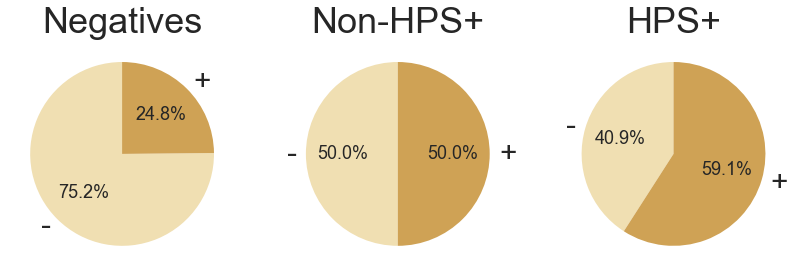

In [162]:
hpc_pie(tmp_df, 'l_mci', path_results + 'adni2_mci_hpc_lmci.pdf')

## cognitive decline

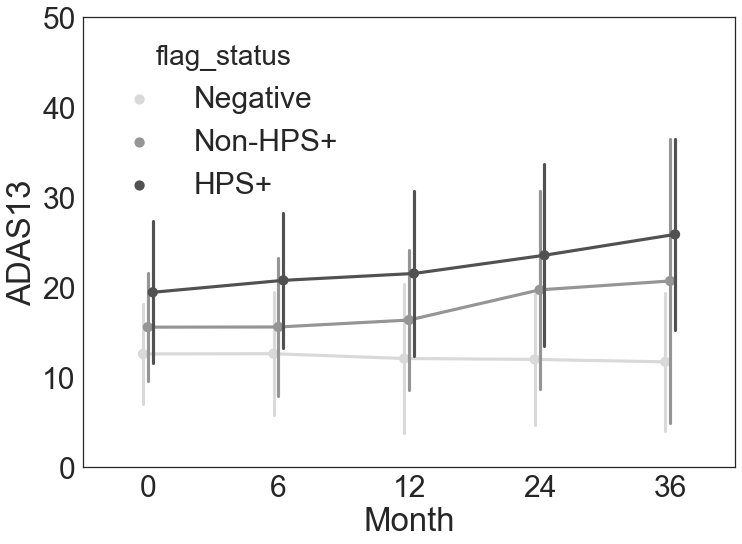

In [163]:
long_df_adni2_mci = pd.merge(long_data, df4[['RID','flag_status','f_s1_only','f_hpc']], how='left', on=['RID'])
long_df_adni2_mci.dropna(subset=['flag_status'],inplace=True)
long_df_adni2_mci.drop(long_df_adni2_mci[long_df_adni2_mci.Month==3].index,
                       inplace=True)
long_df_adni2_mci.drop(long_df_adni2_mci[long_df_adni2_mci.Month==18].index,
                       inplace=True)
long_df_adni2_mci.drop(long_df_adni2_mci[long_df_adni2_mci.Month==30].index,
                       inplace=True)
long_df_adni2_mci.reset_index(inplace=True, drop=True)
plt.close()
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.pointplot(x="Month", y="ADAS13", hue="flag_status", data=long_df_adni2_mci.dropna(subset=['ADAS13']), 
                dodge=True, hue_order=["Negative","Non-HPS+","HPS+"], palette="Greys", ci="sd")
plt.ylim(0, 50)
plt.show()
#fig.savefig(path_results + 'adni2_mci_adas13_long.pdf',bbox_inches='tight')

In [164]:
# save dataframe
adni2_mci_adas = long_df_adni2_mci[['RID','f_s1_only','f_hpc','Month','ADAS13']]
adni2_mci_adas.to_csv('/Users/AngelaTam/Desktop/adsf/adni1_vbm_adcn_subtypes_20171209/7clus/adni2_mci_adas.csv',
                     index=False)

## % progressors

observed freq: 
[[182  39  18]
 [ 55  37  26]]
Chi2:  32.2563477693
p value:  9.89972381525e-08
degress of freedom:  2
expected freq: 
[[ 158.66386555   50.87955182   29.45658263]
 [  78.33613445   25.12044818   14.54341737]]


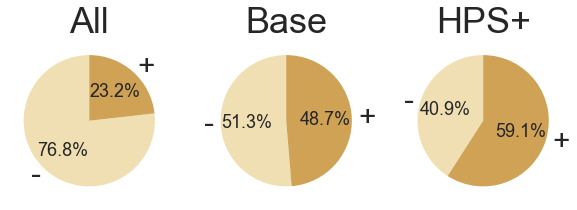

In [165]:
tmp_data = {'conv_2_ad': ['-','+'],
           'All': [182, 55],
           'Base': [39, 37],
           'HPS+': [18, 26]} 
tmp_df = pd.DataFrame(tmp_data, columns={'conv_2_ad', 'All', 'Base', 'HPS+'})

obs = tmp_df.as_matrix(columns=['All', 'Base', 'HPS+'])
chi2, p, dof, exf = scipy.stats.chi2_contingency(obs)
print('observed freq: ')
print(obs)
print('Chi2: ', chi2)
print('p value: ', p)
print('degress of freedom: ', dof)
print('expected freq: ')
print(exf)

plt.close()
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,6))
ax1.pie(tmp_df['All'], labels=tmp_df['conv_2_ad'],autopct='%1.1f%%',startangle=90)
ax1.set_title('All')
ax1.set(adjustable='box-forced', aspect='equal')
ax2.pie(tmp_df['Base'], labels=tmp_df['conv_2_ad'],autopct='%1.1f%%',startangle=90)
ax2.set_title('Base')
ax2.set(adjustable='box-forced', aspect='equal')
ax3.pie(tmp_df['HPS+'], labels=tmp_df['conv_2_ad'],autopct='%1.1f%%',startangle=90)
ax3.set_title('HPS+')
ax3.set(adjustable='box-forced', aspect='equal')
plt.show()

In [166]:
# post hoc pair-wise tests
obs = tmp_df.as_matrix(columns=['Base', 'HPS+'])
chi2, p, dof, exf = scipy.stats.chi2_contingency(obs)
print('observed freq: ')
print(obs)
print('Chi2: ', chi2)
print('p value: ', p)
print('degress of freedom: ', dof)
print('expected freq: ')
print(exf)

# post hoc pair-wise tests
obs = tmp_df.as_matrix(columns=['All', 'HPS+'])
chi2, p, dof, exf = scipy.stats.chi2_contingency(obs)
print('observed freq: ')
print(obs)
print('Chi2: ', chi2)
print('p value: ', p)
print('degress of freedom: ', dof)
print('expected freq: ')
print(exf)

observed freq: 
[[39 18]
 [37 26]]
Chi2:  0.828866424434
p value:  0.36260051911
degress of freedom:  1
expected freq: 
[[ 36.1  20.9]
 [ 39.9  23.1]]
observed freq: 
[[182  18]
 [ 55  26]]
Chi2:  21.5753138052
p value:  3.4020258523e-06
degress of freedom:  1
expected freq: 
[[ 168.68327402   31.31672598]
 [  68.31672598   12.68327402]]


In [167]:
tmp_df = chi2_fn(df4, 'conv_2_ad')

observed freq: 
[[ 143.   21.   18.]
 [  18.   11.   26.]]
Chi2:  47.0988884827
p value:  5.92388084098e-11
degress of freedom:  2
expected freq: 
[[ 123.6371308    24.57383966   33.78902954]
 [  37.3628692     7.42616034   10.21097046]]


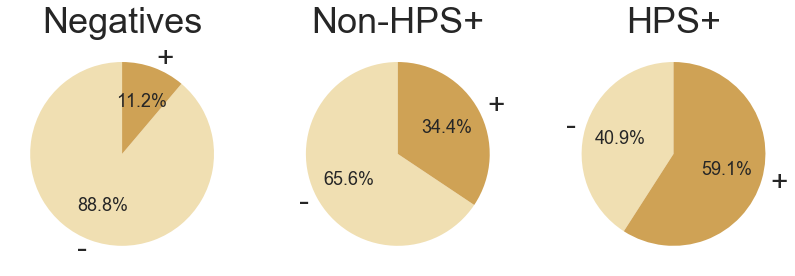

In [168]:
hpc_pie(tmp_df, 'conv_2_ad', path_results + 'adni2_mci_hpc_progressors.pdf')

In [169]:
# post hoc pair-wise tests
obs = tmp_df.as_matrix(columns=['Non-HPS+', 'HPS+'])
chi2, p, dof, exf = scipy.stats.chi2_contingency(obs)
print('observed freq: ')
print(obs)
print('Chi2: ', chi2)
print('p value: ', p)
print('degress of freedom: ', dof)
print('expected freq: ')
print(exf)

# post hoc pair-wise tests
obs = tmp_df.as_matrix(columns=['Negative', 'HPS+'])
chi2, p, dof, exf = scipy.stats.chi2_contingency(obs)
print('observed freq: ')
print(obs)
print('Chi2: ', chi2)
print('p value: ', p)
print('degress of freedom: ', dof)
print('expected freq: ')
print(exf)

observed freq: 
[[ 21.  18.]
 [ 11.  26.]]
Chi2:  3.59474421974
p value:  0.0579625476498
degress of freedom:  1
expected freq: 
[[ 16.42105263  22.57894737]
 [ 15.57894737  21.42105263]]
observed freq: 
[[ 143.   18.]
 [  18.   26.]]
Chi2:  44.2572551032
p value:  2.87935272255e-11
degress of freedom:  1
expected freq: 
[[ 126.44390244   34.55609756]
 [  34.55609756    9.44390244]]


/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


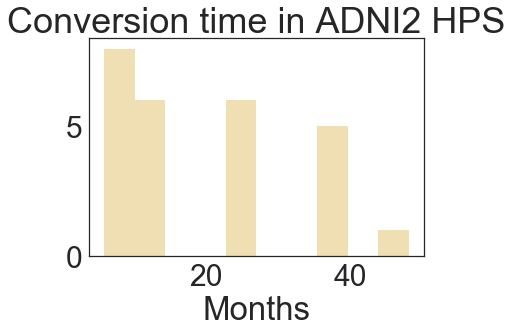

In [170]:
plt.hist(df4.dropna(subset=['Month_conv'])[df4.f_hpc==1]['Month_conv'].values)
plt.xlabel('Months')
plt.title('Conversion time in ADNI2 HPS')
plt.show()

## amyloid positivity (av45) in ADNI2 MCI

In [171]:
compare_ratio_var(df4, 'SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF', 'conv_2_ad')

baseline rate in NON-TARGET subjects:  0.448
##########
baseline rate in TARGET subjects:  0.9230769230769231
##########
number of subjects with VOI in the whole sample:  104.0
total number of subjects with VOI data in whole sample:  177
ratio:  0.5875706214689266
##########
number of subjects with VOI that are positive at stage 1:  48.0
total number of positive stage 1 subjects with VOI data:  65
ratio:  0.7384615384615385
##########
number of subjects with VOI in HPC-AD:  29.0
total number of HPC-AD subjects with VOI data:  39
ratio:  0.7435897435897436
##########
number of subjects with VOI in Non-HPC+:  19.0
total number of Non-HPC+ with VOI data:  26
ratio:  0.7307692307692307
##########
number of subjects with VOI in negative subjects:  56.0
total number of negative subjects with VOI data 112
ratio:  0.5


In [172]:
tmp_df = chi2_fn(df4, 'SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF')

observed freq: 
[[ 56.   7.  10.]
 [ 56.  19.  29.]]
Chi2:  9.66186572911
p value:  0.00797907439736
degress of freedom:  2
expected freq: 
[[ 46.1920904   10.72316384  16.08474576]
 [ 65.8079096   15.27683616  22.91525424]]


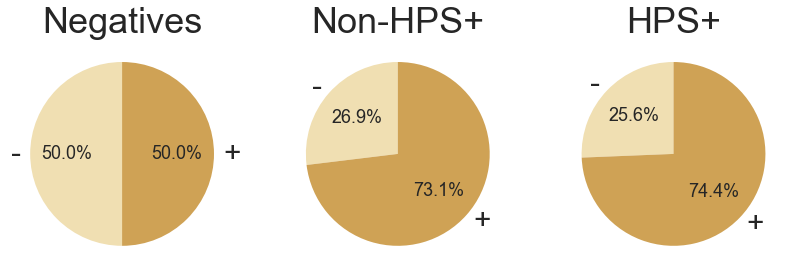

In [173]:
hpc_pie(tmp_df, 'SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF', path_results + 'adni2_mci_hpc_av45_pie.pdf')

## apoe4 carriership in ADNI2 MCI

In [174]:
compare_ratio_var(df4, 'APOE4_bin', 'conv_2_ad')

baseline rate in NON-TARGET subjects:  0.3626373626373626
##########
baseline rate in TARGET subjects:  0.6545454545454545
##########
number of subjects with VOI in the whole sample:  102.0
total number of subjects with VOI data in whole sample:  237
ratio:  0.43037974683544306
##########
number of subjects with VOI that are positive at stage 1:  35.0
total number of positive stage 1 subjects with VOI data:  76
ratio:  0.4605263157894737
##########
number of subjects with VOI in HPC-AD:  24.0
total number of HPC-AD subjects with VOI data:  44
ratio:  0.5454545454545454
##########
number of subjects with VOI in Non-HPC+:  11.0
total number of Non-HPC+ with VOI data:  32
ratio:  0.34375
##########
number of subjects with VOI in negative subjects:  67.0
total number of negative subjects with VOI data 161
ratio:  0.4161490683229814


In [175]:
tmp_df = chi2_fn(df4, 'APOE4_bin')

observed freq: 
[[ 94.  21.  20.]
 [ 67.  11.  24.]]
Chi2:  3.48930023426
p value:  0.174706104948
degress of freedom:  2
expected freq: 
[[ 91.70886076  18.2278481   25.06329114]
 [ 69.29113924  13.7721519   18.93670886]]


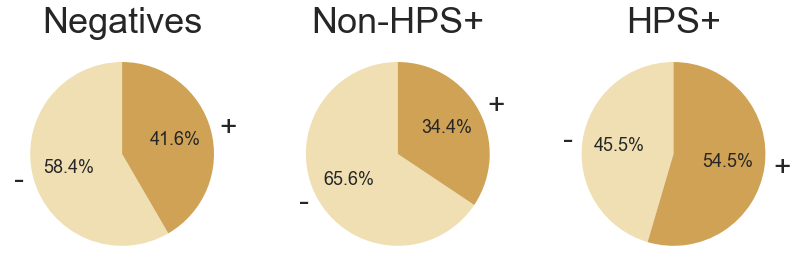

In [176]:
hpc_pie(tmp_df, 'APOE4_bin', path_results + 'adni2_mci_hpc_e4_pie.pdf')

## gender (% male) in ADNI2 MCI 

In [177]:
compare_ratio_var(df4, 'gender', 'conv_2_ad')

baseline rate in NON-TARGET subjects:  0.5274725274725275
##########
baseline rate in TARGET subjects:  0.509090909090909
##########
number of subjects with VOI in the whole sample:  124.0
total number of subjects with VOI data in whole sample:  237
ratio:  0.5232067510548524
##########
number of subjects with VOI that are positive at stage 1:  41.0
total number of positive stage 1 subjects with VOI data:  76
ratio:  0.5394736842105263
##########
number of subjects with VOI in HPC-AD:  25.0
total number of HPC-AD subjects with VOI data:  44
ratio:  0.5681818181818182
##########
number of subjects with VOI in Non-HPC+:  16.0
total number of Non-HPC+ with VOI data:  32
ratio:  0.5
##########
number of subjects with VOI in negative subjects:  83.0
total number of negative subjects with VOI data 161
ratio:  0.515527950310559


In [178]:
chi2_fn(df4, 'gender')

observed freq: 
[[ 78.  16.  19.]
 [ 83.  16.  25.]]
Chi2:  0.463912163777
p value:  0.792980948768
degress of freedom:  2
expected freq: 
[[ 76.76371308  15.25738397  20.97890295]
 [ 84.23628692  16.74261603  23.02109705]]


Negative  Non-HPS+  HPS+ gender
0      78.0      16.0  19.0      -
1      83.0      16.0  25.0      +

## age in ADNI2 MCI 

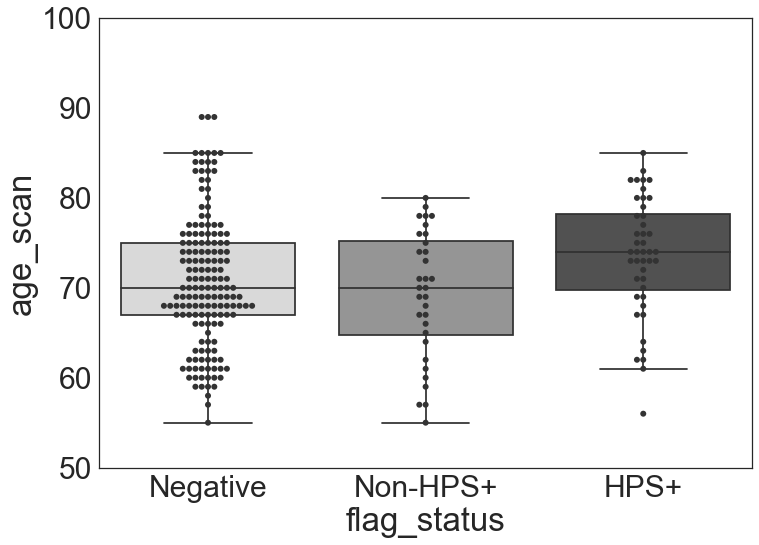

ANOVA F:  3.58019531266
p value:  0.029407344864
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative -2.6988  -5.5975   0.2   False 
  HPS+   Non-HPS+ -4.2188  -8.1777 -0.2598  True 
Negative Non-HPS+  -1.52   -4.8181  1.7781 False 
-------------------------------------------------


In [179]:
anova_hpc(df4, 'age_scan', 50, 100, path_results + 'adni2_mci_age.pdf')

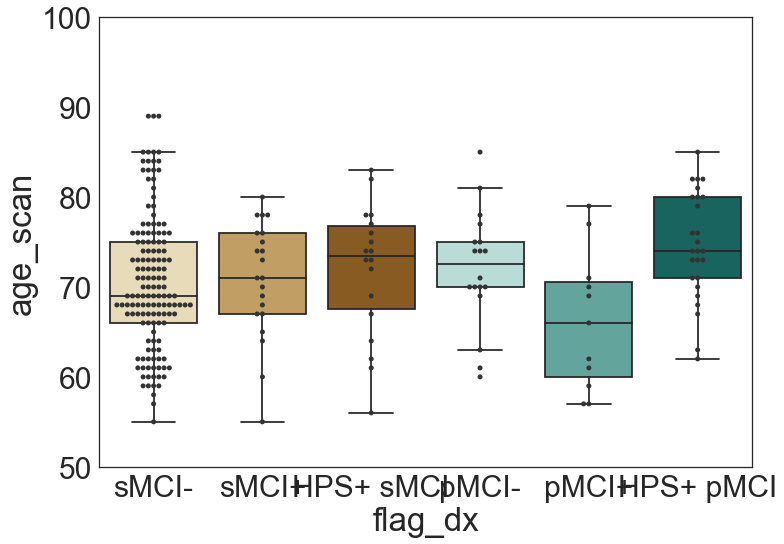

ANOVA F:  2.4983662413
p value:  0.0315903018209
 Multiple Comparison of Means - Tukey HSD,FWER=0.05 
  group1    group2  meandiff  lower    upper  reject
----------------------------------------------------
HPS+ pMCI HPS+ sMCI -2.7265  -9.0614   3.6084 False 
HPS+ pMCI   pMCI+   -8.4336  -15.8647 -1.0025  True 
HPS+ pMCI   pMCI-   -2.5598  -8.8947   3.7751 False 
HPS+ pMCI   sMCI+   -3.7106  -9.7722   2.351  False 
HPS+ pMCI   sMCI-    -3.972  -8.3768   0.4327 False 
HPS+ sMCI   pMCI+   -5.7071  -13.6139  2.1997 False 
HPS+ sMCI   pMCI-    0.1667  -6.7201   7.0534 False 
HPS+ sMCI   sMCI+   -0.9841  -7.6204   5.6521 False 
HPS+ sMCI   sMCI-   -1.2455  -6.4126   3.9215 False 
  pMCI+     pMCI-    5.8737  -2.0331  13.7806 False 
  pMCI+     sMCI+    4.7229  -2.9667  12.4126 False 
  pMCI+     sMCI-    4.4615  -2.0029   10.926 False 
  pMCI-     sMCI+   -1.1508   -7.787   5.4854 False 
  pMCI-     sMCI-   -1.4122  -6.5793   3.7549 False 
  sMCI+     sMCI-   -0.2614  -5.0895   4.5667 Fals

In [180]:
anova_hpc_split(df4, 'age_scan', 50, 100, 'sMCI', 'pMCI', path_results + 'adni2_mci_age_split.pdf')

## csf abeta in ADNI2 MCI

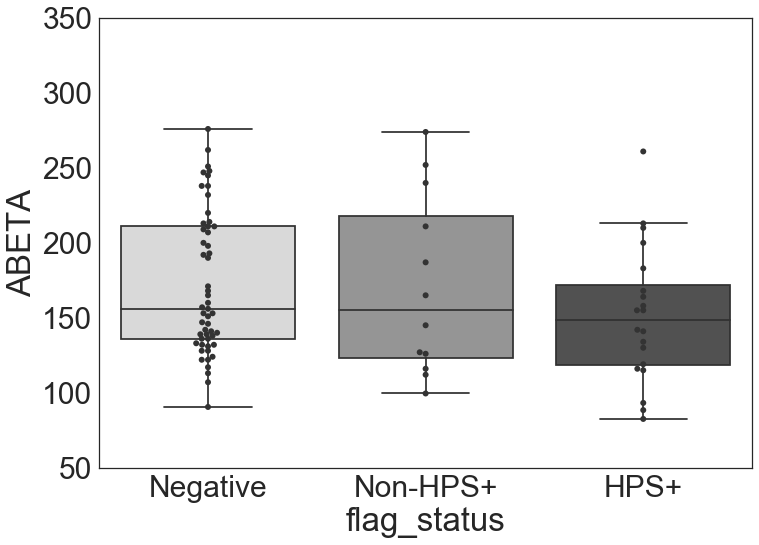

ANOVA F:  1.33868572942
p value:  0.267858756996
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower    upper  reject
--------------------------------------------------
  HPS+   Negative  20.529  -10.0189 51.0768 False 
  HPS+   Non-HPS+ 19.8033  -22.7018 62.3085 False 
Negative Non-HPS+ -0.7256  -37.9391 36.4879 False 
--------------------------------------------------


In [181]:
anova_hpc(df4, 'ABETA', 50, 350, path_results + 'adni2_mci_csf_abeta.pdf')

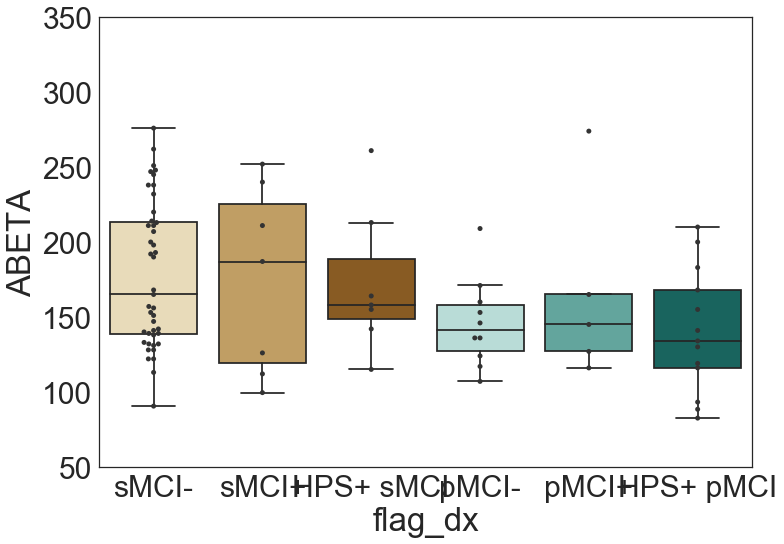

ANOVA F:  1.72637551623
p value:  0.138212369192
  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
  group1    group2  meandiff  lower    upper   reject
-----------------------------------------------------
HPS+ pMCI HPS+ sMCI 32.5637  -33.0732 98.2007  False 
HPS+ pMCI   pMCI+   25.3923  -48.285  99.0696  False 
HPS+ pMCI   pMCI-    5.8923  -52.9983 64.7829  False 
HPS+ pMCI   sMCI+   35.3495  -30.2875 100.9864 False 
HPS+ pMCI   sMCI-   37.9807  -6.3334  82.2948  False 
HPS+ sMCI   pMCI+   -7.1714  -89.1519 74.8091  False 
HPS+ sMCI   pMCI-   -26.6714 -95.6683 42.3254  False 
HPS+ sMCI   sMCI+    2.7857  -72.0519 77.6233  False 
HPS+ sMCI   sMCI-    5.4169  -51.6462 62.4801  False 
  pMCI+     pMCI-    -19.5   -96.1857 57.1857  False 
  pMCI+     sMCI+    9.9571  -72.0234 91.9376  False 
  pMCI+     sMCI-   12.5884  -53.5655 78.7423  False 
  pMCI-     sMCI+   29.4571  -39.5397  98.454  False 
  pMCI-     sMCI-   32.0884  -17.0655 81.2422  False 
  sMCI+     sMCI-    2.6312  -54.

In [182]:
anova_hpc_split(df4, 'ABETA', 50, 350, 'sMCI', 'pMCI', path_results + 'adni2_mci_csf_abeta_split.pdf')

## csf tau in ADNI2 MCI

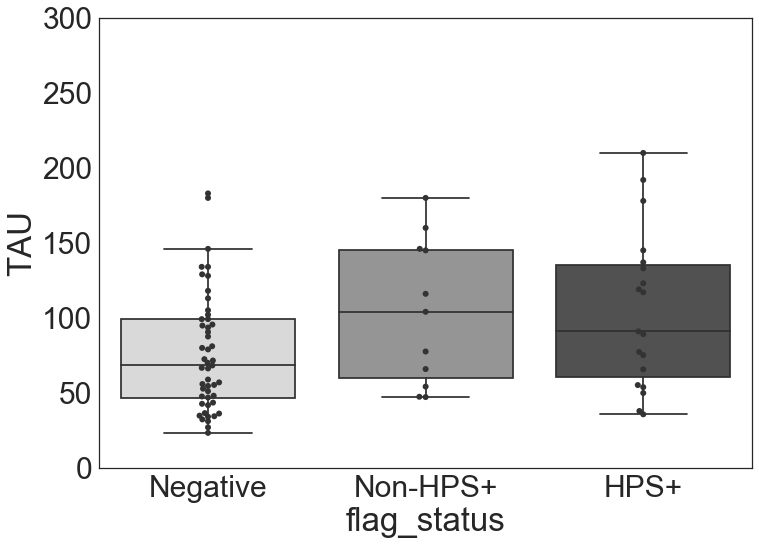

ANOVA F:  3.82058838967
p value:  0.0262392488215
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower    upper  reject
--------------------------------------------------
  HPS+   Negative -28.2852 -56.6095  0.0391 False 
  HPS+   Non-HPS+ -0.5249  -40.2319 39.1821 False 
Negative Non-HPS+ 27.7603  -7.2069  62.7275 False 
--------------------------------------------------


In [183]:
anova_hpc(df4, 'TAU', 0, 300, path_results + 'adni2_mci_csf_tau.pdf')

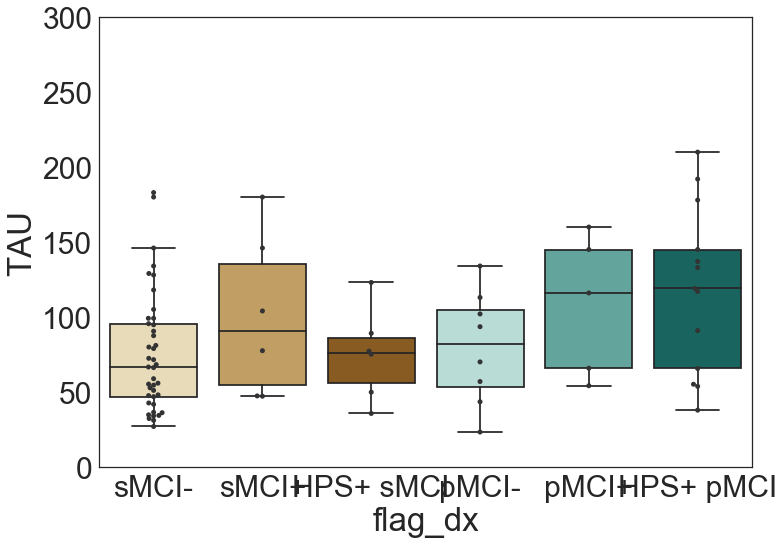

ANOVA F:  2.38437224283
p value:  0.0463692794265
  Multiple Comparison of Means - Tukey HSD,FWER=0.05  
  group1    group2  meandiff   lower    upper   reject
------------------------------------------------------
HPS+ pMCI HPS+ sMCI -43.041  -105.8891 19.8071  False 
HPS+ pMCI   pMCI+   -9.8277   -76.8381 57.1827  False 
HPS+ pMCI   pMCI-   -38.5077  -95.7287 18.7133  False 
HPS+ pMCI   sMCI+   -17.691   -80.5391 45.1571  False 
HPS+ pMCI   sMCI-   -42.5345  -83.0663 -2.0027   True 
HPS+ sMCI   pMCI+   33.2133   -43.8945 110.3211 False 
HPS+ sMCI   pMCI-    4.5333   -64.2378 73.3044  False 
HPS+ sMCI   sMCI+    25.35    -48.1694 98.8694  False 
HPS+ sMCI   sMCI-    0.5065   -55.1536 56.1666  False 
  pMCI+     pMCI-    -28.68  -101.2746 43.9146  False 
  pMCI+     sMCI+   -7.8633   -84.9711 69.2445  False 
  pMCI+     sMCI-   -32.7068  -93.0273 27.6136  False 
  pMCI-     sMCI+   20.8167   -47.9544 89.5878  False 
  pMCI-     sMCI-   -4.0268   -53.2448 45.1911  False 
  sMCI+     sMC

In [184]:
anova_hpc_split(df4, 'TAU', 0, 300, 'sMCI', 'pMCI', path_results + 'adni2_mci_csf_tau_split.pdf')

## cognition

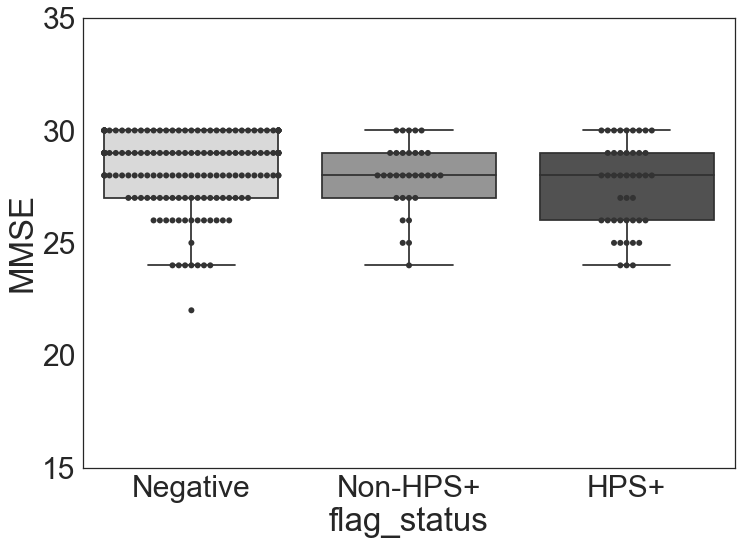

ANOVA F:  3.70415471528
p value:  0.0260826085789
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative  0.771    0.0915 1.4505  True 
  HPS+   Non-HPS+  0.446   -0.4813 1.3734 False 
Negative Non-HPS+  -0.325   -1.098 0.448  False 
------------------------------------------------


In [185]:
# mmse
anova_hpc(df4, 'MMSE', 15, 35, path_results + 'adni2_mci_mmse.pdf')

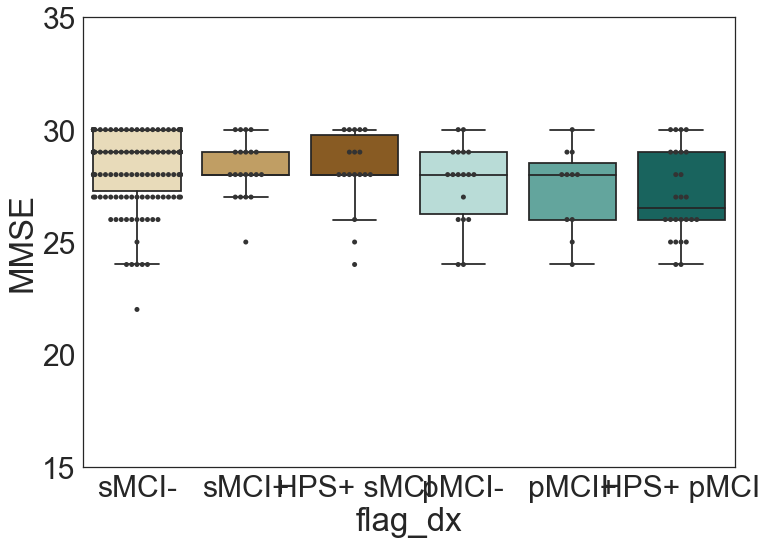

ANOVA F:  3.73589533596
p value:  0.00285296427231
Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower  upper  reject
--------------------------------------------------
HPS+ pMCI HPS+ sMCI  1.1838  -0.2823 2.6498 False 
HPS+ pMCI   pMCI+    0.3252  -1.3946 2.045  False 
HPS+ pMCI   pMCI-    0.5726  -0.8934 2.0387 False 
HPS+ pMCI   sMCI+    1.2473  -0.1556 2.6501 False 
HPS+ pMCI   sMCI-    1.3418   0.3219 2.3618  True 
HPS+ sMCI   pMCI+   -0.8586  -2.6885 0.9713 False 
HPS+ sMCI   pMCI-   -0.6111  -2.2049 0.9827 False 
HPS+ sMCI   sMCI+    0.0635  -1.4723 1.5993 False 
HPS+ sMCI   sMCI-    0.1581  -1.0382 1.3543 False 
  pMCI+     pMCI-    0.2475  -1.5824 2.0774 False 
  pMCI+     sMCI+    0.9221  -0.8575 2.7017 False 
  pMCI+     sMCI-    1.0166  -0.4798 2.5131 False 
  pMCI-     sMCI+    0.6746  -0.8612 2.2104 False 
  pMCI-     sMCI-    0.7692  -0.4271 1.9655 False 
  sMCI+     sMCI-    0.0946  -1.0233 1.2124 False 
-------------------------------

In [186]:
anova_hpc_split(df4, 'MMSE', 15, 35, 'sMCI', 'pMCI', path_results + 'adni2_mci_mmse_split.pdf')

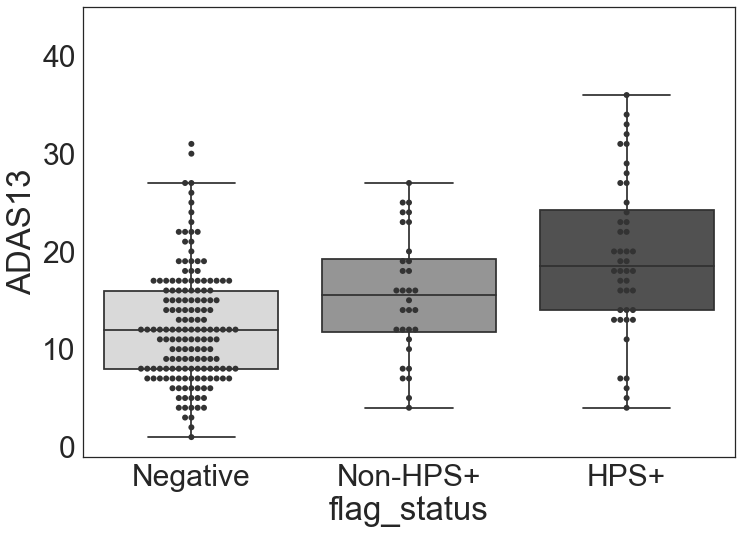

ANOVA F:  22.9366100182
p value:  8.13560341744e-10
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative -7.1348  -9.6719 -4.5977  True 
  HPS+   Non-HPS+ -3.9489  -7.4092 -0.4885  True 
Negative Non-HPS+  3.1859   0.3002  6.0717  True 
-------------------------------------------------


In [187]:
# adas_cog
anova_hpc(df4, 'ADAS13', -1, 45, path_results + 'adni2_mci_adas13.pdf')

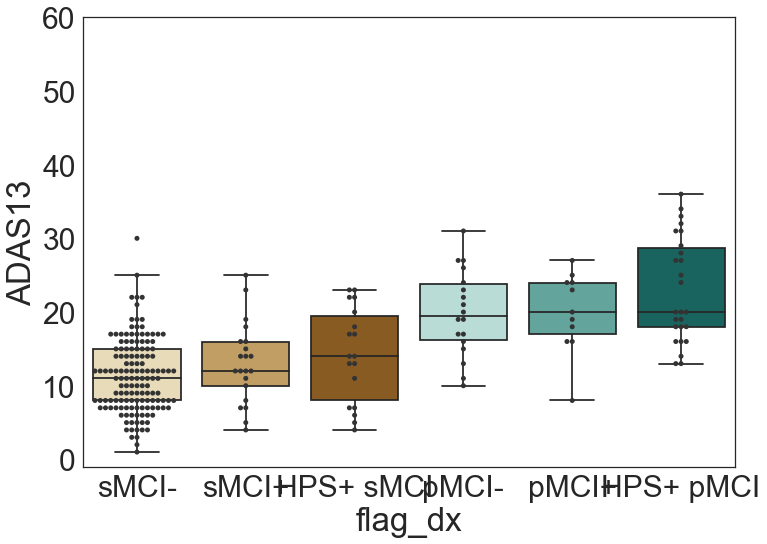

ANOVA F:  27.6927688055
p value:  6.74852023725e-22
 Multiple Comparison of Means - Tukey HSD,FWER=0.05 
  group1    group2  meandiff  lower    upper  reject
----------------------------------------------------
HPS+ pMCI HPS+ sMCI -8.7393  -13.5776  -3.901  True 
HPS+ pMCI   pMCI+   -2.9615  -8.6371   2.714  False 
HPS+ pMCI   pMCI-   -3.0726  -7.9109   1.7656 False 
HPS+ pMCI   sMCI+   -9.9139  -14.5435 -5.2843  True 
HPS+ pMCI   sMCI-   -11.6849 -15.0528 -8.3171  True 
HPS+ sMCI   pMCI+    5.7778  -0.2611  11.8166 False 
HPS+ sMCI   pMCI-    5.6667   0.4069  10.9264  True 
HPS+ sMCI   sMCI+   -1.1746   -6.243   3.8938 False 
HPS+ sMCI   sMCI-   -2.9456  -6.8951   1.0039 False 
  pMCI+     pMCI-   -0.1111   -6.15    5.9277 False 
  pMCI+     sMCI+   -6.9524  -12.8253 -1.0794  True 
  pMCI+     sMCI-   -8.7234  -13.6631 -3.7837  True 
  pMCI-     sMCI+   -6.8413  -11.9097 -1.7728  True 
  pMCI-     sMCI-   -8.6123  -12.5618 -4.6628  True 
  sMCI+     sMCI-    -1.771  -5.4619   1.9198 F

In [188]:
anova_hpc_split(df4, 'ADAS13', -1, 60, 'sMCI', 'pMCI', path_results + 'adni2_mci_adas13_split.pdf')

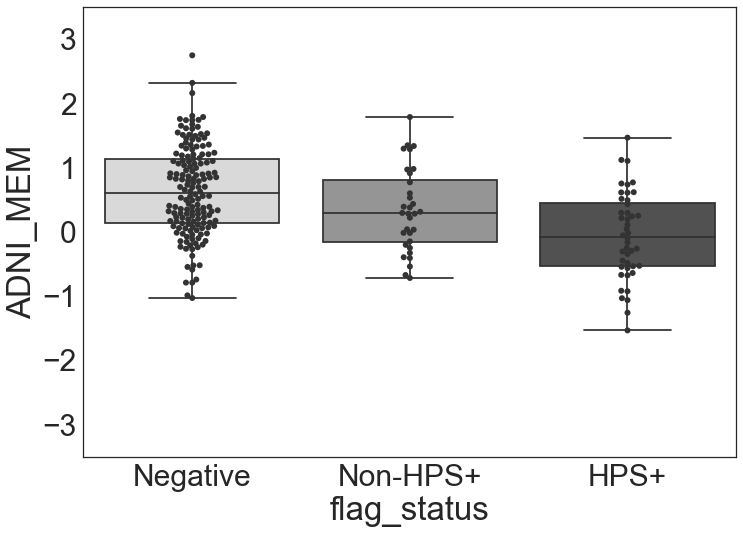

ANOVA F:  18.554203539
p value:  3.33254442007e-08
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative  0.6975   0.4226 0.9723  True 
  HPS+   Non-HPS+  0.3998   0.0246 0.7749  True 
Negative Non-HPS+ -0.2977  -0.6104 0.015  False 
------------------------------------------------


In [189]:
# adni_mem
anova_hpc(df4, 'ADNI_MEM', -3.5, 3.5, path_results + 'adni2_mci_memory.pdf')

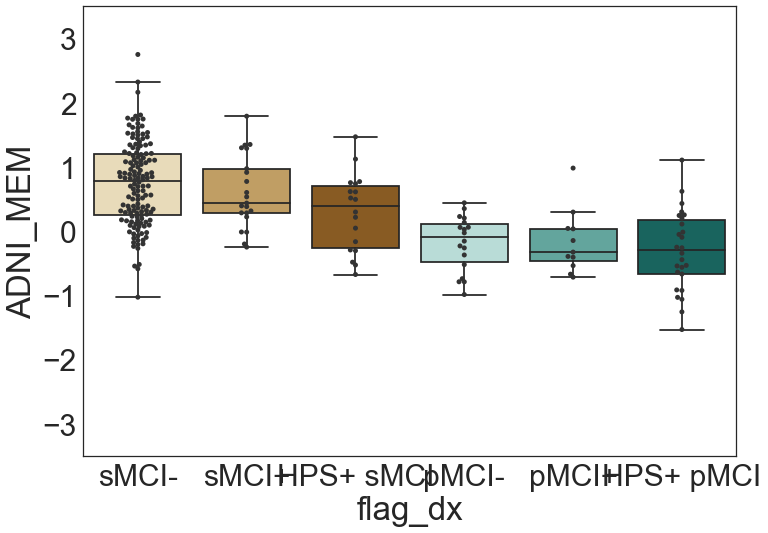

ANOVA F:  20.6339260068
p value:  5.19298775604e-17
Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower  upper  reject
--------------------------------------------------
HPS+ pMCI HPS+ sMCI  0.5916   0.0485 1.1347  True 
HPS+ pMCI   pMCI+    0.1351   -0.502 0.7722 False 
HPS+ pMCI   pMCI-    0.1152  -0.4279 0.6584 False 
HPS+ pMCI   sMCI+    0.9072   0.3875 1.4269  True 
HPS+ pMCI   sMCI-    1.044    0.6661 1.4218  True 
HPS+ sMCI   pMCI+   -0.4565  -1.1344 0.2214 False 
HPS+ sMCI   pMCI-   -0.4763  -1.0668 0.1141 False 
HPS+ sMCI   sMCI+    0.3156  -0.2534 0.8846 False 
HPS+ sMCI   sMCI-    0.4524   0.0092 0.8956  True 
  pMCI+     pMCI-   -0.0198  -0.6977 0.6581 False 
  pMCI+     sMCI+    0.7721   0.1128 1.4314  True 
  pMCI+     sMCI-    0.9089   0.3545 1.4633  True 
  pMCI-     sMCI+    0.7919   0.223  1.3609  True 
  pMCI-     sMCI-    0.9287   0.4855 1.3719  True 
  sMCI+     sMCI-    0.1368  -0.2773 0.5509 False 
------------------------------

In [190]:
anova_hpc_split(df4, 'ADNI_MEM', -3.5, 3.5, 'sMCI', 'pMCI', path_results + 'adni2_mci_memory_split.pdf')

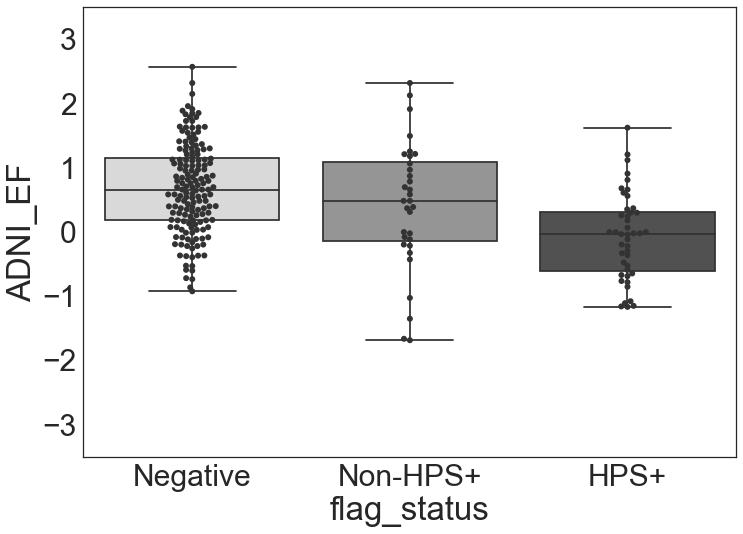

ANOVA F:  17.8123579871
p value:  6.3308113952e-08
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff lower  upper  reject
-----------------------------------------------
  HPS+   Negative  0.7491  0.4508 1.0474  True 
  HPS+   Non-HPS+  0.4844  0.0773 0.8916  True 
Negative Non-HPS+ -0.2647  -0.604 0.0747 False 
-----------------------------------------------


In [191]:
# adni executive function
anova_hpc(df4, 'ADNI_EF', -3.5, 3.5, path_results + 'adni2_mci_ef.pdf')

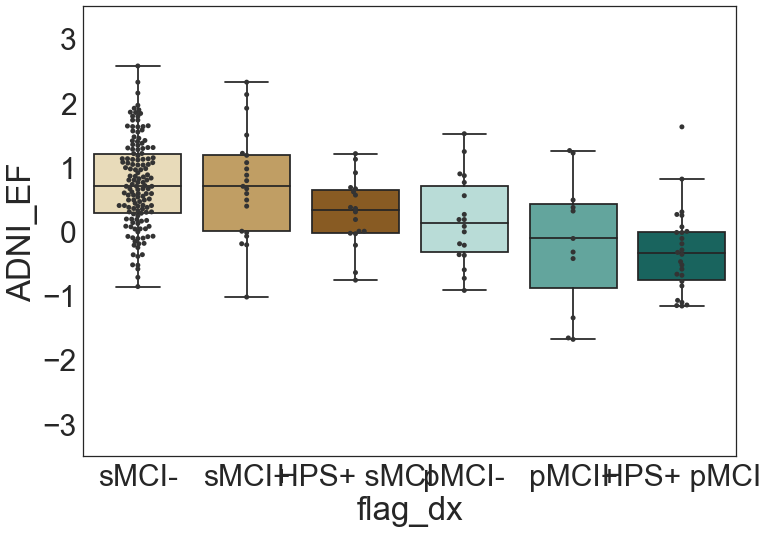

ANOVA F:  14.0623050854
p value:  5.30626814618e-12
Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower  upper  reject
--------------------------------------------------
HPS+ pMCI HPS+ sMCI  0.6101  -0.0091 1.2292 False 
HPS+ pMCI   pMCI+    0.1434  -0.5829 0.8696 False 
HPS+ pMCI   pMCI-    0.4903  -0.1288 1.1094 False 
HPS+ pMCI   sMCI+    1.0434   0.451  1.6358  True 
HPS+ pMCI   sMCI-    1.0631   0.6324 1.4938  True 
HPS+ sMCI   pMCI+   -0.4667  -1.2394 0.3061 False 
HPS+ sMCI   pMCI-   -0.1198  -0.7928 0.5533 False 
HPS+ sMCI   sMCI+    0.4333  -0.2152 1.0819 False 
HPS+ sMCI   sMCI-    0.4531  -0.0521 0.9582 False 
  pMCI+     pMCI-    0.3469  -0.4259 1.1196 False 
  pMCI+     sMCI+     0.9     0.1485 1.6515  True 
  pMCI+     sMCI-    0.9197   0.2878 1.5517  True 
  pMCI-     sMCI+    0.5531  -0.0955 1.2017 False 
  pMCI-     sMCI-    0.5728   0.0677 1.078   True 
  sMCI+     sMCI-    0.0197  -0.4523 0.4918 False 
------------------------------

In [192]:
anova_hpc_split(df4, 'ADNI_EF', -3.5, 3.5, 'sMCI', 'pMCI', path_results + 'adni2_mci_ef_split.pdf')

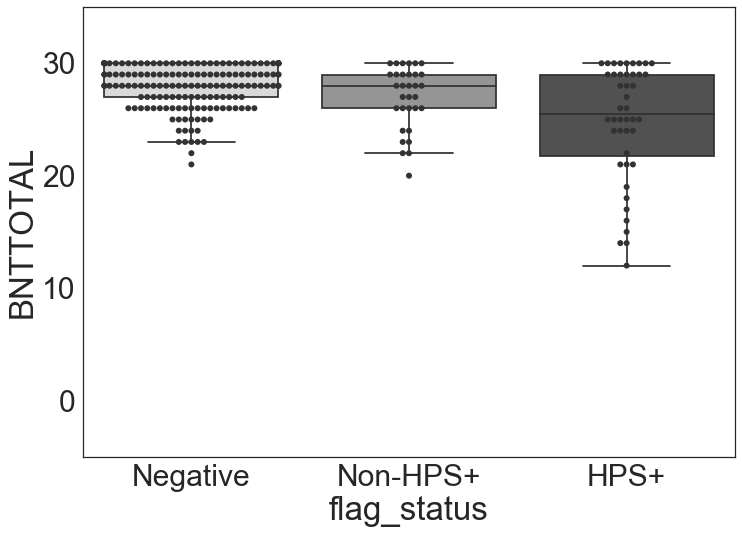

ANOVA F:  18.5702561695
p value:  3.28671852873e-08
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative  3.0631   1.8742 4.2519  True 
  HPS+   Non-HPS+  2.1506   0.528  3.7731  True 
Negative Non-HPS+ -0.9125  -2.2649 0.4399 False 
------------------------------------------------


In [193]:
# language
anova_hpc(df4, 'BNTTOTAL', -5, 35, path_results + 'adni2_mci_language.pdf')

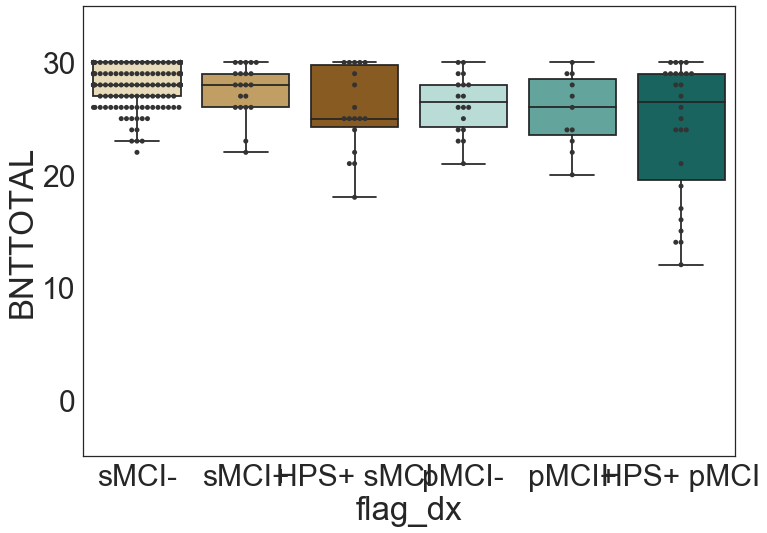

ANOVA F:  10.2638228132
p value:  6.78848616541e-09
Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower  upper  reject
--------------------------------------------------
HPS+ pMCI HPS+ sMCI  1.6239  -0.9326 4.1804 False 
HPS+ pMCI   pMCI+    1.4825  -1.5164 4.4814 False 
HPS+ pMCI   pMCI-    2.1795   -0.377 4.736  False 
HPS+ pMCI   sMCI+    3.5128   1.0666 5.959   True 
HPS+ pMCI   sMCI-    3.9236   2.1451 5.7022  True 
HPS+ sMCI   pMCI+   -0.1414  -3.3323 3.0495 False 
HPS+ sMCI   pMCI-    0.5556  -2.2237 3.3348 False 
HPS+ sMCI   sMCI+    1.8889  -0.7892 4.567  False 
HPS+ sMCI   sMCI-    2.2997   0.2136 4.3857  True 
  pMCI+     pMCI-    0.697   -2.4939 3.8878 False 
  pMCI+     sMCI+    2.0303  -1.0729 5.1335 False 
  pMCI+     sMCI-    2.4411  -0.1683 5.0505 False 
  pMCI-     sMCI+    1.3333  -1.3448 4.0115 False 
  pMCI-     sMCI-    1.7441  -0.3419 3.8302 False 
  sMCI+     sMCI-    0.4108  -1.5385 2.3601 False 
------------------------------

In [194]:
anova_hpc_split(df4, 'BNTTOTAL', -5, 35, 'sMCI', 'pMCI', path_results + 'adni2_mci_language_split.pdf')

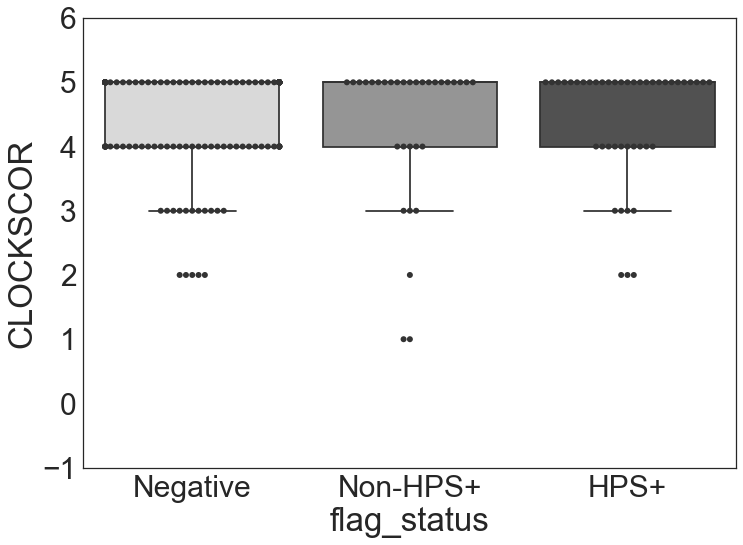

ANOVA F:  0.867594320416
p value:  0.421312806525
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative  0.1199  -0.2244 0.4642 False 
  HPS+   Non-HPS+ -0.0739  -0.5438 0.3961 False 
Negative Non-HPS+ -0.1937  -0.5854 0.1979 False 
------------------------------------------------


In [195]:
# vis spat
anova_hpc(df4, 'CLOCKSCOR', -1, 6, path_results + 'adni2_mci_clock.pdf')

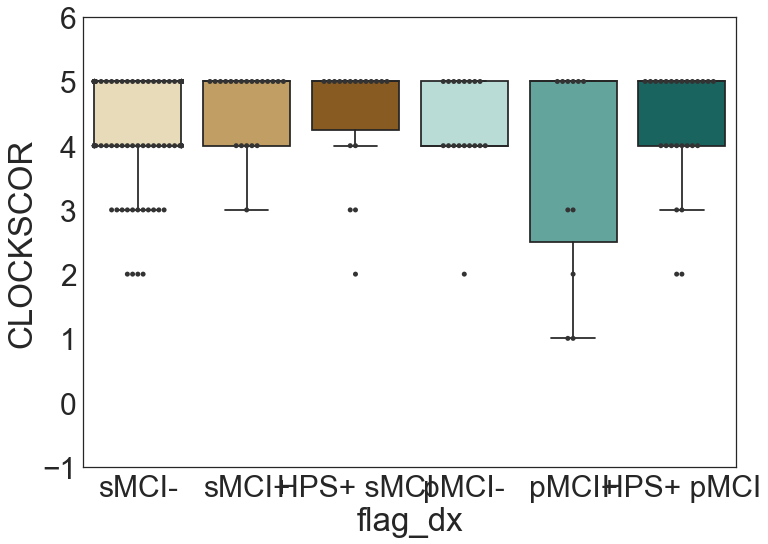

ANOVA F:  2.81093612143
p value:  0.0174165066523
Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower  upper  reject
--------------------------------------------------
HPS+ pMCI HPS+ sMCI  0.1923  -0.5487 0.9333 False 
HPS+ pMCI   pMCI+   -0.6713  -1.5406 0.1979 False 
HPS+ pMCI   pMCI-    0.0256  -0.7154 0.7666 False 
HPS+ pMCI   sMCI+    0.359   -0.3501 1.068  False 
HPS+ pMCI   sMCI-    0.2205   -0.295 0.736  False 
HPS+ sMCI   pMCI+   -0.8636  -1.7885 0.0612 False 
HPS+ sMCI   pMCI-   -0.1667  -0.9722 0.6389 False 
HPS+ sMCI   sMCI+    0.1667  -0.6096 0.9429 False 
HPS+ sMCI   sMCI-    0.0282  -0.5765 0.6328 False 
  pMCI+     pMCI-    0.697   -0.2279 1.6218 False 
  pMCI+     sMCI+    1.0303   0.1308 1.9298  True 
  pMCI+     sMCI-    0.8918   0.1355 1.6482  True 
  pMCI-     sMCI+    0.3333  -0.4429 1.1096 False 
  pMCI-     sMCI-    0.1948  -0.4098 0.7995 False 
  sMCI+     sMCI-   -0.1385  -0.7035 0.4265 False 
--------------------------------

In [196]:
anova_hpc_split(df4, 'CLOCKSCOR', -1, 6, 'sMCI', 'pMCI', path_results + 'adni2_mci_clock_split.pdf')

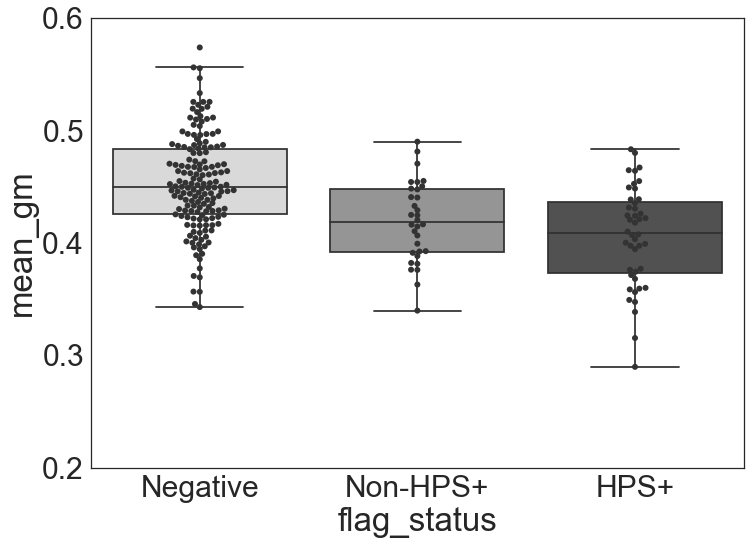

ANOVA F:  26.2127405205
p value:  5.34431604282e-11
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative  0.0471   0.0303  0.064   True 
  HPS+   Non-HPS+  0.0133  -0.0096  0.0363 False 
Negative Non-HPS+ -0.0338  -0.0529 -0.0146  True 
-------------------------------------------------


In [197]:
anova_hpc(df4, 'mean_gm', 0.2, 0.6, path_results + 'adni2_mci_meangm.pdf')

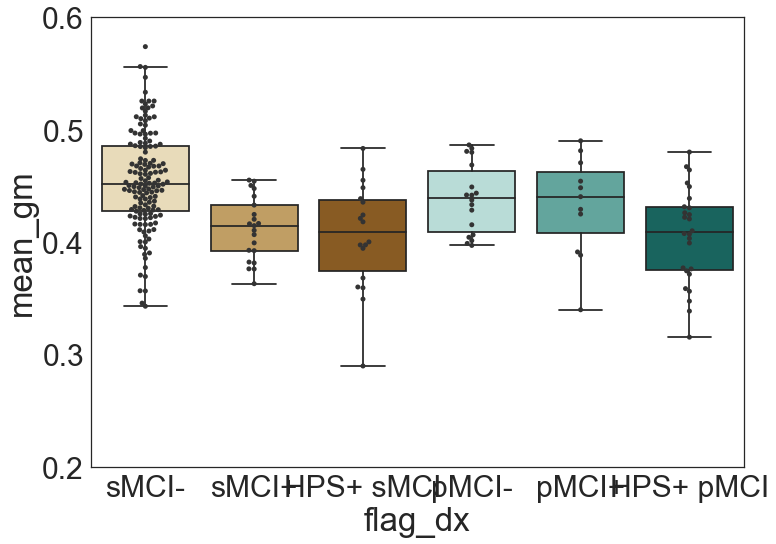

ANOVA F:  11.3418282949
p value:  8.50943730046e-10
Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower  upper  reject
--------------------------------------------------
HPS+ pMCI HPS+ sMCI  0.0001  -0.0368 0.0369 False 
HPS+ pMCI   pMCI+    0.0268  -0.0164 0.0701 False 
HPS+ pMCI   pMCI-    0.033   -0.0039 0.0699 False 
HPS+ pMCI   sMCI+    0.0063   -0.029 0.0416 False 
HPS+ pMCI   sMCI-    0.0489   0.0233 0.0746  True 
HPS+ sMCI   pMCI+    0.0268  -0.0193 0.0728 False 
HPS+ sMCI   pMCI-    0.0329  -0.0072 0.073  False 
HPS+ sMCI   sMCI+    0.0063  -0.0324 0.0449 False 
HPS+ sMCI   sMCI-    0.0489   0.0188 0.0789  True 
  pMCI+     pMCI-    0.0062  -0.0399 0.0522 False 
  pMCI+     sMCI+   -0.0205  -0.0653 0.0243 False 
  pMCI+     sMCI-    0.0221  -0.0155 0.0597 False 
  pMCI-     sMCI+   -0.0267  -0.0653 0.012  False 
  pMCI-     sMCI-    0.0159  -0.0141 0.046  False 
  sMCI+     sMCI-    0.0426   0.0145 0.0707  True 
------------------------------

In [198]:
anova_hpc_split(df4, 'mean_gm', 0.2, 0.6, 'sMCI', 'pMCI', path_results + 'adni2_mci_meangm_split.pdf')